In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

In [2]:
# Fill this with the experiment dir printed by the driver
exp_dir = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c")

# Load transformed outputs
fa_dir = exp_dir / "models" / "sklearn_fa_100"
fs_dir = exp_dir / "models" / "factosig_100"
adata_fa = sc.read_h5ad(fa_dir / "transformed_data.h5ad")
adata_fs = sc.read_h5ad(fs_dir / "transformed_data.h5ad")

# Load metrics
with open(fa_dir / "dr_metrics.json") as f:
    metrics_fa = json.load(f)
with open(fs_dir / "dr_metrics.json") as f:
    metrics_fs = json.load(f)

In [3]:
# Extract factor scores (Z) (factor by cell)
Z_fa = adata_fa.obsm["X_sklearn_fa"]
Z_fs = adata_fs.obsm["fs_scores"]

print(f"scikit-learn FA scores shape: {Z_fa.shape}")
print(f"FactoSig scores shape: {Z_fs.shape}")

scikit-learn FA scores shape: (60118, 100)
FactoSig scores shape: (60118, 100)


## 3.1 Correlation / Cosine Kernels

Let $Z \in R^{N \times K}$ be Stage-1 factor scores (global FA/NMF/PCA). Suppose you pick a subset $K'$ of “top distinguishing” factors (by per-patient AUC or your separation score). Build:

- **Pearson correlation** $C_{jk} = corr(Z_{\cdot j}, Z_{\cdot k})$.
- **Cosine similarity** $S_{jk} = \frac{\langle Z_{\cdot j}, Z_{\cdot k} \rangle}{\|Z_{\cdot j}\| \|Z_{\cdot k}\|}$.
- *Distance correlation / HSIC* to capture nonlinearity.
- *Partial correlation / precision* via graphical lasso on $Z$ to get conditional relationships.

Cluster this $K' \times K'$ matrix (hierarchical or spectral). You’ll see blocks = collinear/commonly co-activated factor groups.


Zooming Pearson correlation color scale to [-0.012, 0.011]


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


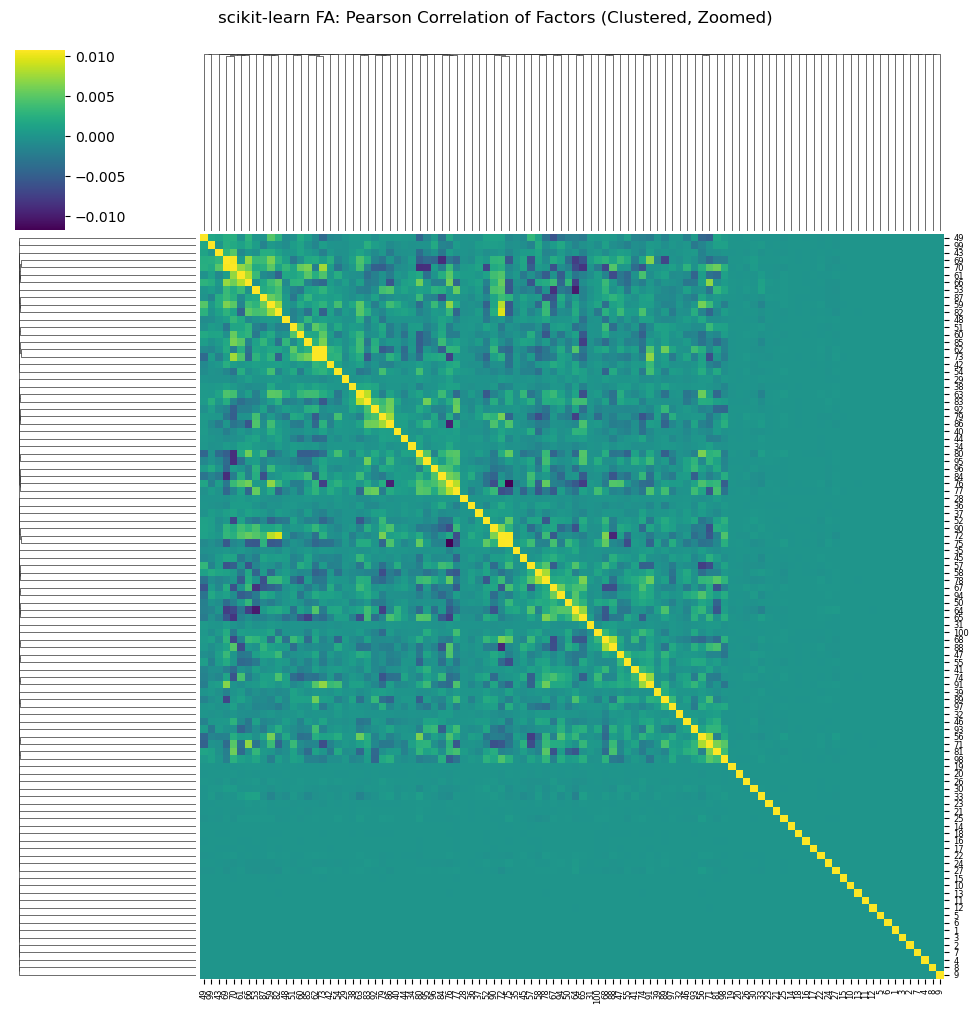

Zooming Cosine similarity color scale to [-0.012, 0.011]


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


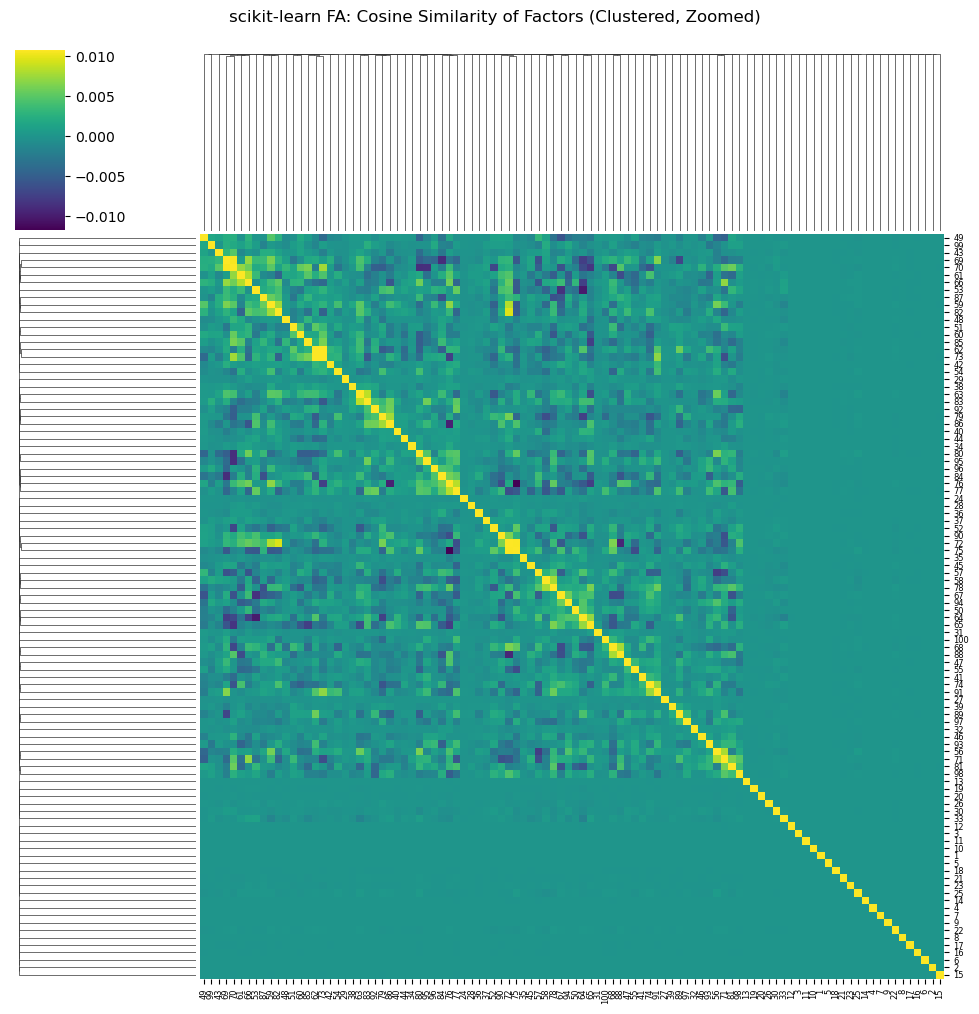

In [5]:
# scikit-learn FA: Correlation and Cosine Similarity
fa_factor_labels = np.arange(1, Z_fa.shape[1] + 1)
corr_fa = pd.DataFrame(Z_fa, columns=fa_factor_labels).corr()
cossim_fa = pd.DataFrame(cosine_similarity(Z_fa.T), index=fa_factor_labels, columns=fa_factor_labels)

# --- Pearson Correlation ---
# Zoom color scale to off-diagonal range to see subtle patterns
corr_fa_no_diag = corr_fa.copy()
np.fill_diagonal(corr_fa_no_diag.values, np.nan)
vmin = np.nanmin(corr_fa_no_diag.values)
vmax = np.nanmax(corr_fa_no_diag.values)
print(f"Zooming Pearson correlation color scale to [{vmin:.3f}, {vmax:.3f}]")

g = sns.clustermap(corr_fa, cmap="viridis", vmin=vmin, vmax=vmax, figsize=(10,10), xticklabels=True, yticklabels=True)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=6, rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=6)
plt.suptitle("scikit-learn FA: Pearson Correlation of Factors (Clustered, Zoomed)", y=1.02)
plt.show()

# --- Cosine Similarity ---
cossim_fa_no_diag = cossim_fa.copy()
np.fill_diagonal(cossim_fa_no_diag.values, np.nan)
vmin_cos = np.nanmin(cossim_fa_no_diag.values)
vmax_cos = np.nanmax(cossim_fa_no_diag.values)
print(f"Zooming Cosine similarity color scale to [{vmin_cos:.3f}, {vmax_cos:.3f}]")

g = sns.clustermap(cossim_fa, cmap="viridis", vmin=vmin_cos, vmax=vmax_cos, figsize=(10,10), xticklabels=True, yticklabels=True)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=6, rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=6)
plt.suptitle("scikit-learn FA: Cosine Similarity of Factors (Clustered, Zoomed)", y=1.02)
plt.show()


Zooming Pearson correlation color scale to [-0.059, 0.051]


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


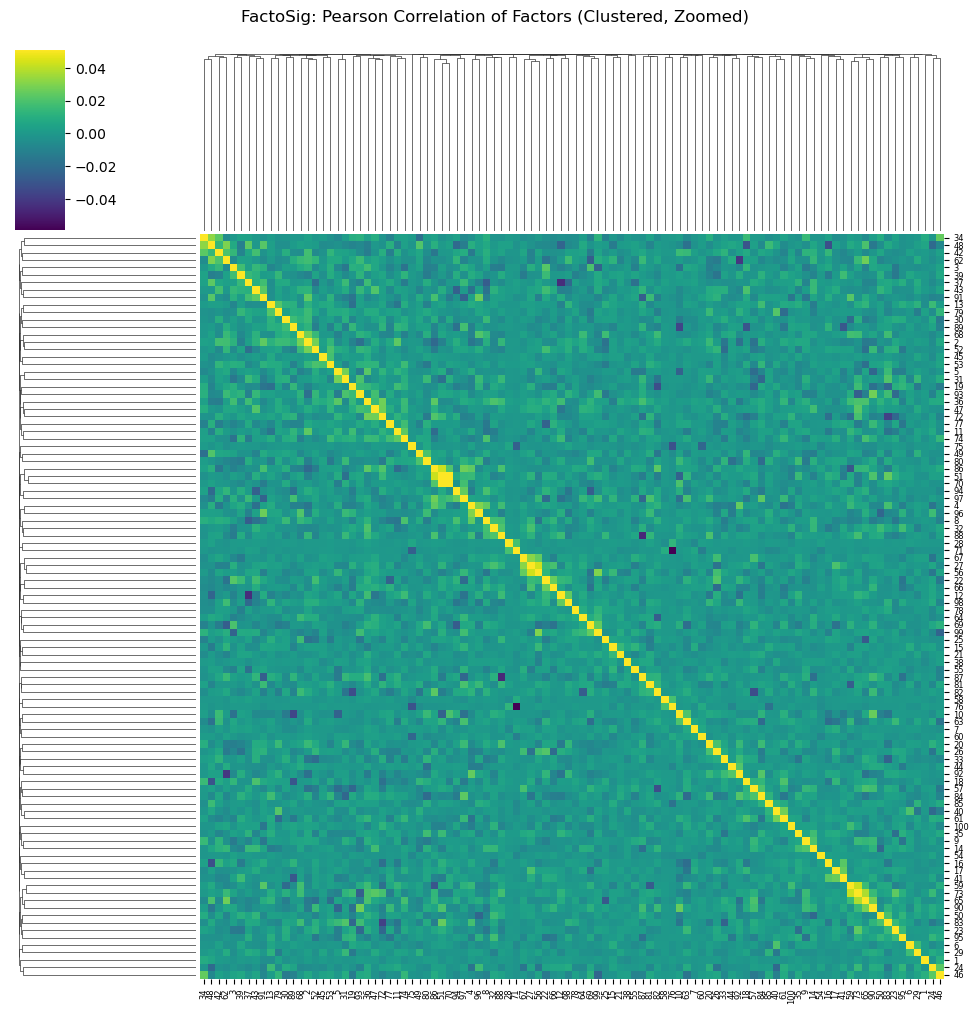

Zooming Cosine similarity color scale to [-0.059, 0.051]


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


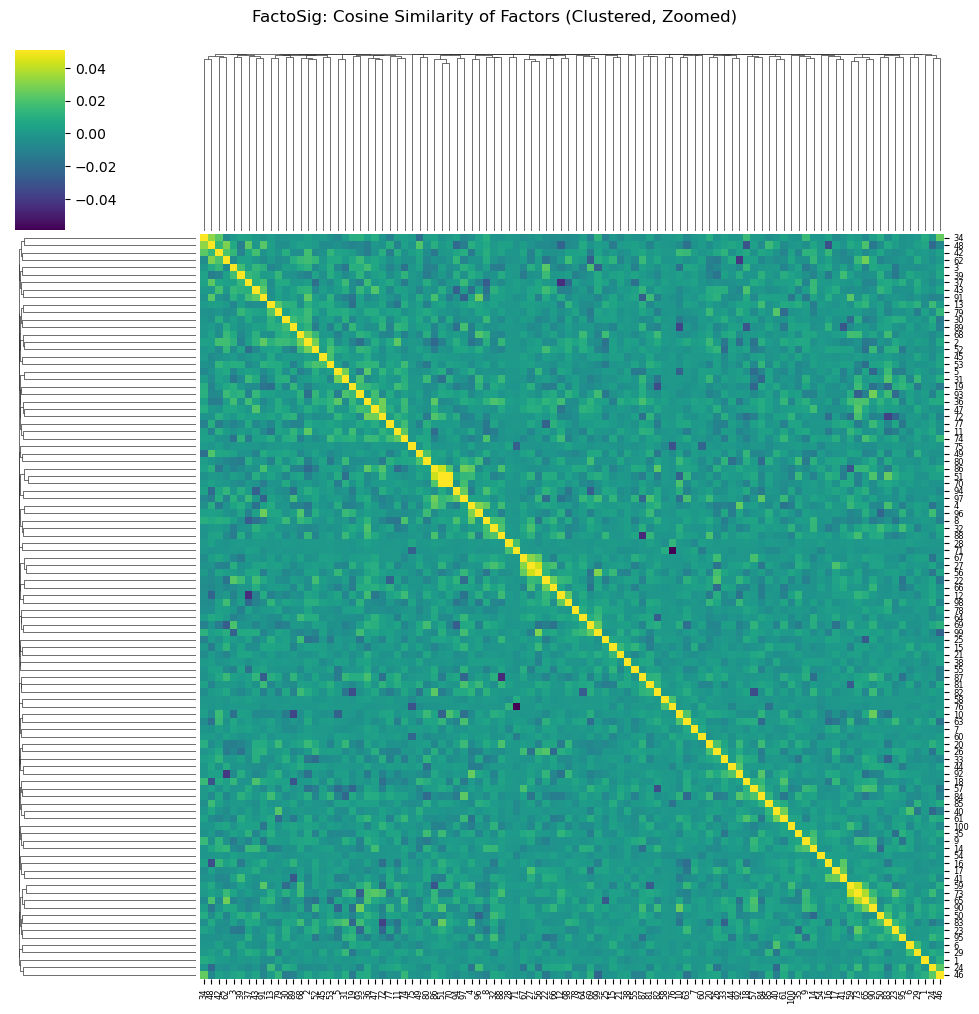

In [6]:
# FactoSig: Correlation and Cosine Similarity
fs_factor_labels = np.arange(1, Z_fs.shape[1] + 1)
corr_fs = pd.DataFrame(Z_fs, columns=fs_factor_labels).corr()
cossim_fs = pd.DataFrame(cosine_similarity(Z_fs.T), index=fs_factor_labels, columns=fs_factor_labels)

# --- Pearson Correlation ---
corr_fs_no_diag = corr_fs.copy()
np.fill_diagonal(corr_fs_no_diag.values, np.nan)
vmin = np.nanmin(corr_fs_no_diag.values)
vmax = np.nanmax(corr_fs_no_diag.values)
print(f"Zooming Pearson correlation color scale to [{vmin:.3f}, {vmax:.3f}]")

g = sns.clustermap(corr_fs, cmap="viridis", vmin=vmin, vmax=vmax, figsize=(10,10), xticklabels=True, yticklabels=True)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=6, rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=6)
plt.suptitle("FactoSig: Pearson Correlation of Factors (Clustered, Zoomed)", y=1.02)
plt.show()

# --- Cosine Similarity ---
cossim_fs_no_diag = cossim_fs.copy()
np.fill_diagonal(cossim_fs_no_diag.values, np.nan)
vmin_cos = np.nanmin(cossim_fs_no_diag.values)
vmax_cos = np.nanmax(cossim_fs_no_diag.values)
print(f"Zooming Cosine similarity color scale to [{vmin_cos:.3f}, {vmax_cos:.3f}]")

g = sns.clustermap(cossim_fs, cmap="viridis", vmin=vmin_cos, vmax=vmax_cos, figsize=(10,10), xticklabels=True, yticklabels=True)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=6, rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=6)
plt.suptitle("FactoSig: Cosine Similarity of Factors (Clustered, Zoomed)", y=1.02)
plt.show()

## 3.2 Add the target row/column

Add a vector representing the label:

- **Point-biserial correlation** between each factor and $y$.
- Or fit a simple univariate logistic per factor and take the signed z-score.

Append this as “Target” to the matrix—now you can visually see which blocks align most with malignant vs healthy.


Value counts for CN.label:
CN.label
normal    58549
cancer     1569
Name: count, dtype: int64

Target mapping: {0: 'cancer', 1: 'normal'}


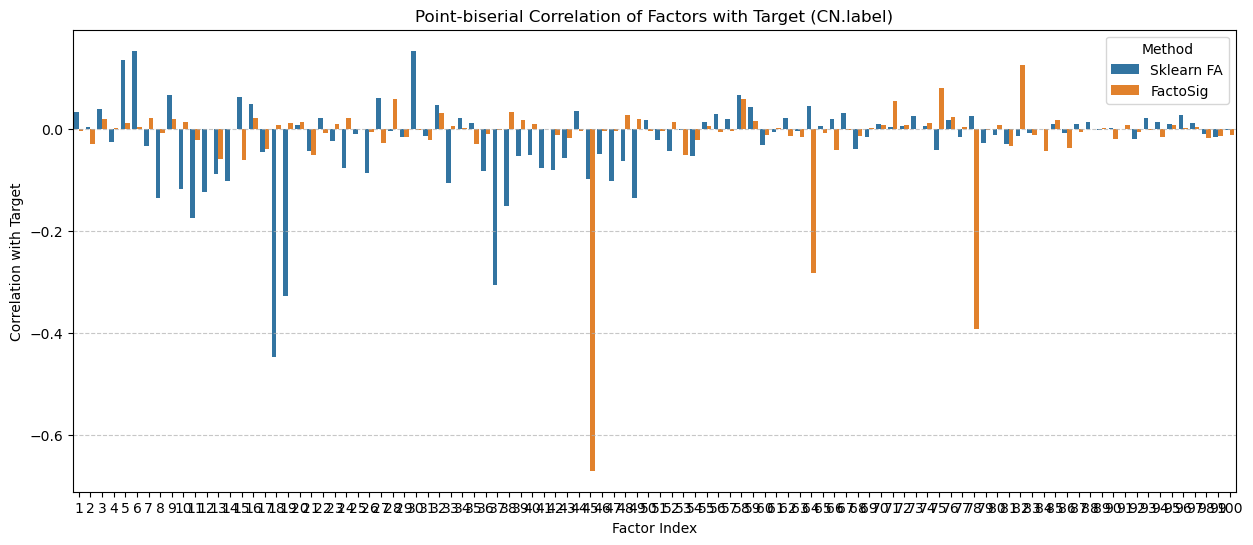

In [7]:
# Inspect and prepare the target variable 'CN.label'
print("Value counts for CN.label:")
print(adata_fa.obs['CN.label'].value_counts())

# Encode labels to numeric
le = LabelEncoder()
y = le.fit_transform(adata_fa.obs['CN.label'])
target_mapping = {i: label for i, label in enumerate(le.classes_)}
print(f"\nTarget mapping: {target_mapping}")


# Calculate point-biserial correlation for each factor
pbc_fa = [pointbiserialr(Z_fa[:, i], y)[0] for i in range(Z_fa.shape[1])]
pbc_fs = [pointbiserialr(Z_fs[:, i], y)[0] for i in range(Z_fs.shape[1])]

# Create a DataFrame for plotting
pbc_df = pd.DataFrame({
    'Factor': np.arange(1, Z_fa.shape[1] + 1),
    'Sklearn FA': pbc_fa,
    'FactoSig': pbc_fs
}).melt(id_vars='Factor', var_name='Method', value_name='Point-biserial Correlation')

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(data=pbc_df, x='Factor', y='Point-biserial Correlation', hue='Method')
plt.title("Point-biserial Correlation of Factors with Target (CN.label)")
plt.ylabel("Correlation with Target")
plt.xlabel("Factor Index")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 3.3 From correlation to model diagnostics

- **Variance Inflation Factor (VIF)**: regress factor $j$ on others; $VIF_j = \frac{1}{1-R_j^2}$. Large VIF ⇒ collinearity risk; favors ridge/ENet over pure lasso.
- **Principal angles between subspaces**: if you have two blocks $A, B$, compute principal angles to quantify redundancy; small angles ⇒ similar subspaces.
- **Block-aware grouping**: define groups from your clustered $C$; use group lasso / sparse-group lasso in Stage-2 (groups = blocks). This formalizes “pick a few blocks, not 20 correlated factors”.


Calculating VIF for scikit-learn FA factors...
Calculating VIF for FactoSig factors...


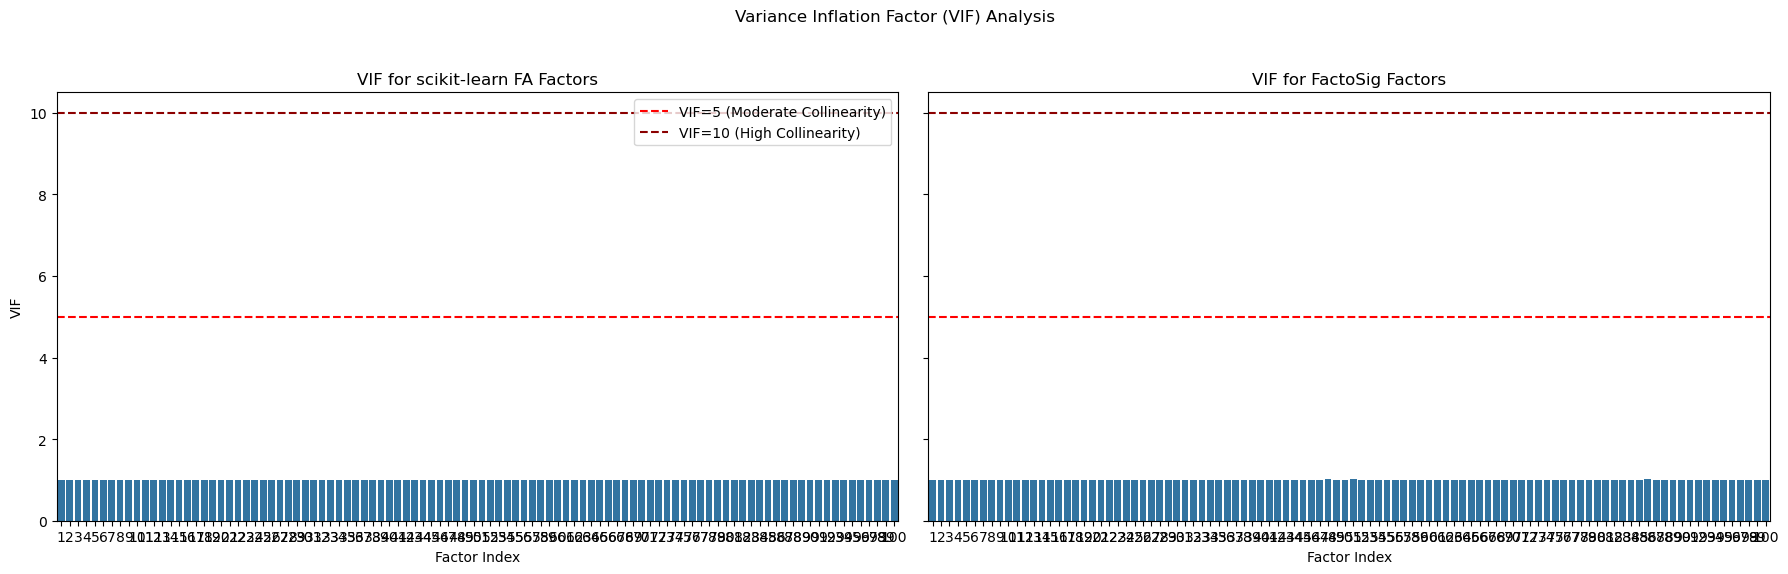

In [8]:
# Calculate Variance Inflation Factor (VIF)
def calculate_vif(Z):
    vif_data = pd.DataFrame()
    vif_data["feature"] = range(1, Z.shape[1] + 1)
    vif_data["VIF"] = [variance_inflation_factor(Z, i) for i in range(Z.shape[1])]
    return vif_data

print("Calculating VIF for scikit-learn FA factors...")
vif_fa = calculate_vif(Z_fa)

print("Calculating VIF for FactoSig factors...")
vif_fs = calculate_vif(Z_fs)

# Plot VIF
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.barplot(data=vif_fa, x='feature', y='VIF', ax=axes[0])
axes[0].set_title("VIF for scikit-learn FA Factors")
axes[0].set_xlabel("Factor Index")
axes[0].axhline(5, color='r', linestyle='--', label='VIF=5 (Moderate Collinearity)')
axes[0].axhline(10, color='darkred', linestyle='--', label='VIF=10 (High Collinearity)')
axes[0].legend()


sns.barplot(data=vif_fs, x='feature', y='VIF', ax=axes[1])
axes[1].set_title("VIF for FactoSig Factors")
axes[1].set_xlabel("Factor Index")
axes[1].axhline(5, color='r', linestyle='--')
axes[1].axhline(10, color='darkred', linestyle='--')


plt.suptitle("Variance Inflation Factor (VIF) Analysis")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Oct 28

In [9]:
# 3.x Verify diagonals and off-diagonal magnitudes
def _diag_report(name: str, M: pd.DataFrame) -> None:
    diag_vals = np.diag(M.values)
    M_no_diag = M.copy()
    np.fill_diagonal(M_no_diag.values, np.nan)
    off_vals = M_no_diag.values
    print(f"{name}: diag min/mean/max = {np.nanmin(diag_vals):.6f} / {np.nanmean(diag_vals):.6f} / {np.nanmax(diag_vals):.6f}")
    print(f"{name}: off-diagonal min/max = {np.nanmin(off_vals):.6f} / {np.nanmax(off_vals):.6f}")
    print(f"{name}: max |off| = {np.nanmax(np.abs(off_vals)):.6f}\n")

print("[Check] Diagonal and off-diagonal ranges:")
_diag_report("FA Pearson", corr_fa)
_diag_report("FA Cosine", cossim_fa)
_diag_report("FS Pearson", corr_fs)
_diag_report("FS Cosine", cossim_fs)


[Check] Diagonal and off-diagonal ranges:
FA Pearson: diag min/mean/max = 1.000000 / 1.000000 / 1.000000
FA Pearson: off-diagonal min/max = -0.011714 / 0.010816
FA Pearson: max |off| = 0.011714

FA Cosine: diag min/mean/max = 0.999999 / 1.000008 / 1.000016
FA Cosine: off-diagonal min/max = -0.011714 / 0.010816
FA Cosine: max |off| = 0.011714

FS Pearson: diag min/mean/max = 1.000000 / 1.000000 / 1.000000
FS Pearson: off-diagonal min/max = -0.058913 / 0.051096
FS Pearson: max |off| = 0.058913

FS Cosine: diag min/mean/max = 1.000000 / 1.000013 / 1.000042
FS Cosine: off-diagonal min/max = -0.058913 / 0.051097
FS Cosine: max |off| = 0.058913



In [10]:
Z_fa.shape, len(y)

((60118, 100), 60118)

In [11]:
z_plus_y = np.column_stack([Z_fa, y])
z_plus_y.shape


(60118, 101)

scikit-learn FA: Pearson Correlation of Factors (+ CN.label) – zoom range: [-0.446, 0.154]


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


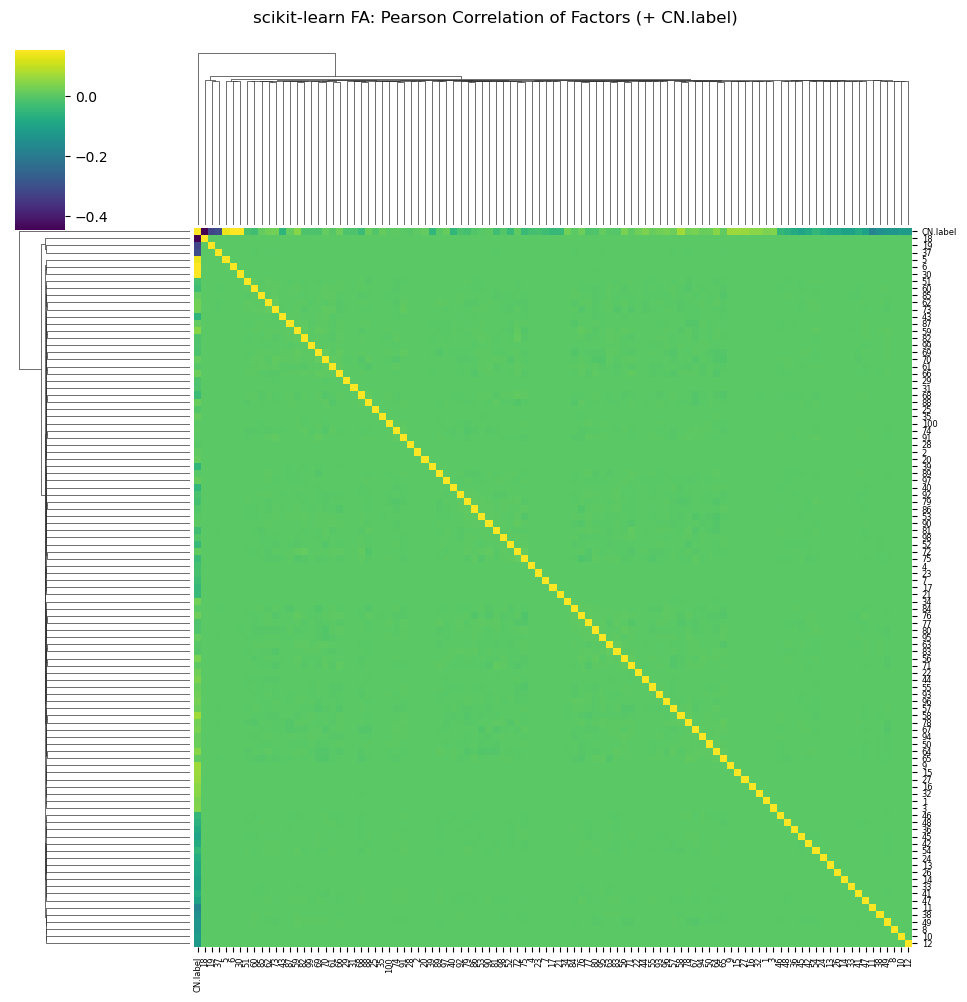

scikit-learn FA: Cosine Similarity of Factors (+ CN.label) – zoom range: [-0.072, 0.025]


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


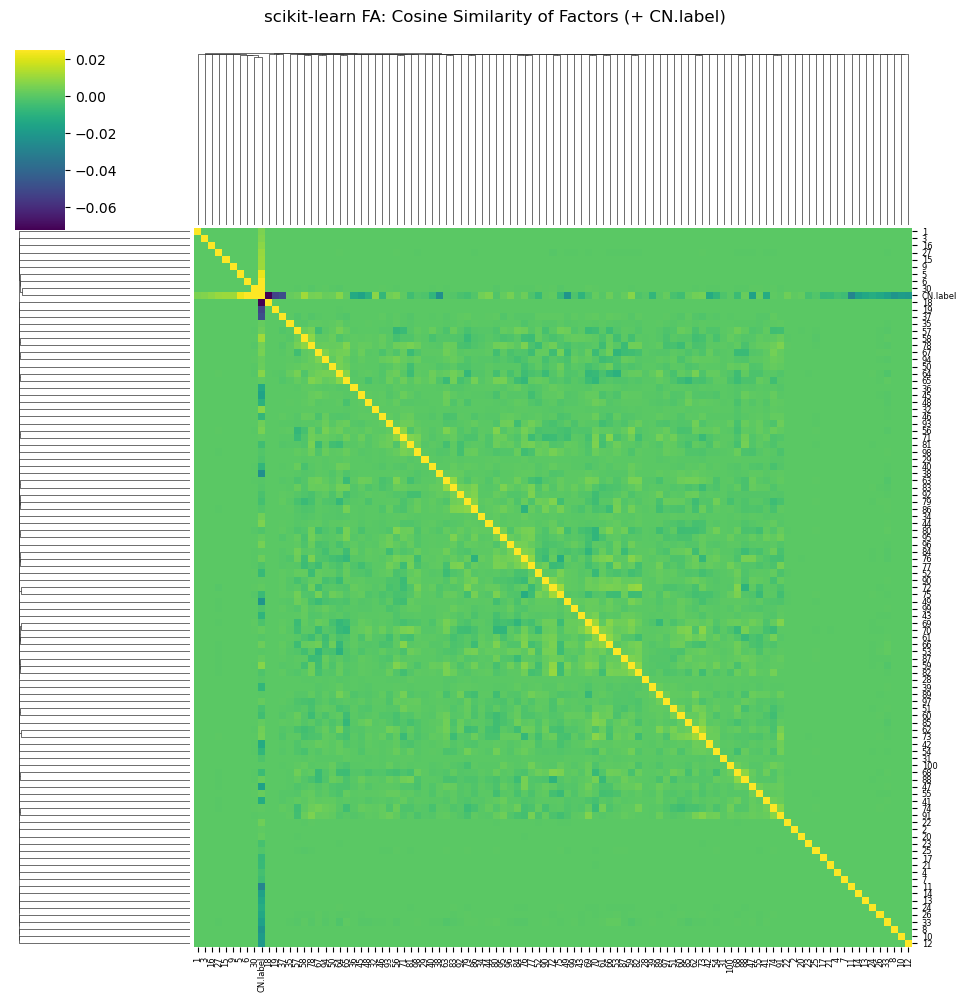

FactoSig: Pearson Correlation of Factors (+ CN.label) – zoom range: [-0.670, 0.126]


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


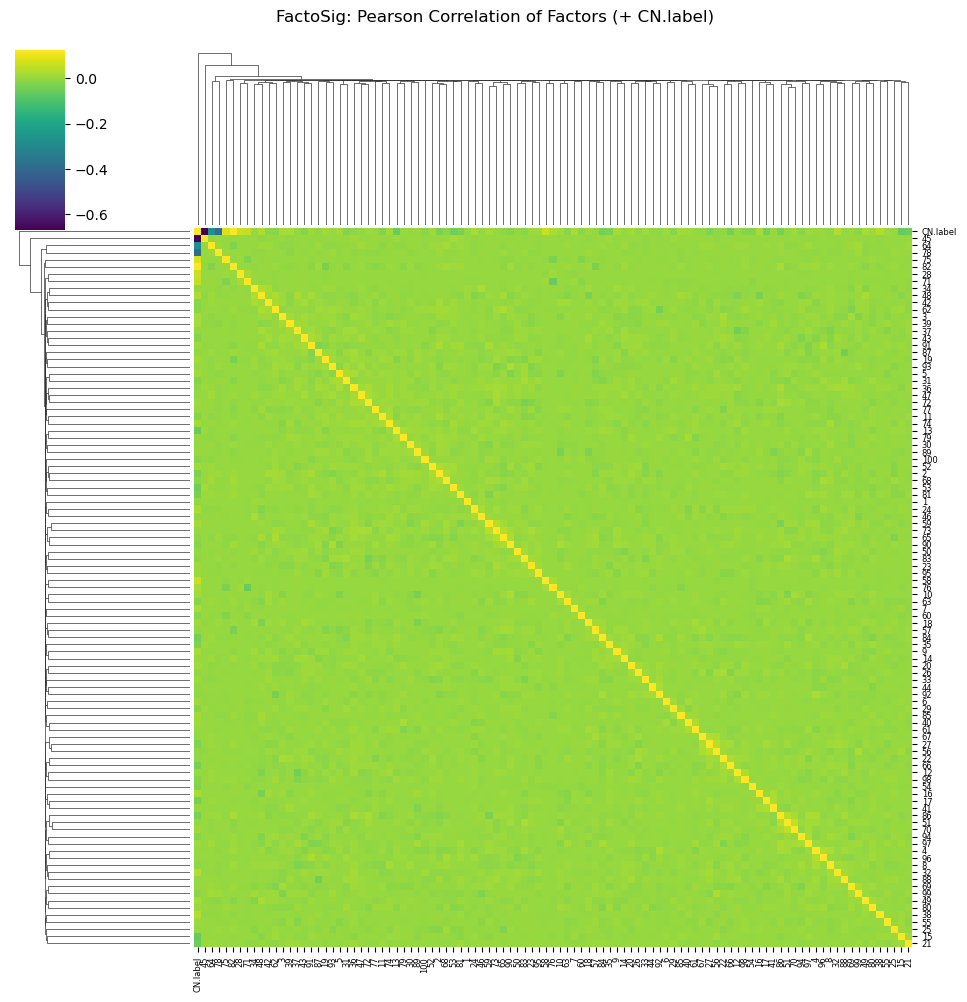

FactoSig: Cosine Similarity of Factors (+ CN.label) – zoom range: [-0.108, 0.051]


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


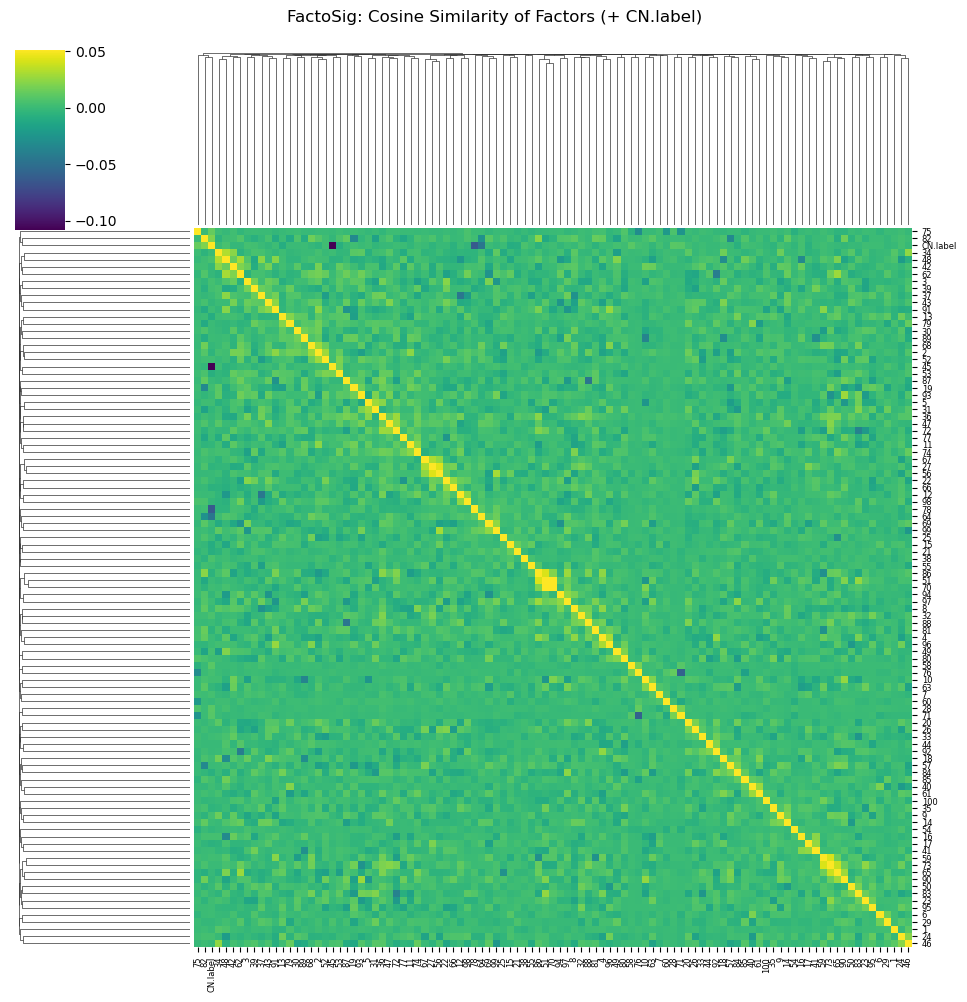

In [12]:
# 3.x Clustermaps with CN.label appended as an extra row/column
def clustermap_with_target(Z: np.ndarray, y_numeric: np.ndarray, method_name: str,
                           metric: str = "corr", target_name: str = "CN.label",
                           figsize=(10, 10)):
    assert metric in {"corr", "cosine"}
    # Build matrix with the target appended as the last column
    Z_plus_y = np.column_stack([Z, y_numeric.astype(float)])
    cols = [*(map(str, range(1, Z.shape[1] + 1))), target_name]
    if metric == "corr":
        M = pd.DataFrame(Z_plus_y, columns=cols).corr()
        title = f"{method_name}: Pearson Correlation of Factors (+ {target_name})"
    else:
        M = pd.DataFrame(cosine_similarity(Z_plus_y.T), index=cols, columns=cols)
        title = f"{method_name}: Cosine Similarity of Factors (+ {target_name})"

    # Zoom color scale to off-diagonal range
    M_no_diag = M.copy()
    np.fill_diagonal(M_no_diag.values, np.nan)
    vmin = np.nanmin(M_no_diag.values)
    vmax = np.nanmax(M_no_diag.values)
    print(f"{title} – zoom range: [{vmin:.3f}, {vmax:.3f}]")

    g = sns.clustermap(M, cmap="viridis", vmin=vmin, vmax=vmax, figsize=figsize, xticklabels=True, yticklabels=True)
    plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=6, rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=6)
    plt.suptitle(title, y=1.02)
    plt.show()

# Run for both methods and both metrics
clustermap_with_target(Z_fa, y, "scikit-learn FA", metric="corr")
clustermap_with_target(Z_fa, y, "scikit-learn FA", metric="cosine")
clustermap_with_target(Z_fs, y, "FactoSig", metric="corr")
clustermap_with_target(Z_fs, y, "FactoSig", metric="cosine")


In [13]:
from typing import Dict
from sklearn.preprocessing import LabelEncoder

def _sanitize_matrix(M: pd.DataFrame) -> pd.DataFrame:
    M = M.copy()
    A = M.values
    A[~np.isfinite(A)] = 0.0     # handle NaN/inf
    np.fill_diagonal(A, 1.0)     # keep diag at 1
    np.clip(A, -1.0, 1.0, out=A) # safety
    return M

def compute_patient_mats_with_label(
    Z: np.ndarray,
    patient_series: pd.Series,
    label_series: pd.Series,
    target_name: str = "CN.label",
) -> Dict[str, dict]:
    """
    Return {patient_id: {"corr": DataFrame, "cosine": DataFrame}} with CN.label appended.
    Rows of Z must align with both series.
    """
    assert Z.shape[0] == len(patient_series) == len(label_series), "Row alignment mismatch"
    mats: Dict[str, dict] = {}
    vals = patient_series.to_numpy()
    y_all = LabelEncoder().fit_transform(label_series.to_numpy())
    for pid in pd.unique(vals):
        idx = np.flatnonzero(vals == pid)
        if idx.size < 3:  # skip tiny groups
            continue
        Zp = Z[idx, :]
        yp = y_all[idx].astype(float)
        Z_plus_y = np.column_stack([Zp, yp])
        cols = [*(map(str, range(1, Zp.shape[1] + 1))), target_name]
        # Pearson corr and cosine over columns (k+1)
        corr = pd.DataFrame(Z_plus_y, columns=cols).corr()
        corr = _sanitize_matrix(corr)
        coss = pd.DataFrame(cosine_similarity(Z_plus_y.T), index=cols, columns=cols)
        coss = _sanitize_matrix(coss)
        mats[str(pid)] = {"corr": corr, "cosine": coss}
    return mats

def plot_patient_mats_big(mats: Dict[str, dict], pid: str, method_name: str, figsize=(13, 13)):
    corr = mats[pid]["corr"]
    coss = mats[pid]["cosine"]

    def _vlims(M: pd.DataFrame):
        Mnd = M.copy()
        np.fill_diagonal(Mnd.values, np.nan)
        return np.nanmin(Mnd.values), np.nanmax(Mnd.values)

    vmin_c, vmax_c = _vlims(corr)
    g = sns.clustermap(corr, cmap="viridis", vmin=vmin_c, vmax=vmax_c, figsize=figsize,
                       xticklabels=True, yticklabels=True)
    plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=7, rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=7)
    plt.suptitle(f"{method_name} – Patient {pid}: Pearson corr (+ CN.label)", y=1.02)
    plt.show()

    vmin_s, vmax_s = _vlims(coss)
    g = sns.clustermap(coss, cmap="viridis", vmin=vmin_s, vmax=vmax_s, figsize=figsize,
                       xticklabels=True, yticklabels=True)
    plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=7, rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=7)
    plt.suptitle(f"{method_name} – Patient {pid}: Cosine similarity (+ CN.label)", y=1.02)
    plt.show()

# Usage
patient_series = adata_fa.obs["patient"]
label_series = adata_fa.obs["CN.label"]
fa_patient_mats = compute_patient_mats_with_label(Z_fa, patient_series, label_series)
fs_patient_mats = compute_patient_mats_with_label(Z_fs, patient_series, label_series)



In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score

factor_name = "factor_45"
j = int(factor_name.split("_")[1]) - 1  # 0-based index

mask = (adata_fs.obs["patient"] == "P03").to_numpy()
y_p = (adata_fs.obs["CN.label"].to_numpy()[mask] == "cancer").astype(int)
z_p = Z_fs[mask, j]

auc = roc_auc_score(y_p, z_p)
r_pb = np.corrcoef(z_p, y_p)[0, 1]  # point-biserial = Pearson with 0/1
r_rb = 2 * auc - 1                  # rank-biserial (AUC-compatible)

print({"factor_index": j + 1, "AUC": auc, "point_biserial_r": r_pb, "rank_biserial_r": r_rb, "malignant_rate": y_p.mean()})

{'factor_index': 45, 'AUC': 0.9998688306250221, 'point_biserial_r': 0.9408303582014207, 'rank_biserial_r': 0.9997376612500442, 'malignant_rate': 0.32574129780833694}


P01


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


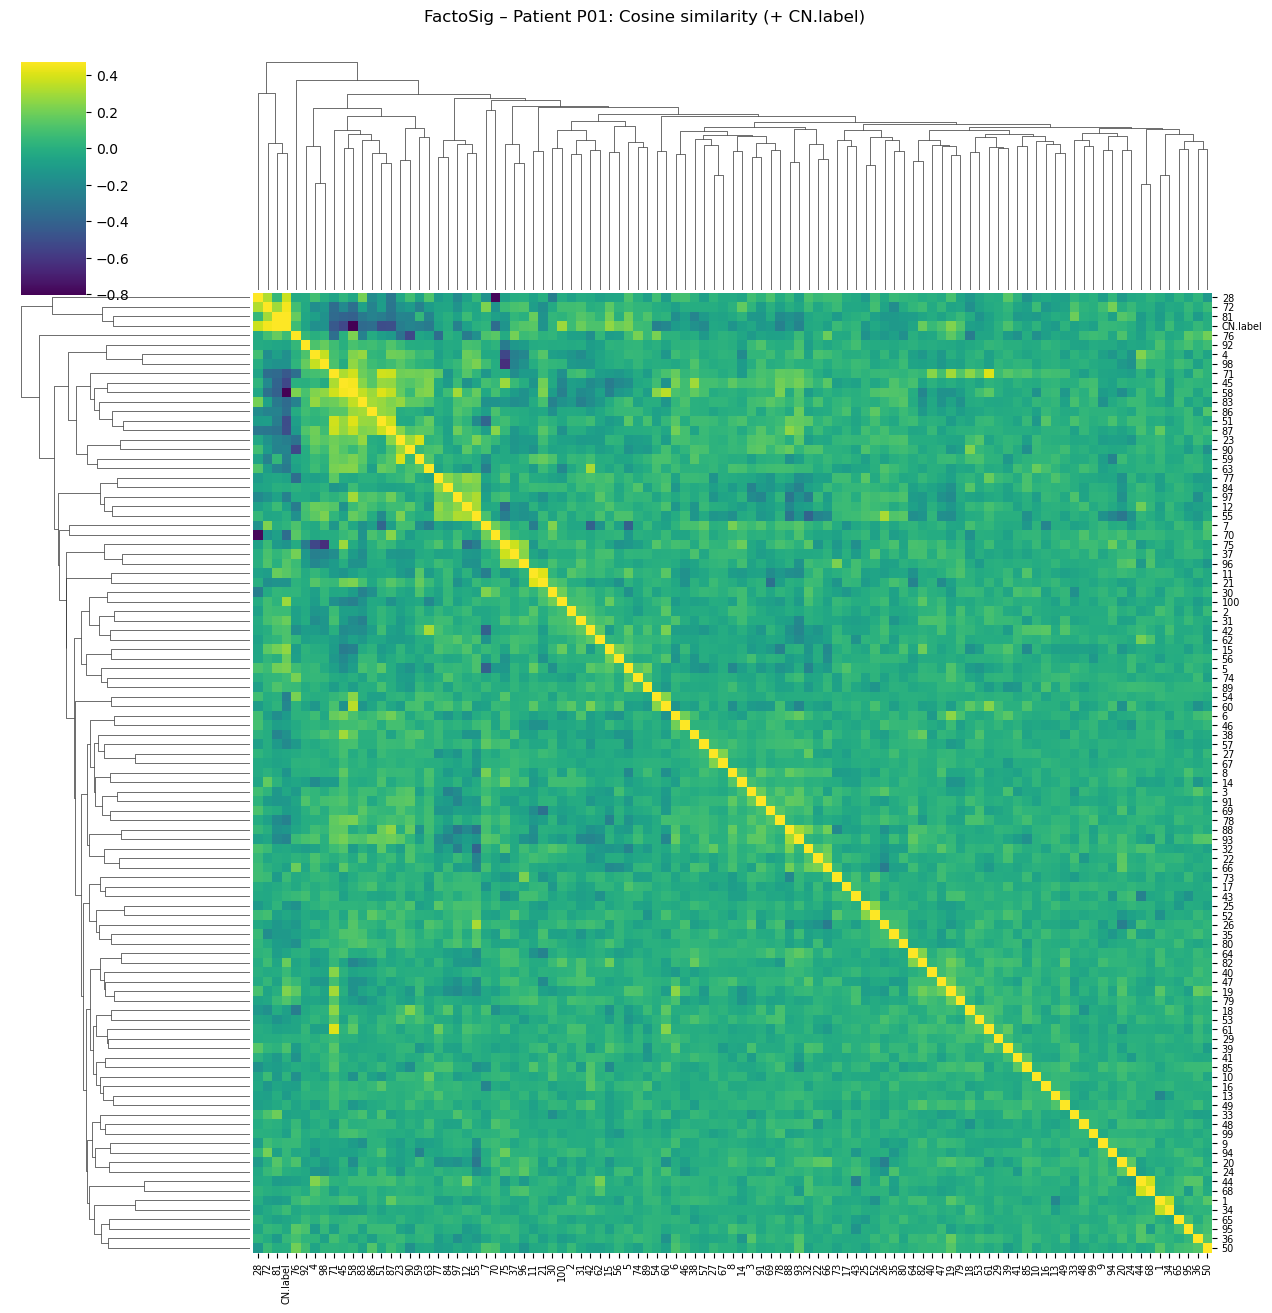

P03


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


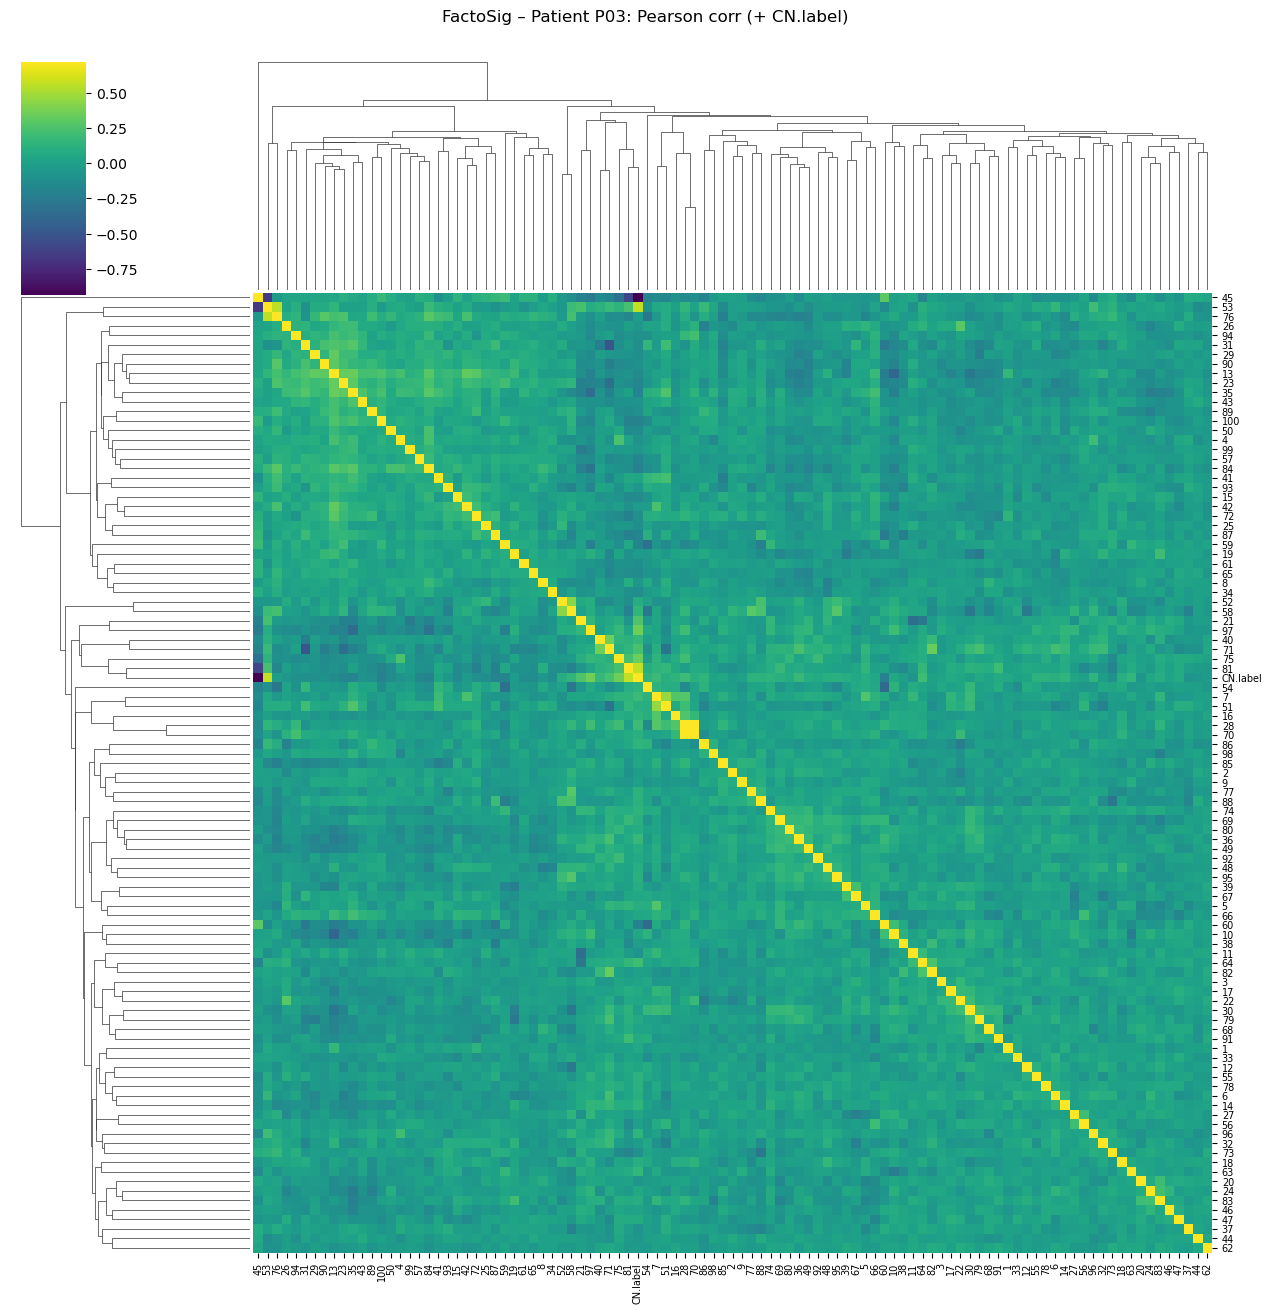

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


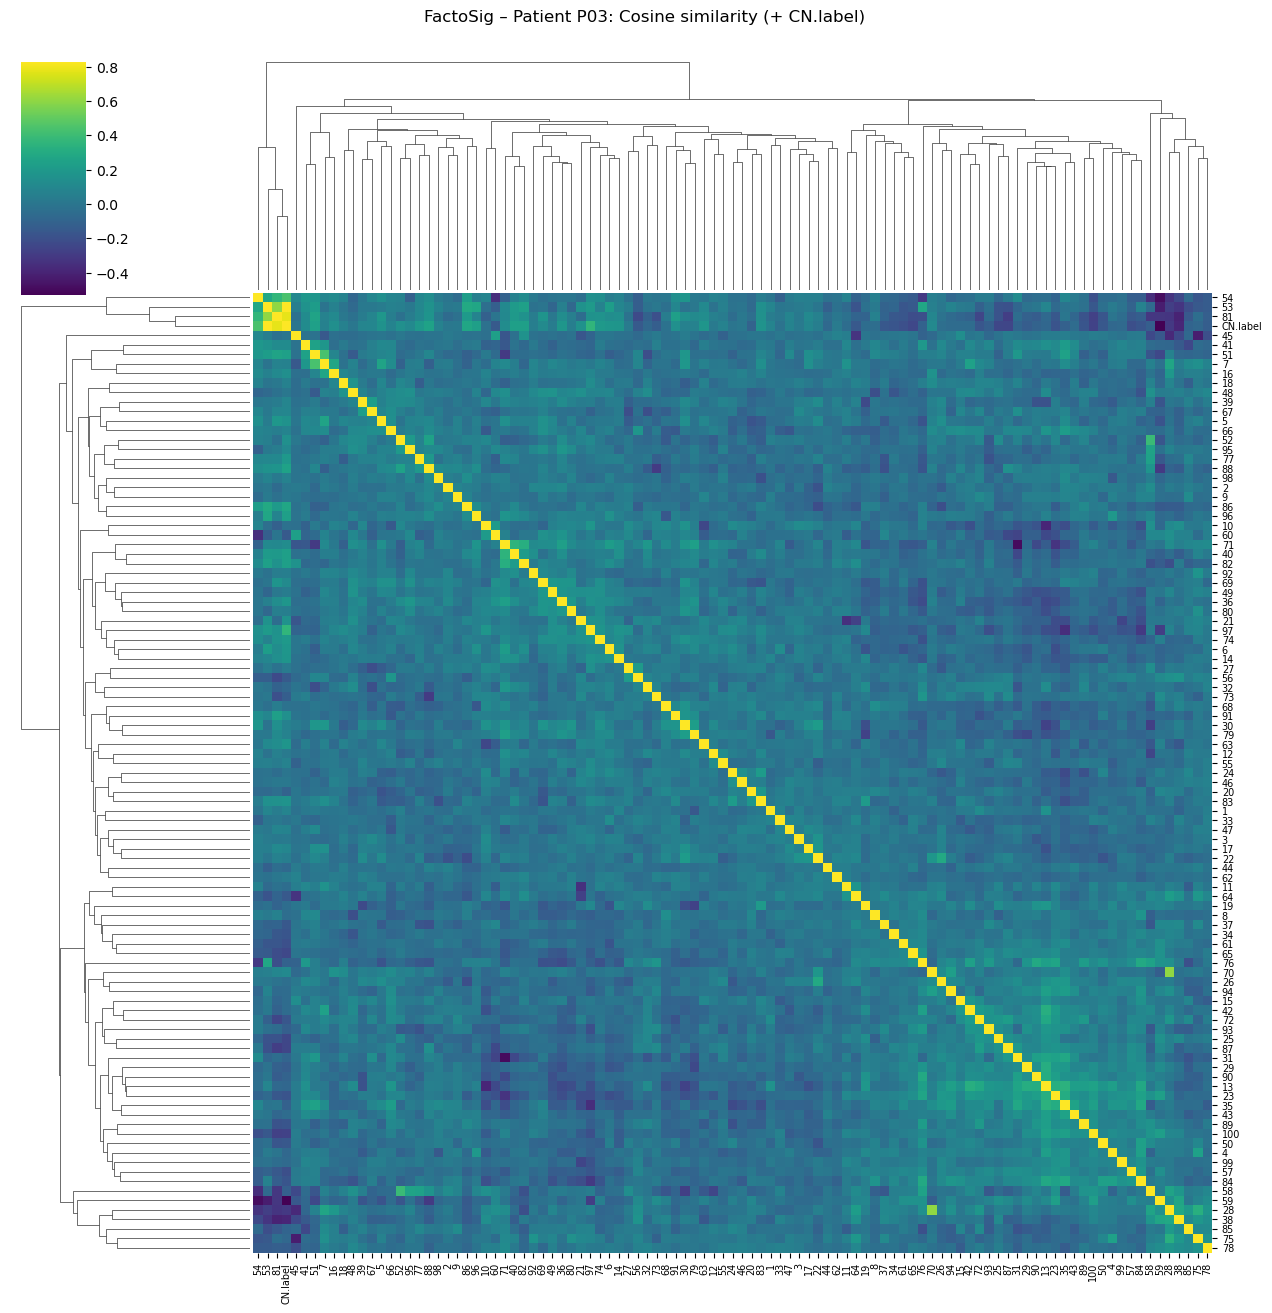

P02


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


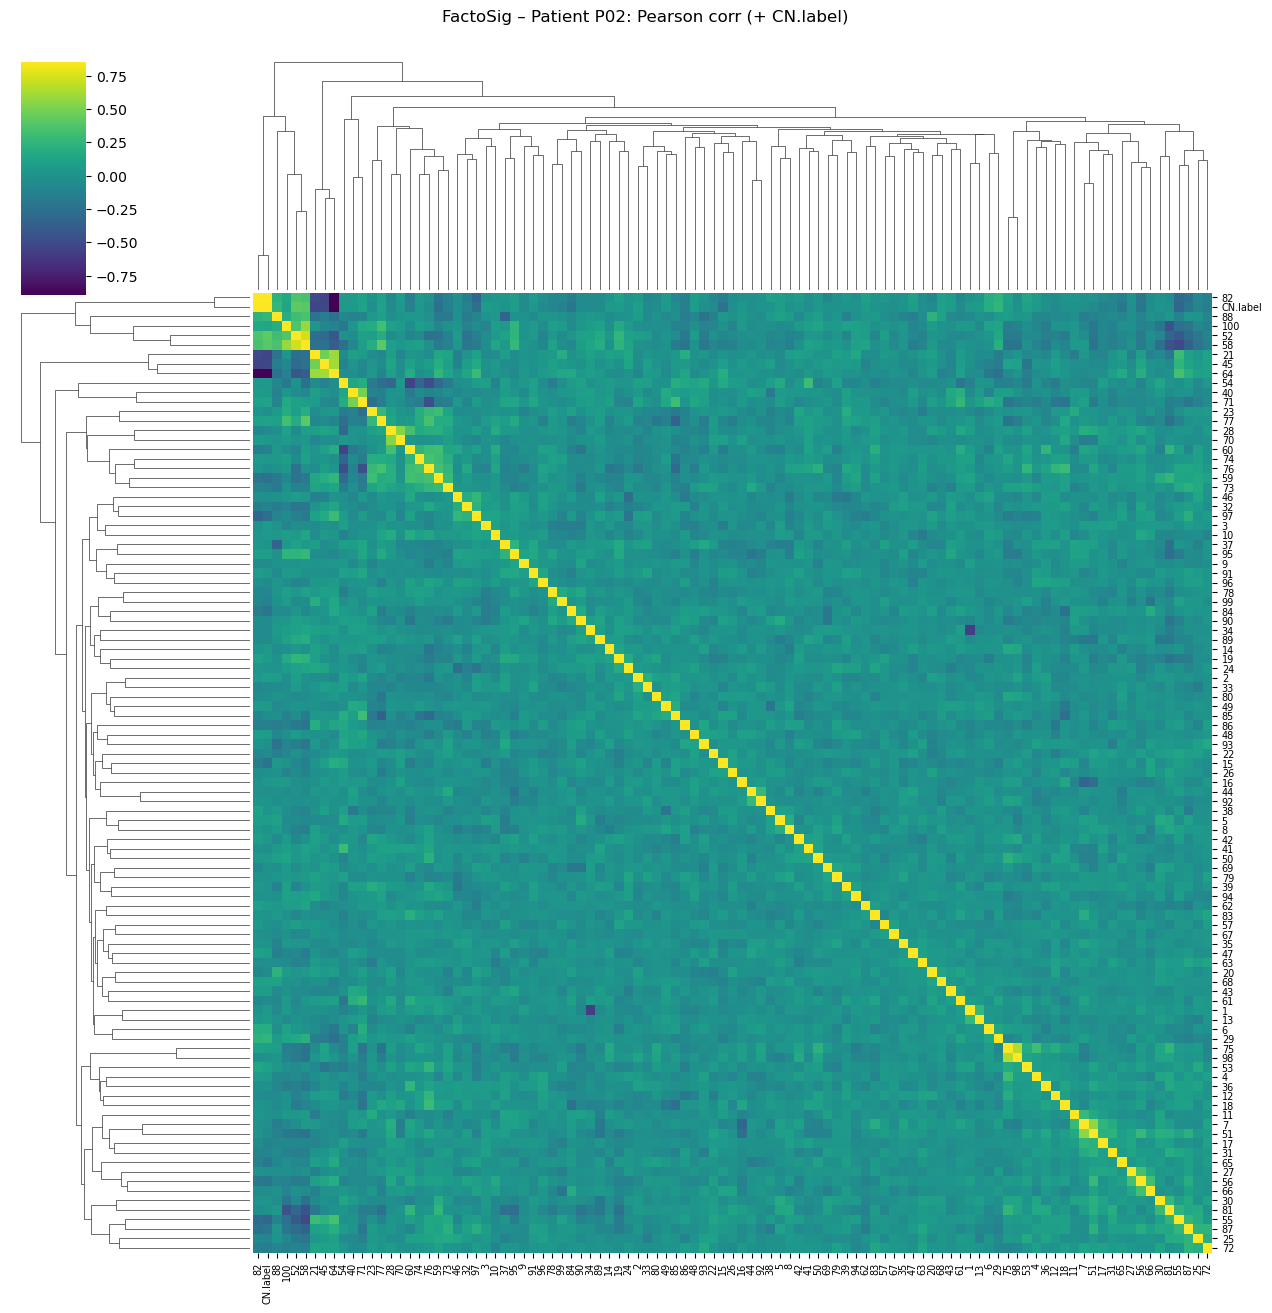

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


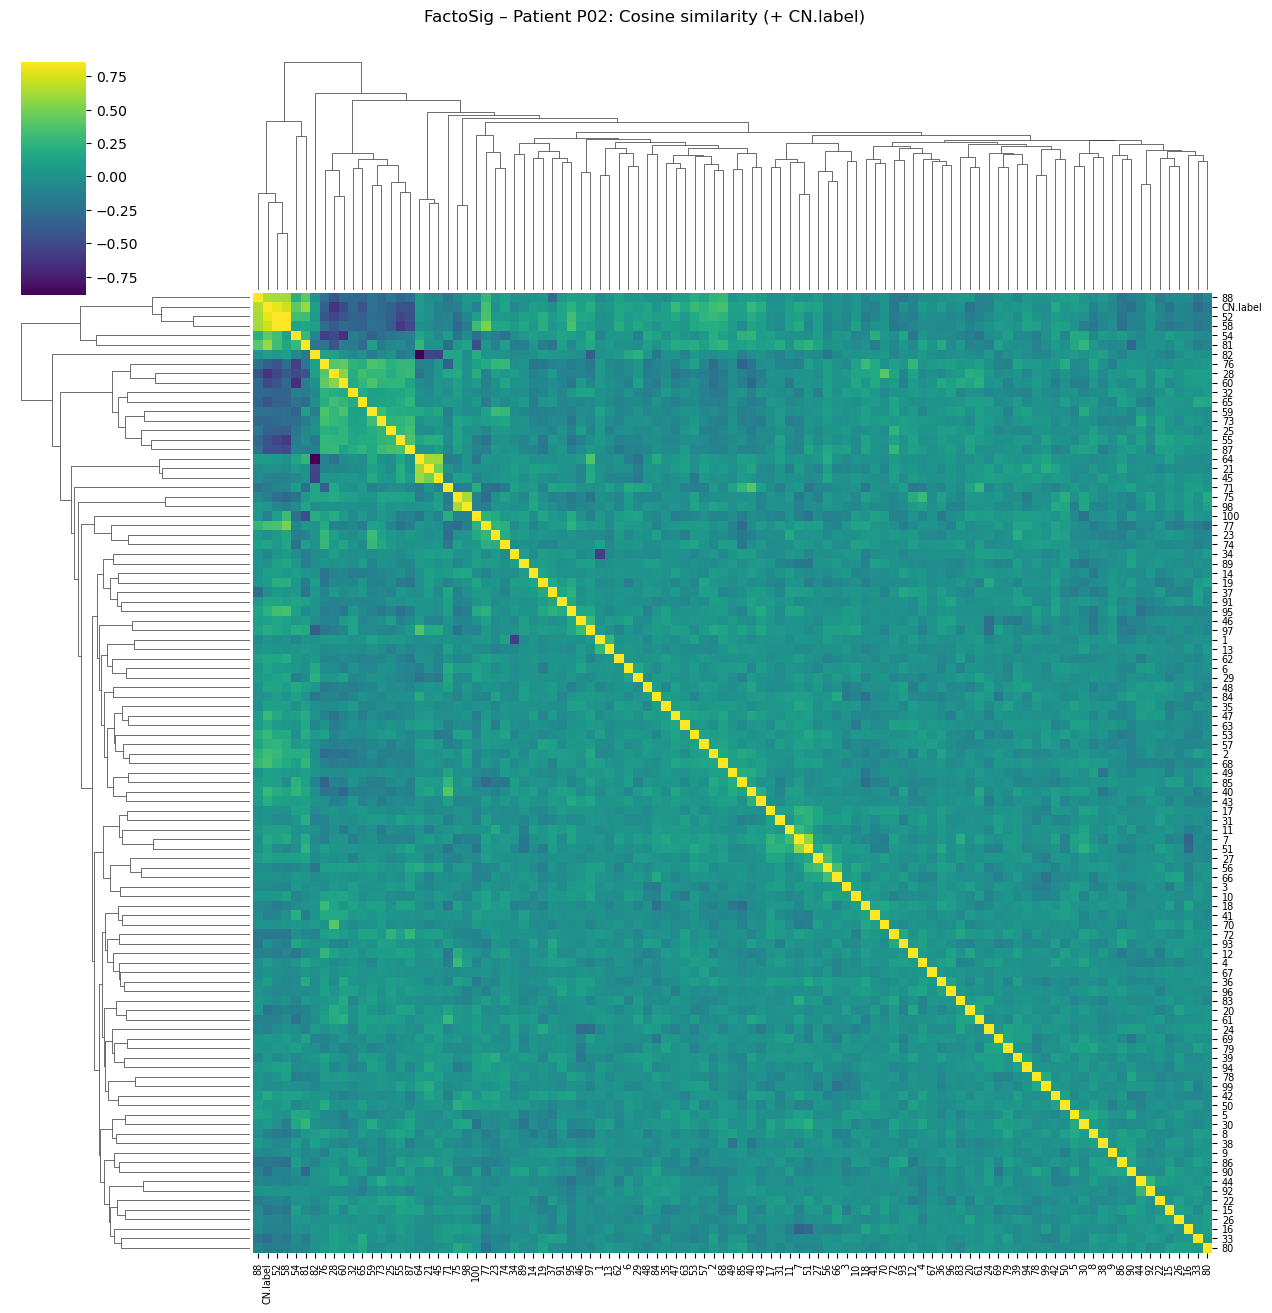

P05


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


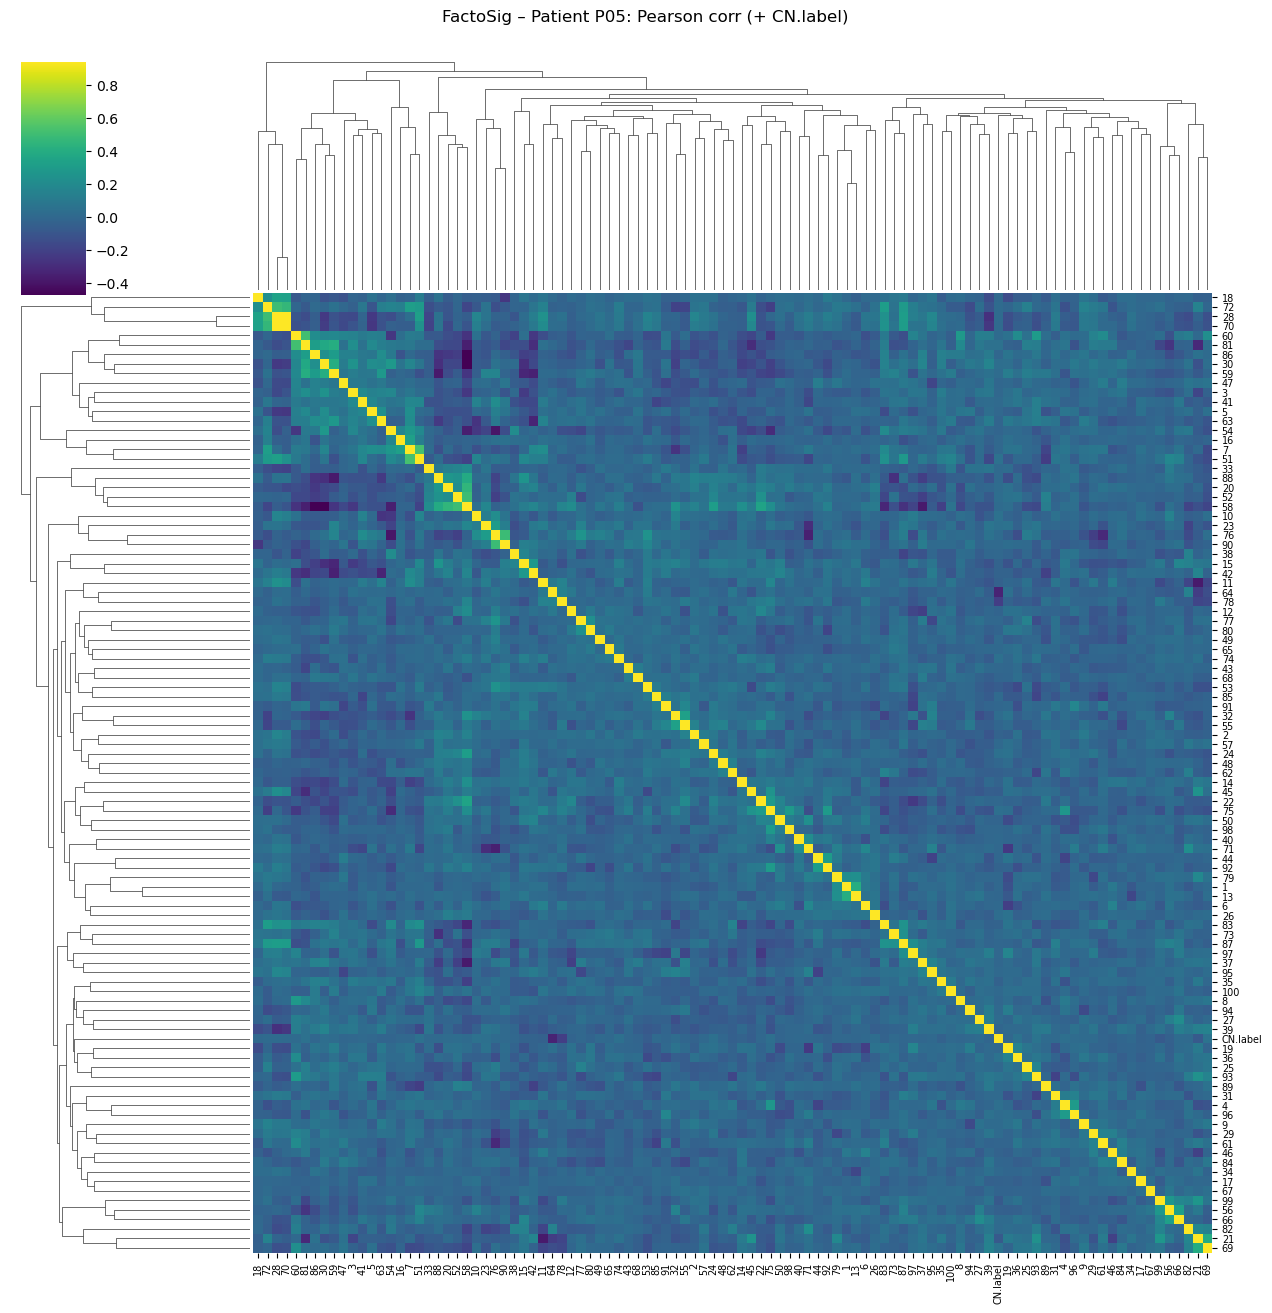

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


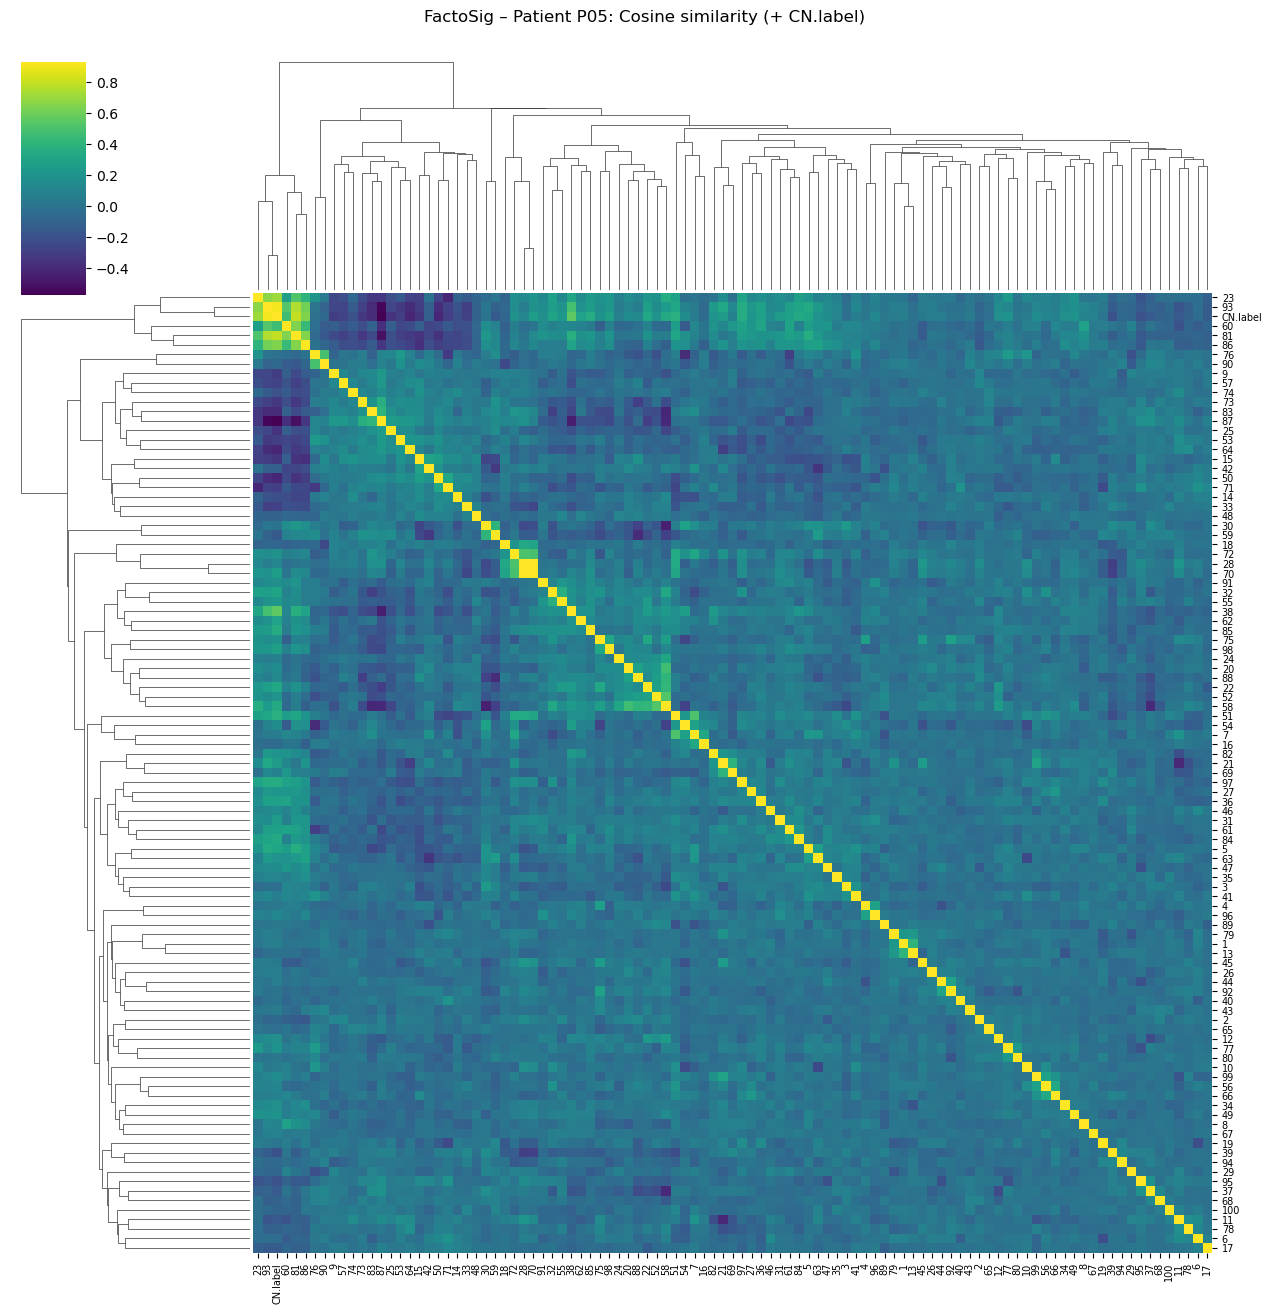

P04


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


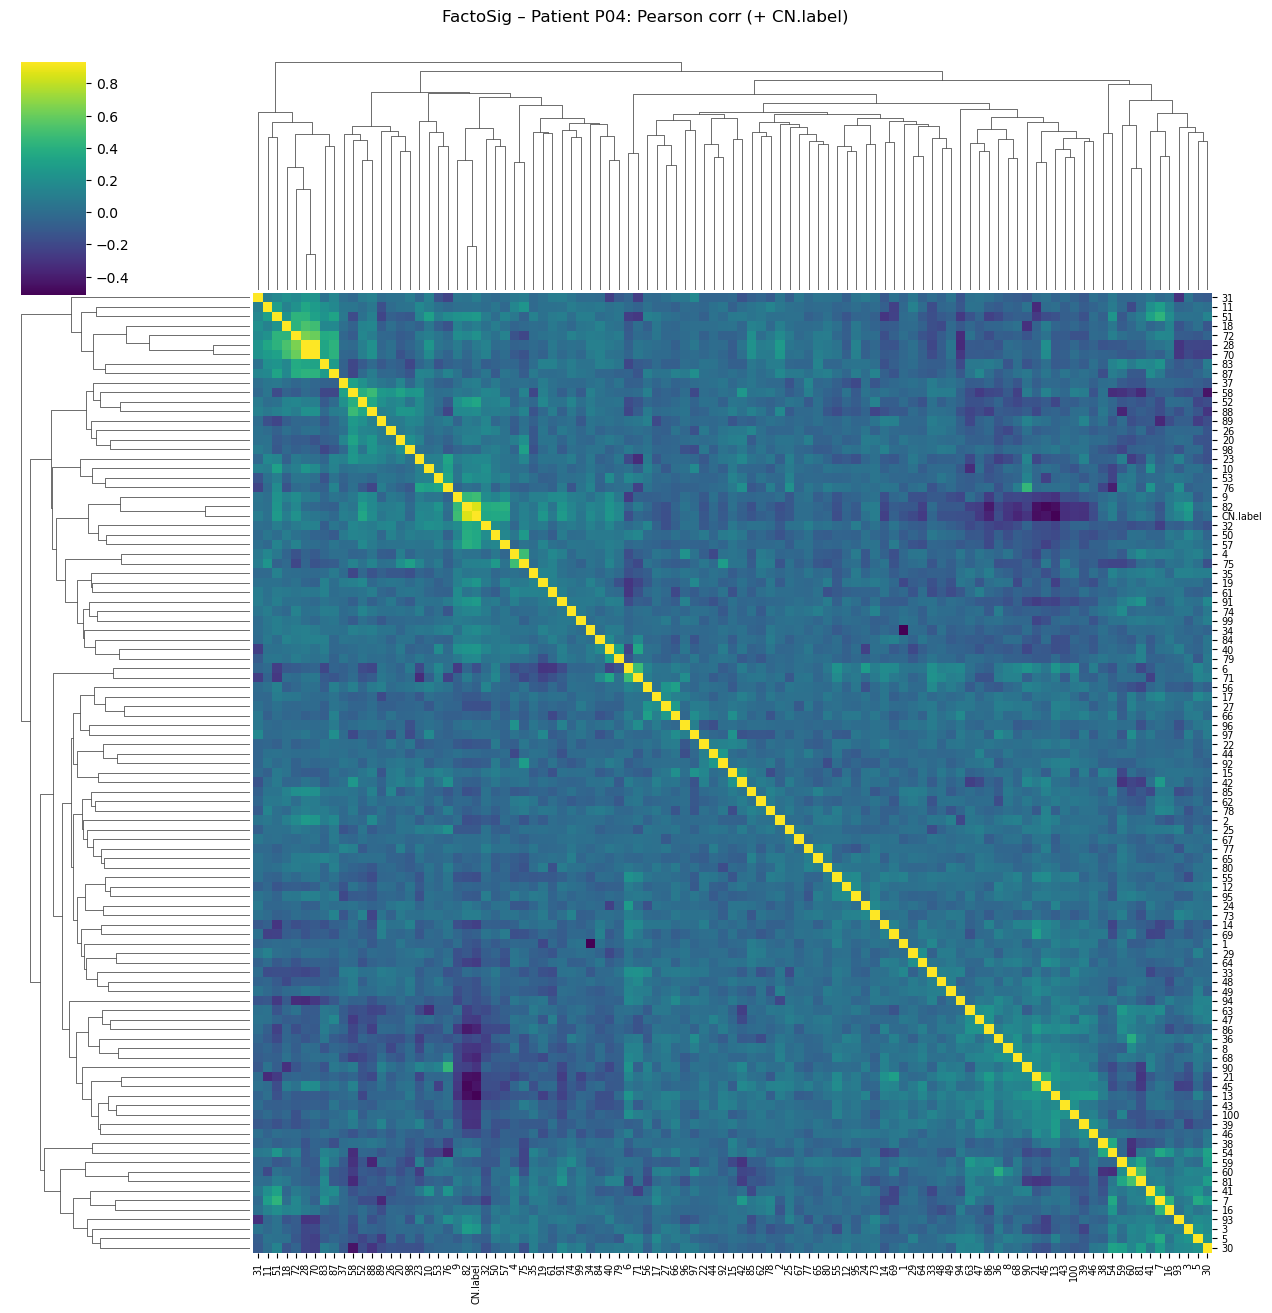

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


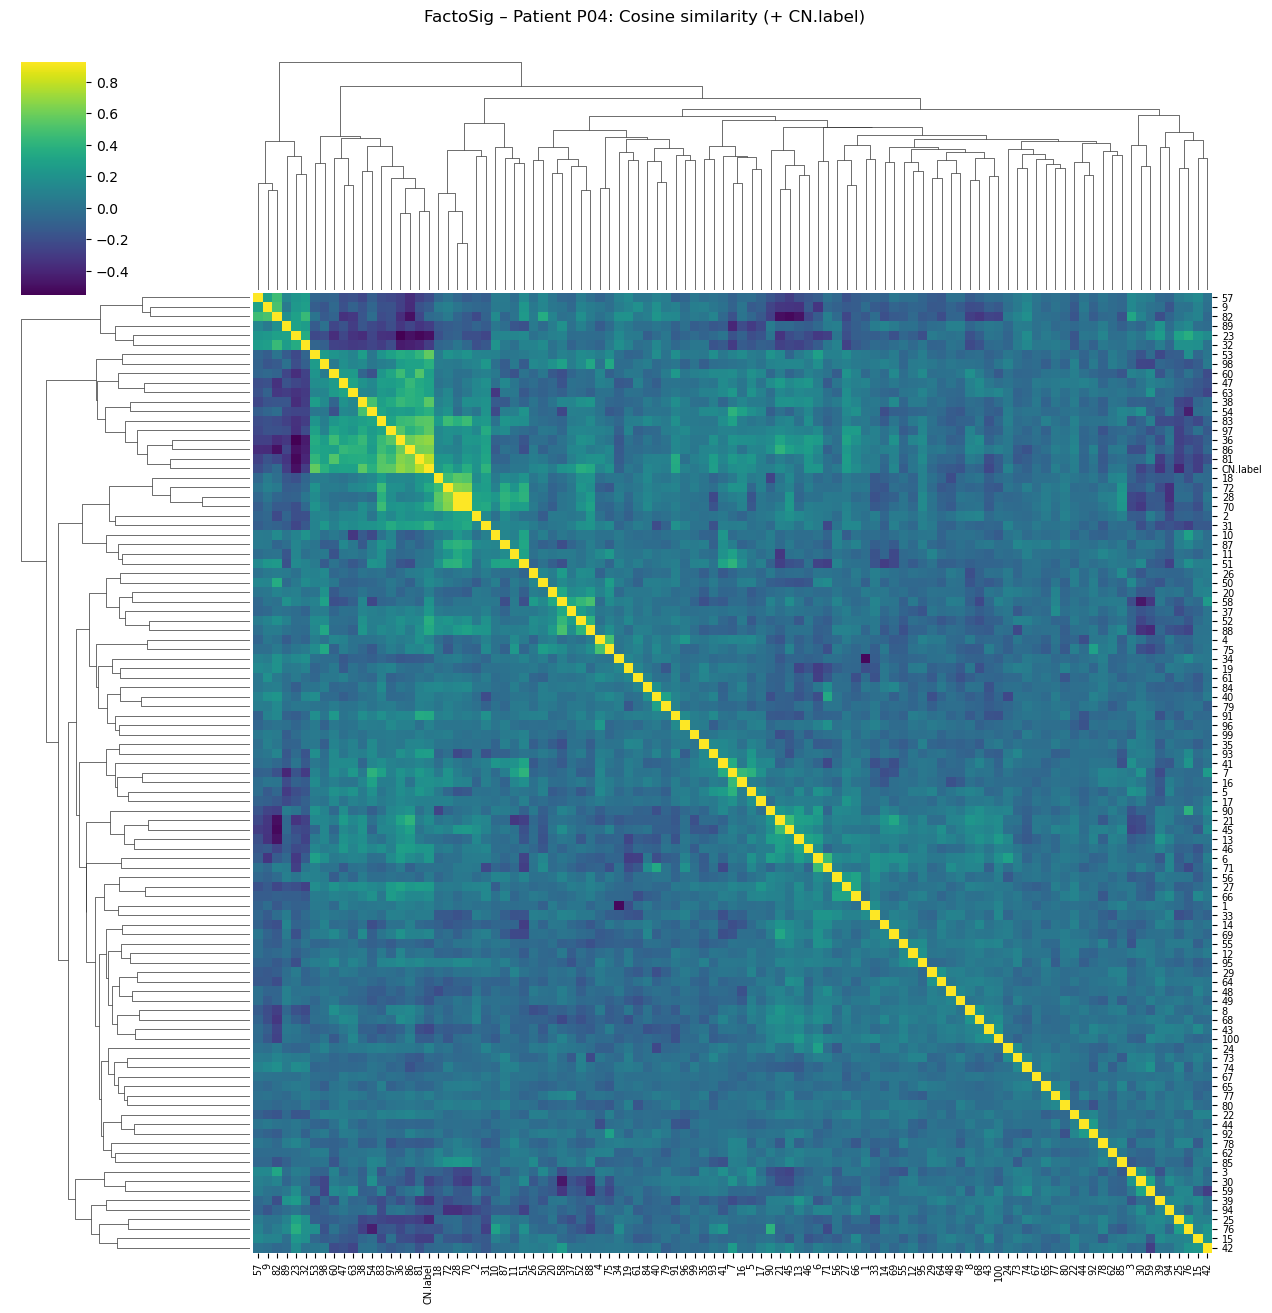

P06


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


P11


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


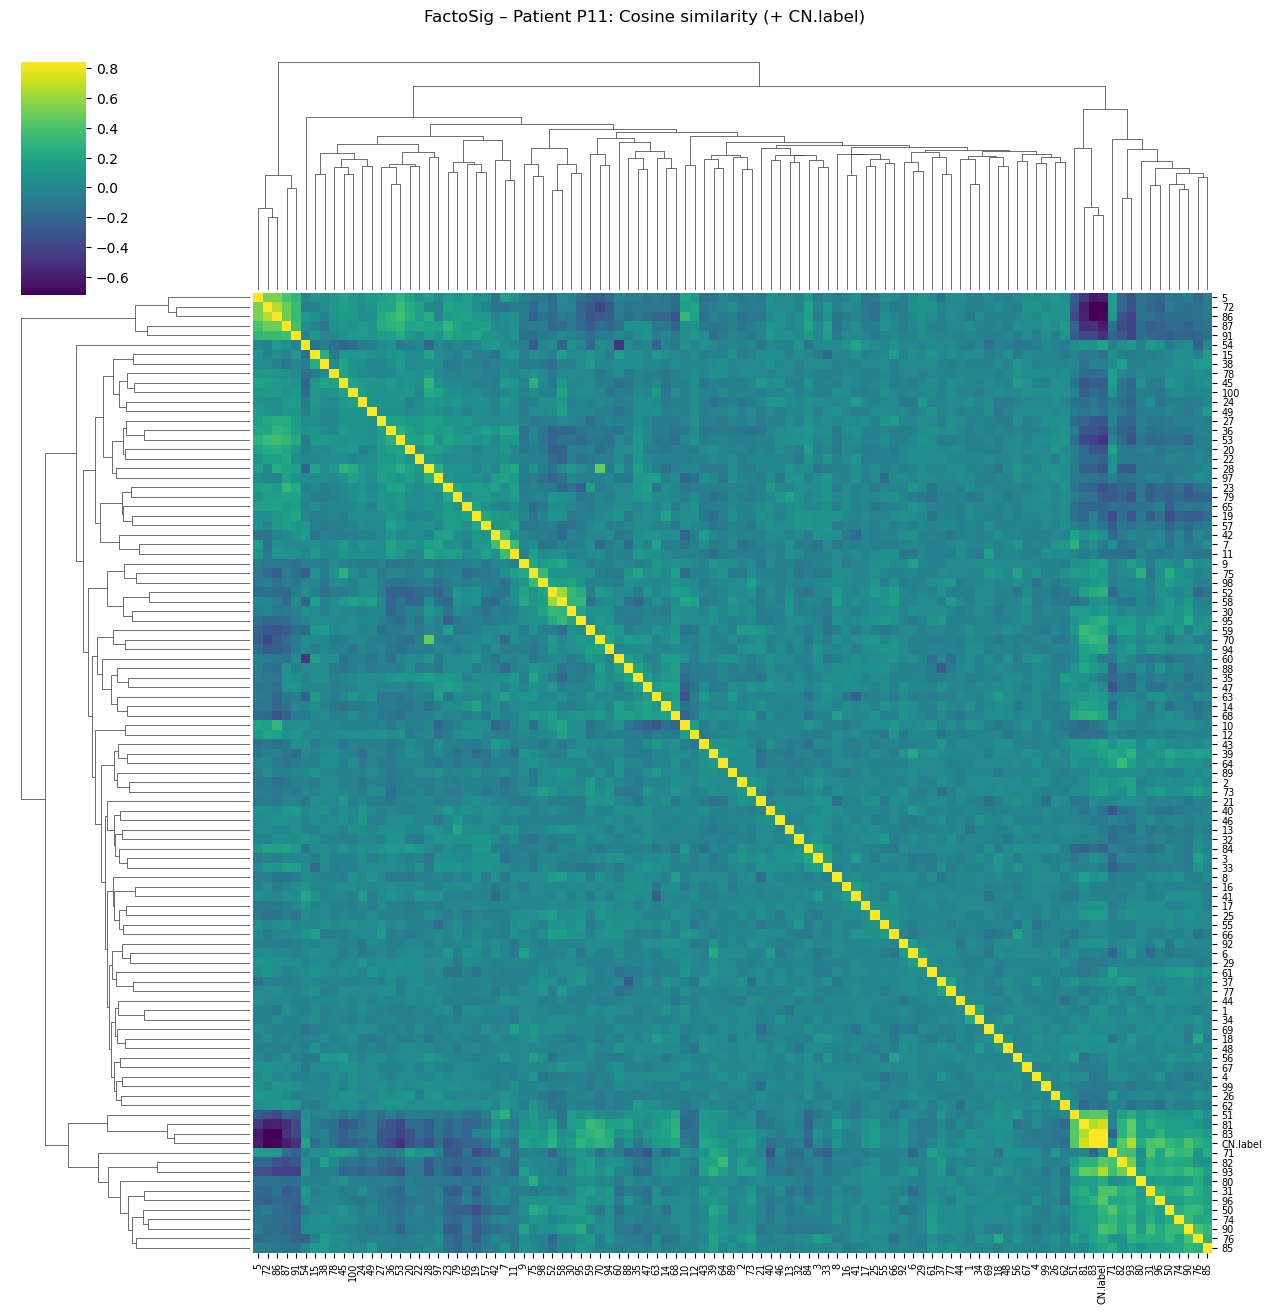

P07


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


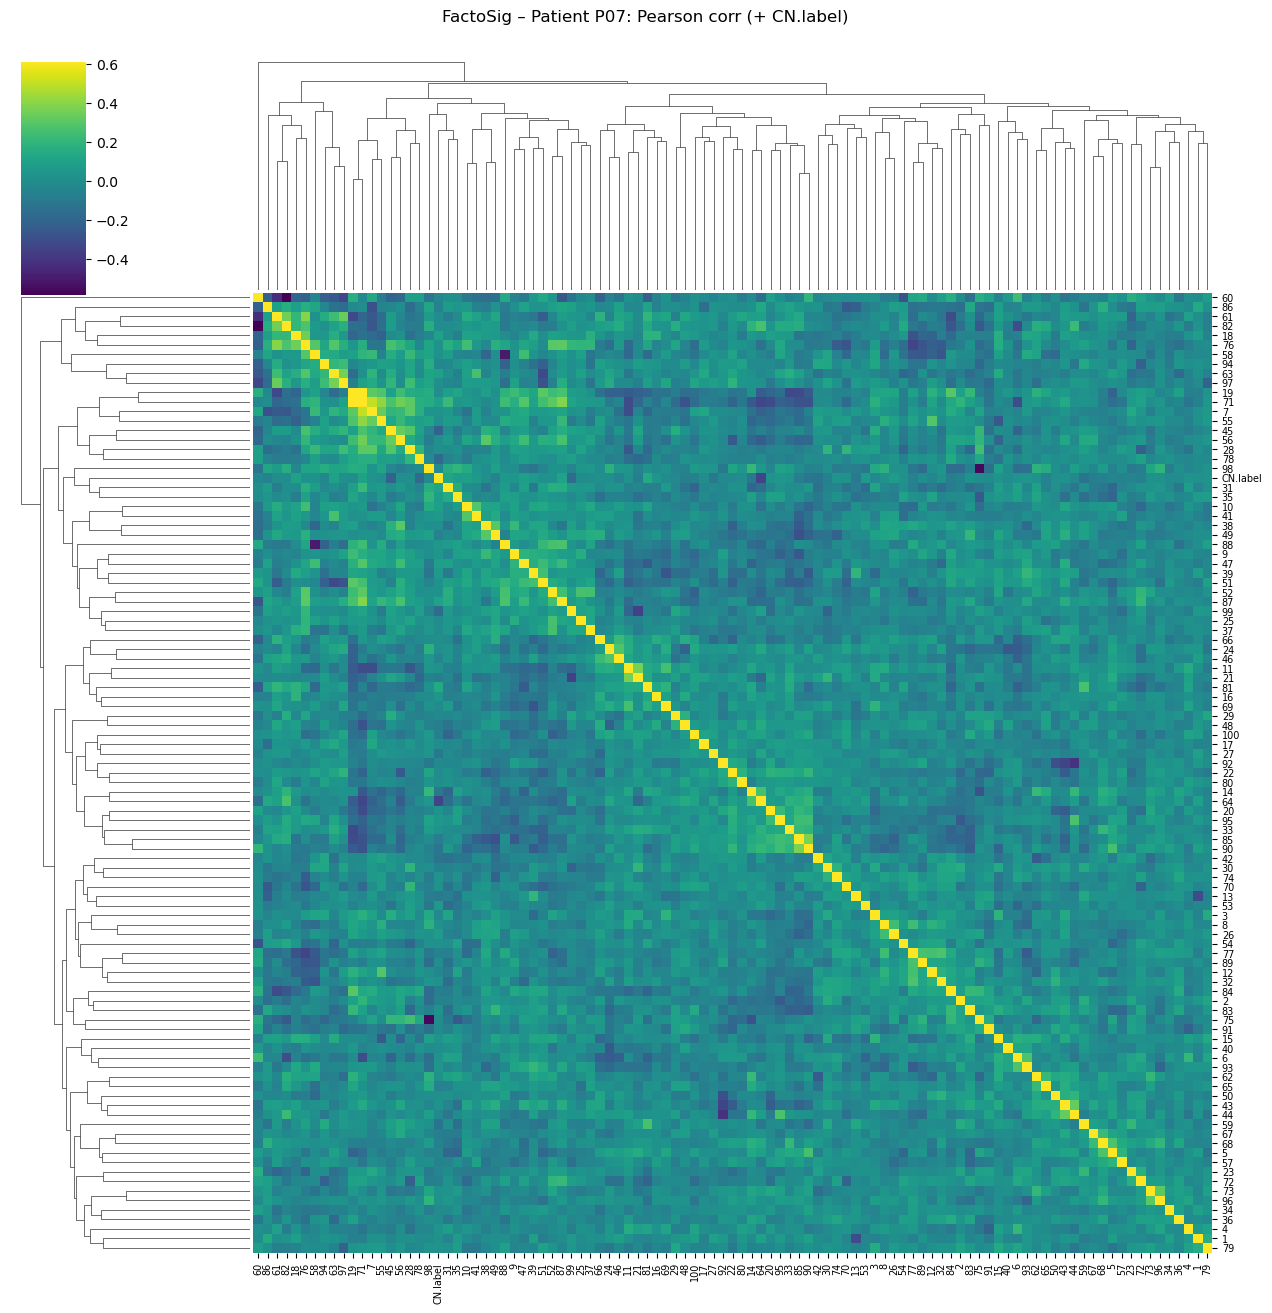

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


P10


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


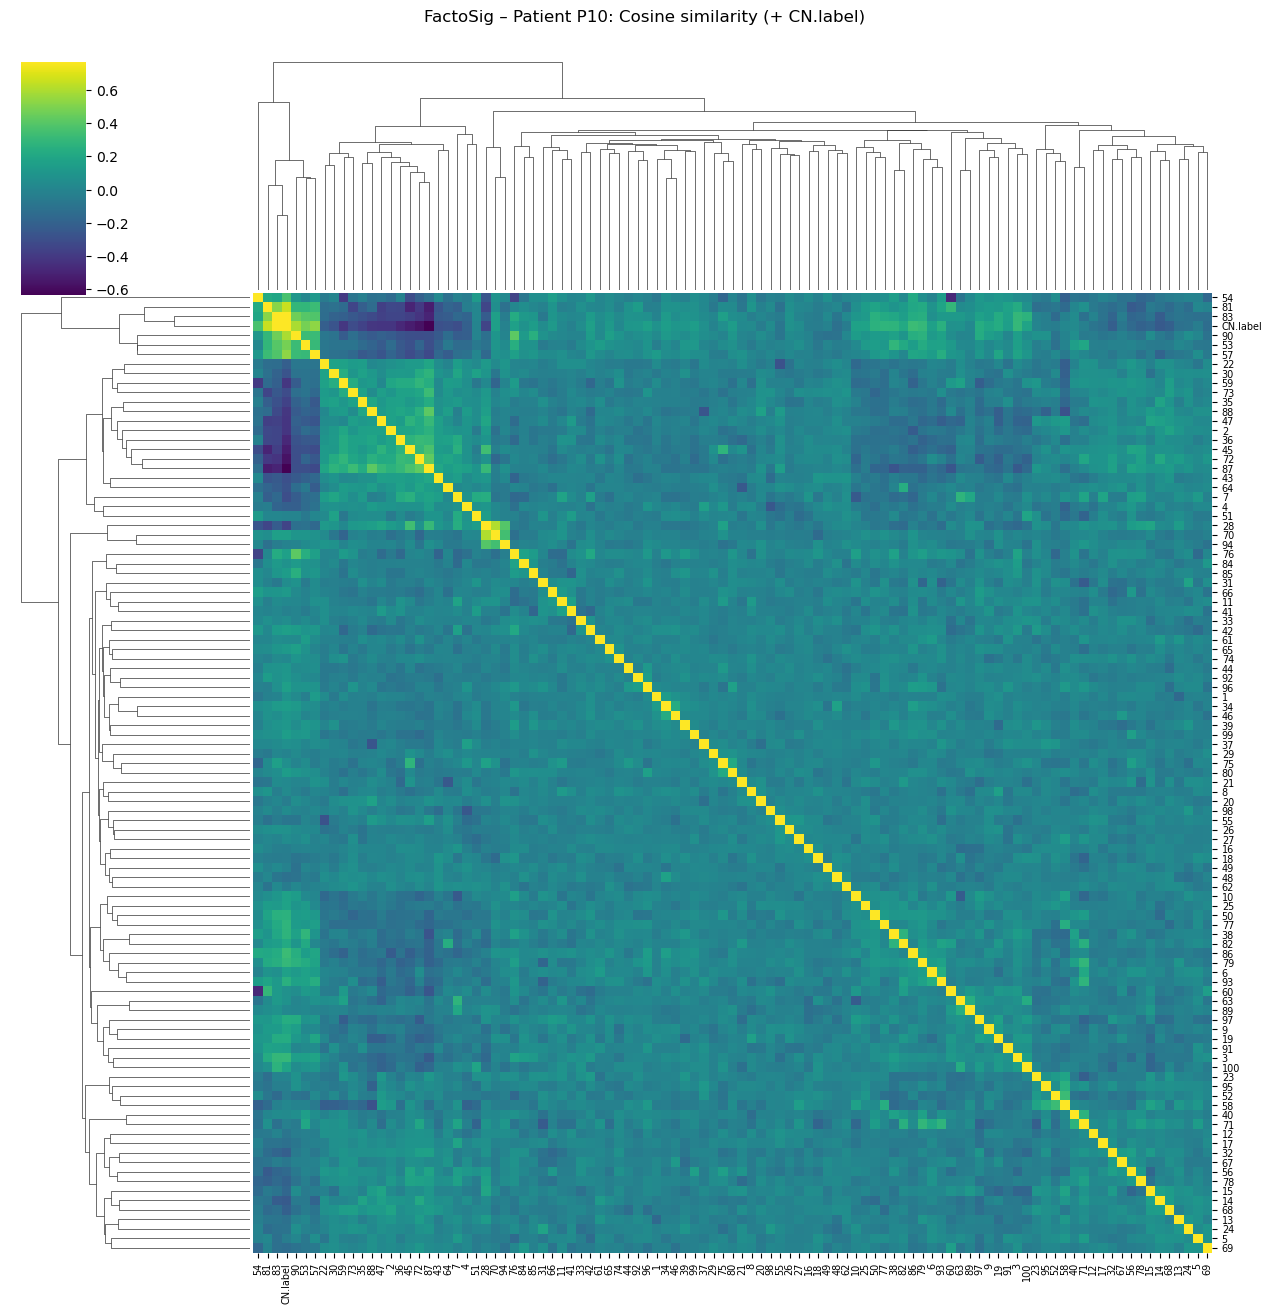

P12


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


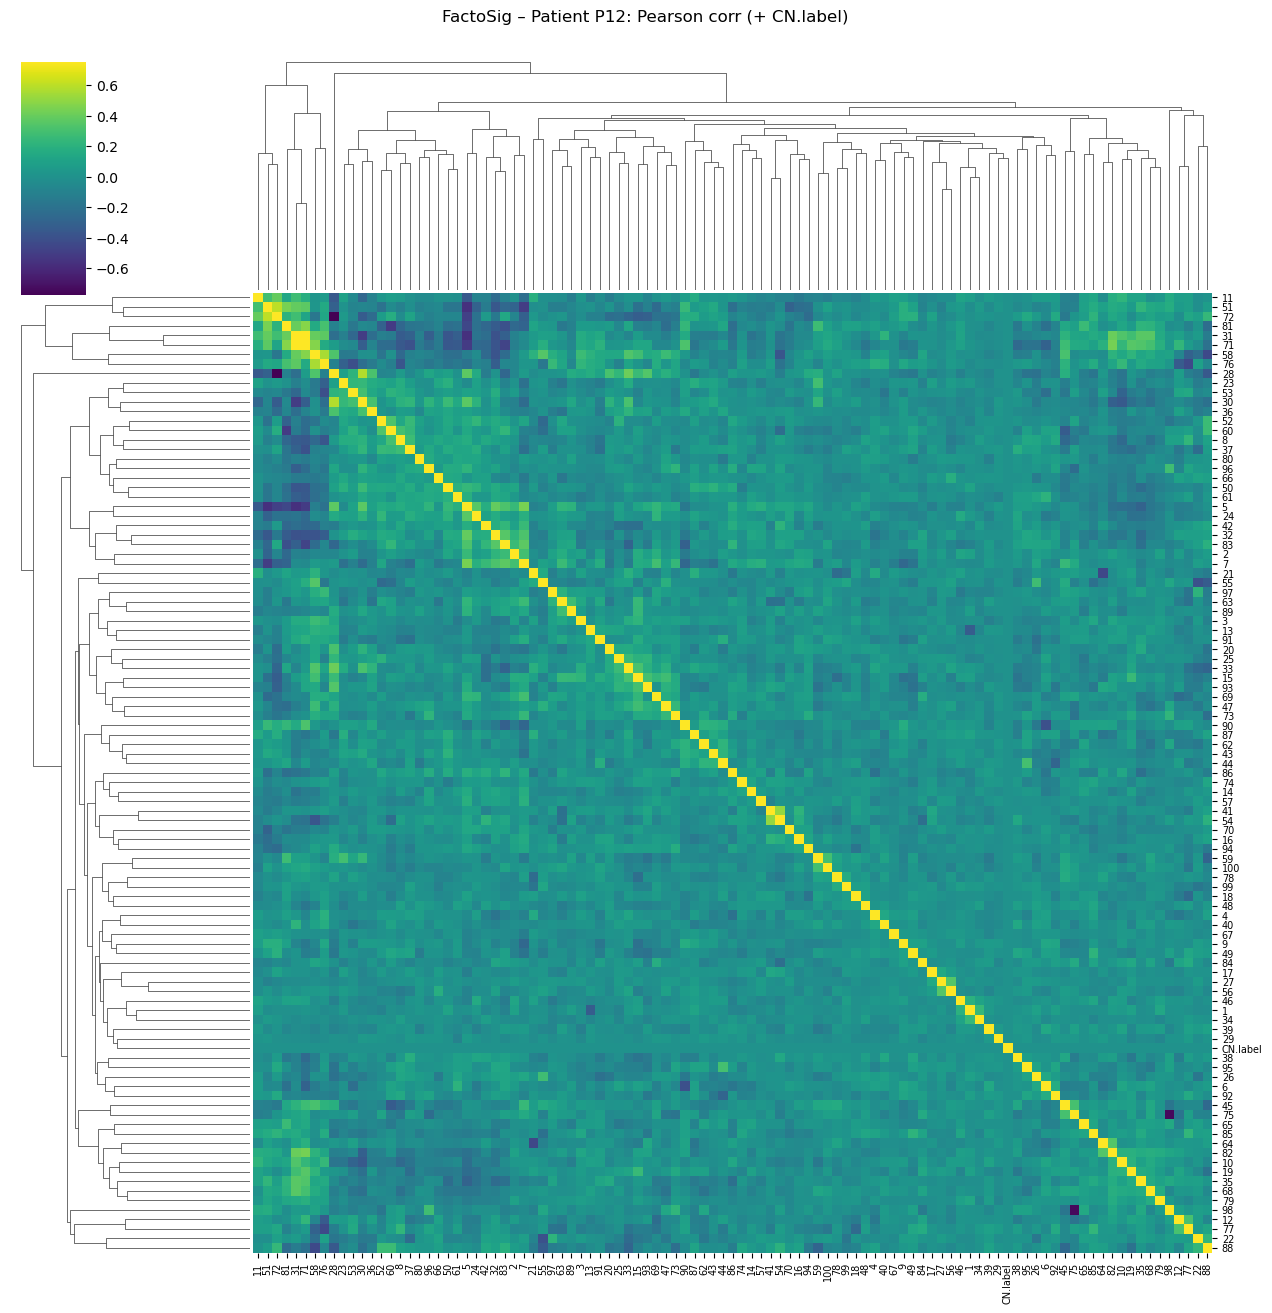

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


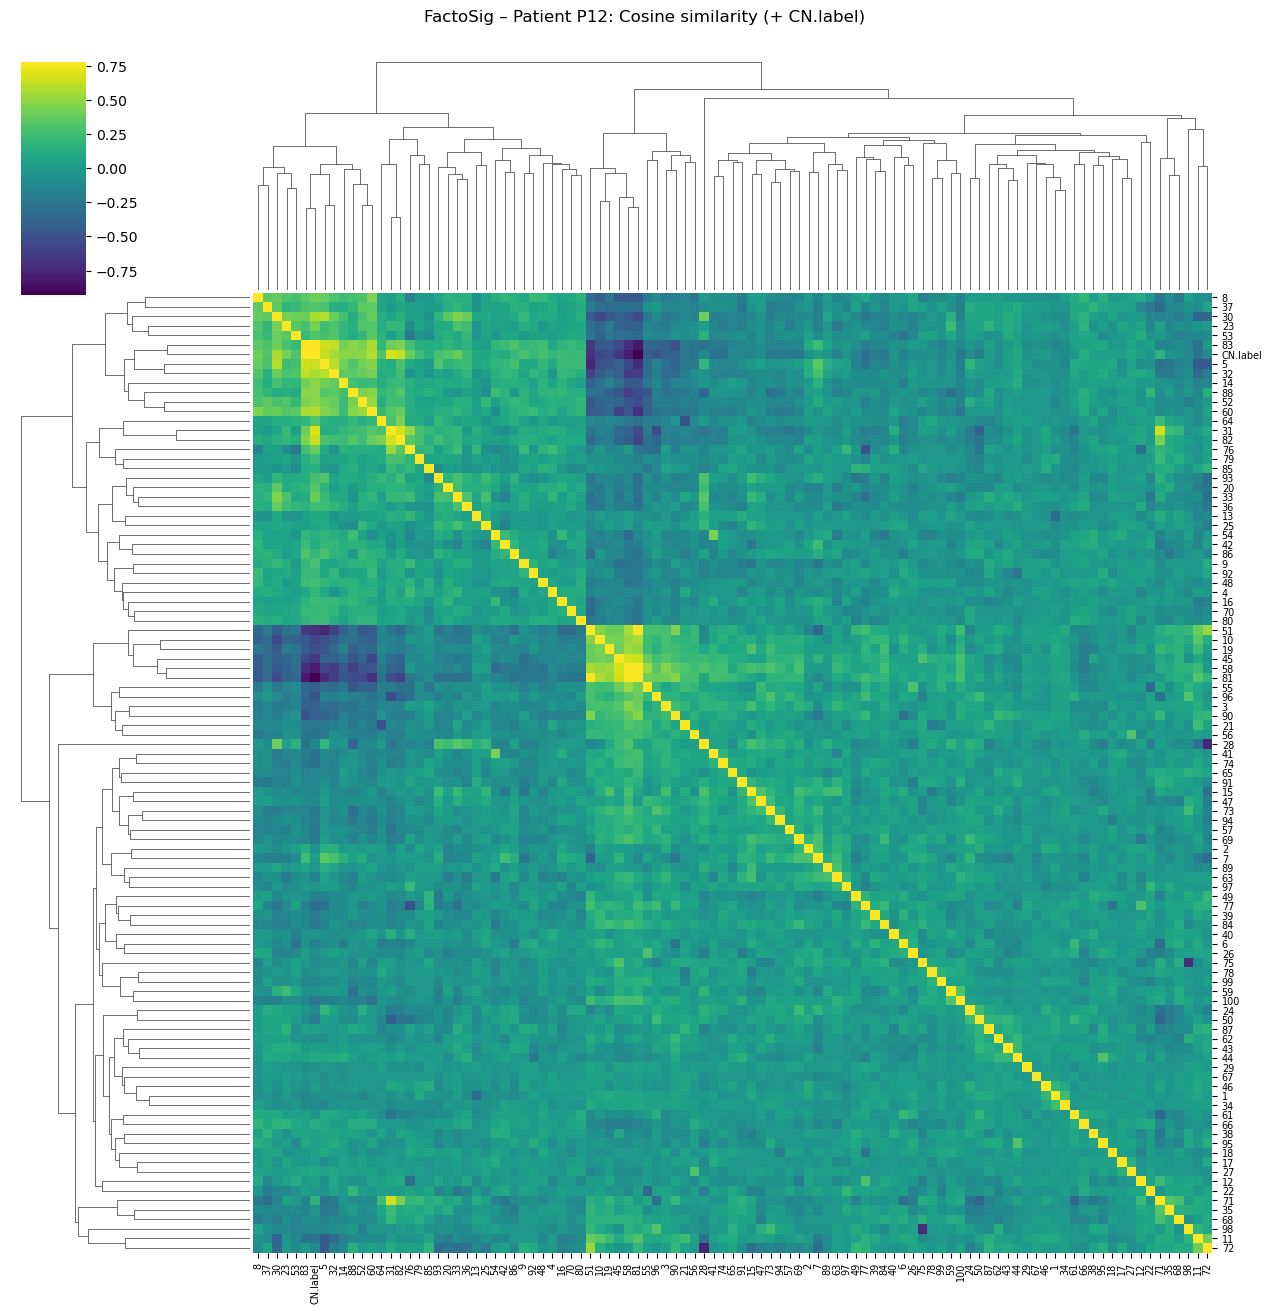

P09


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


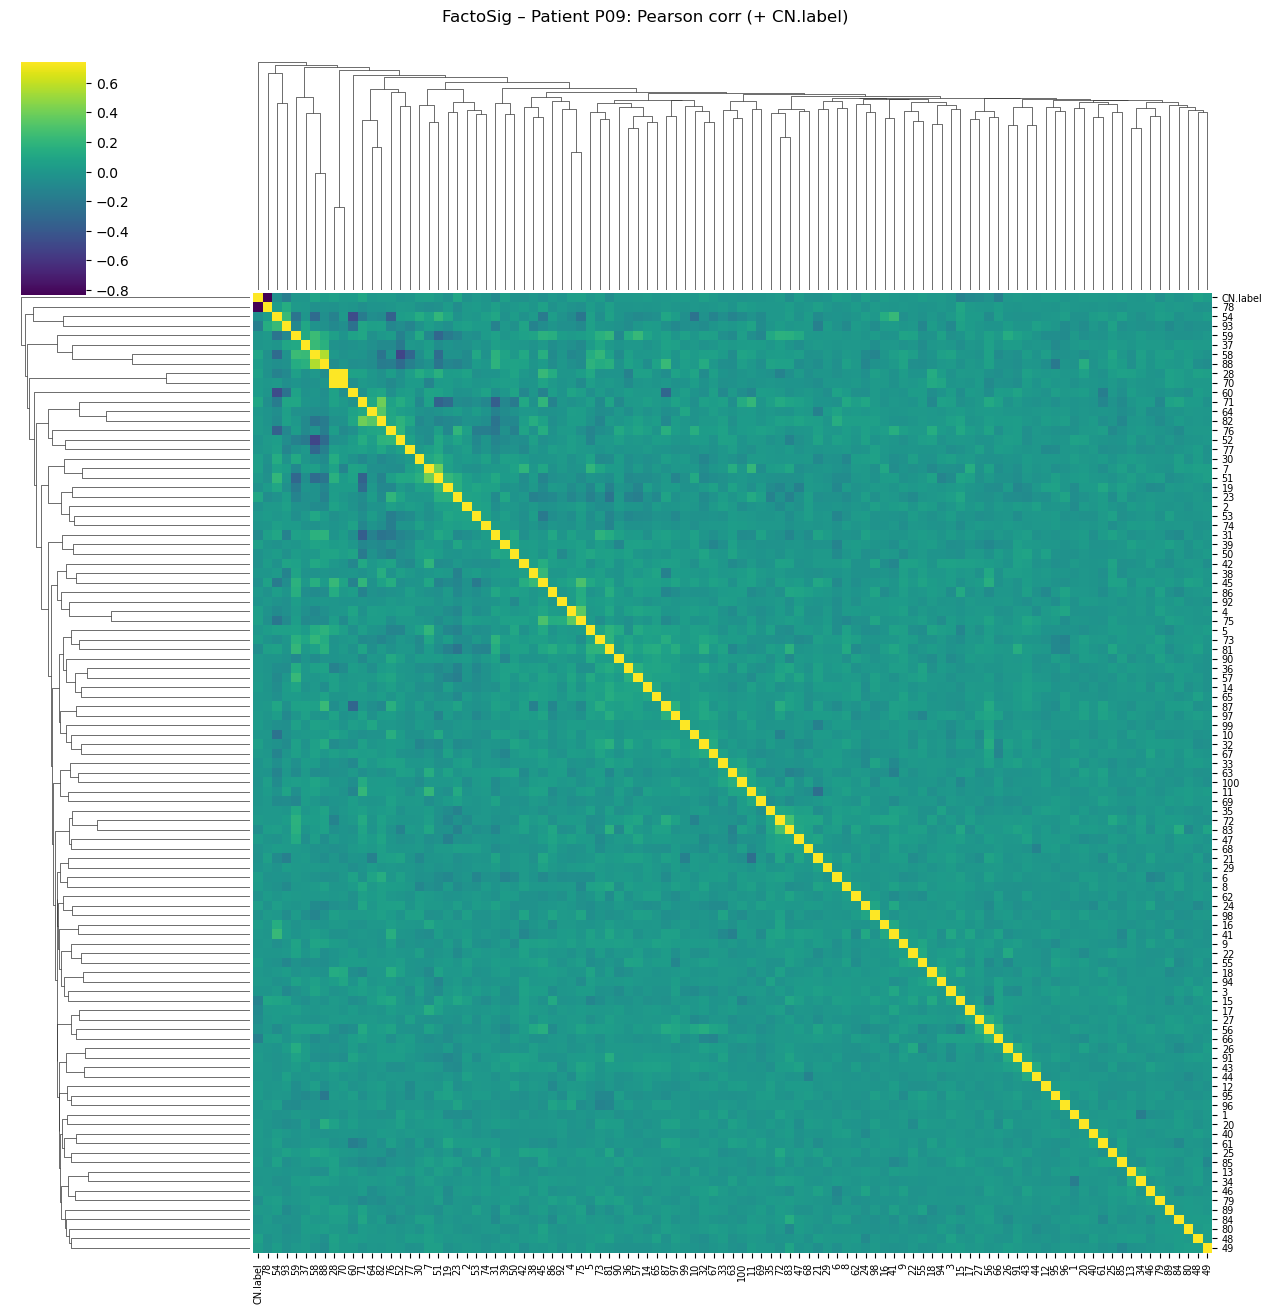

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


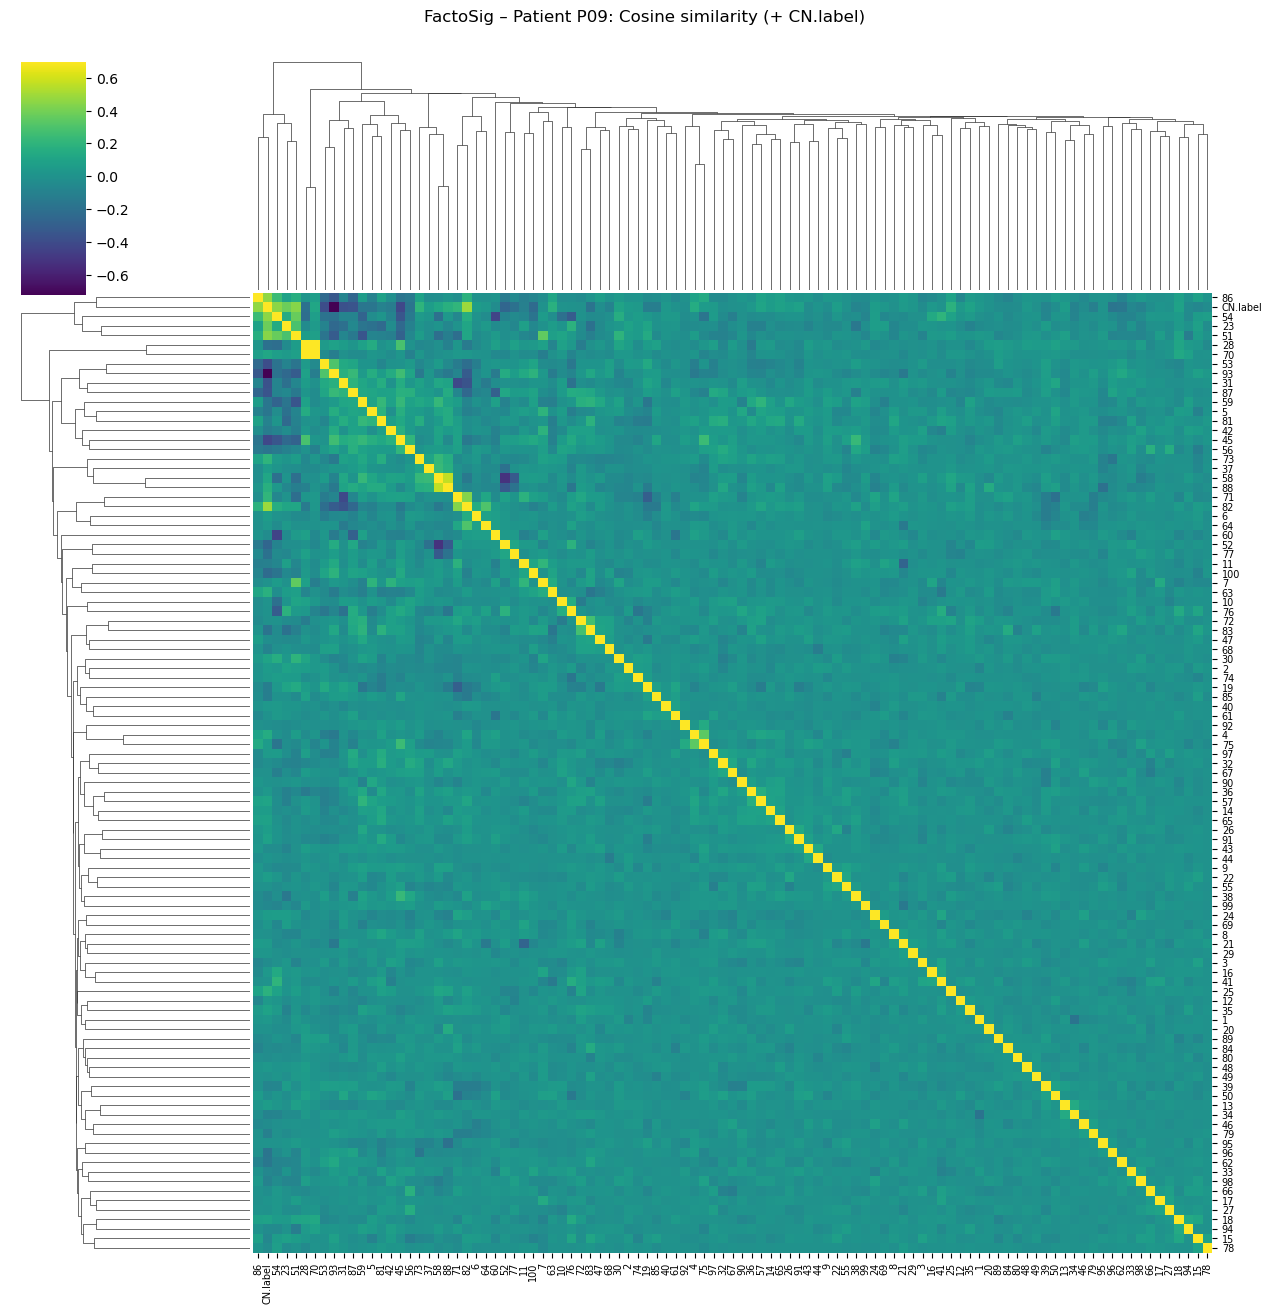

P08


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


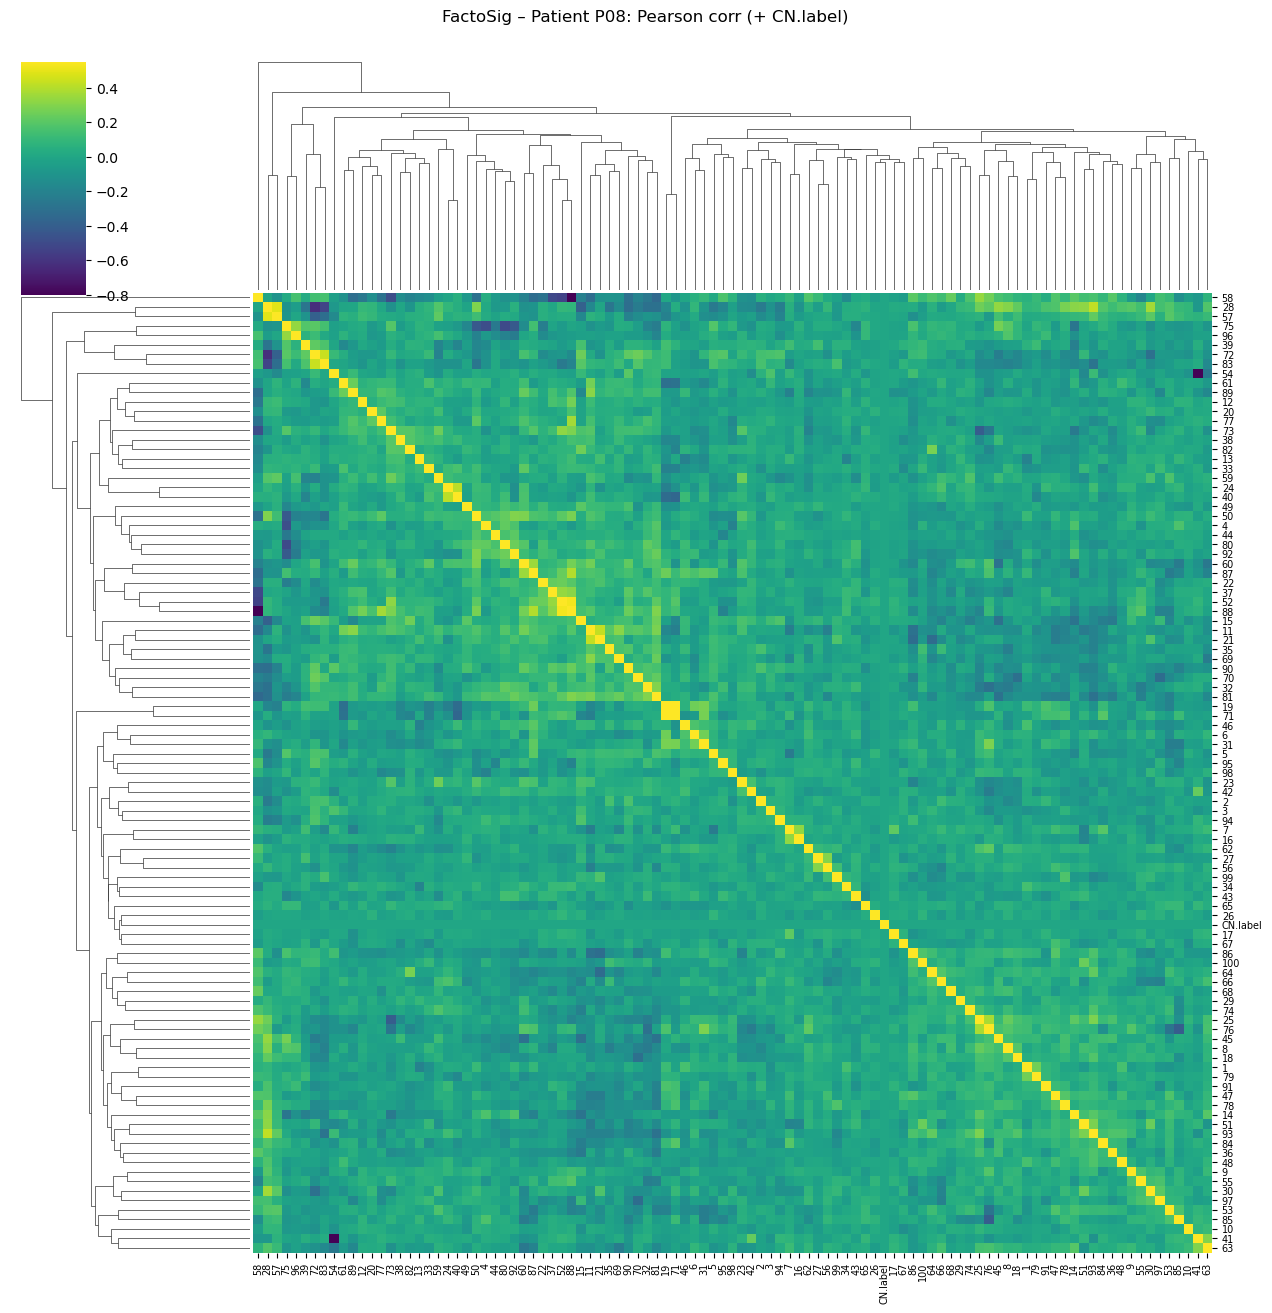

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


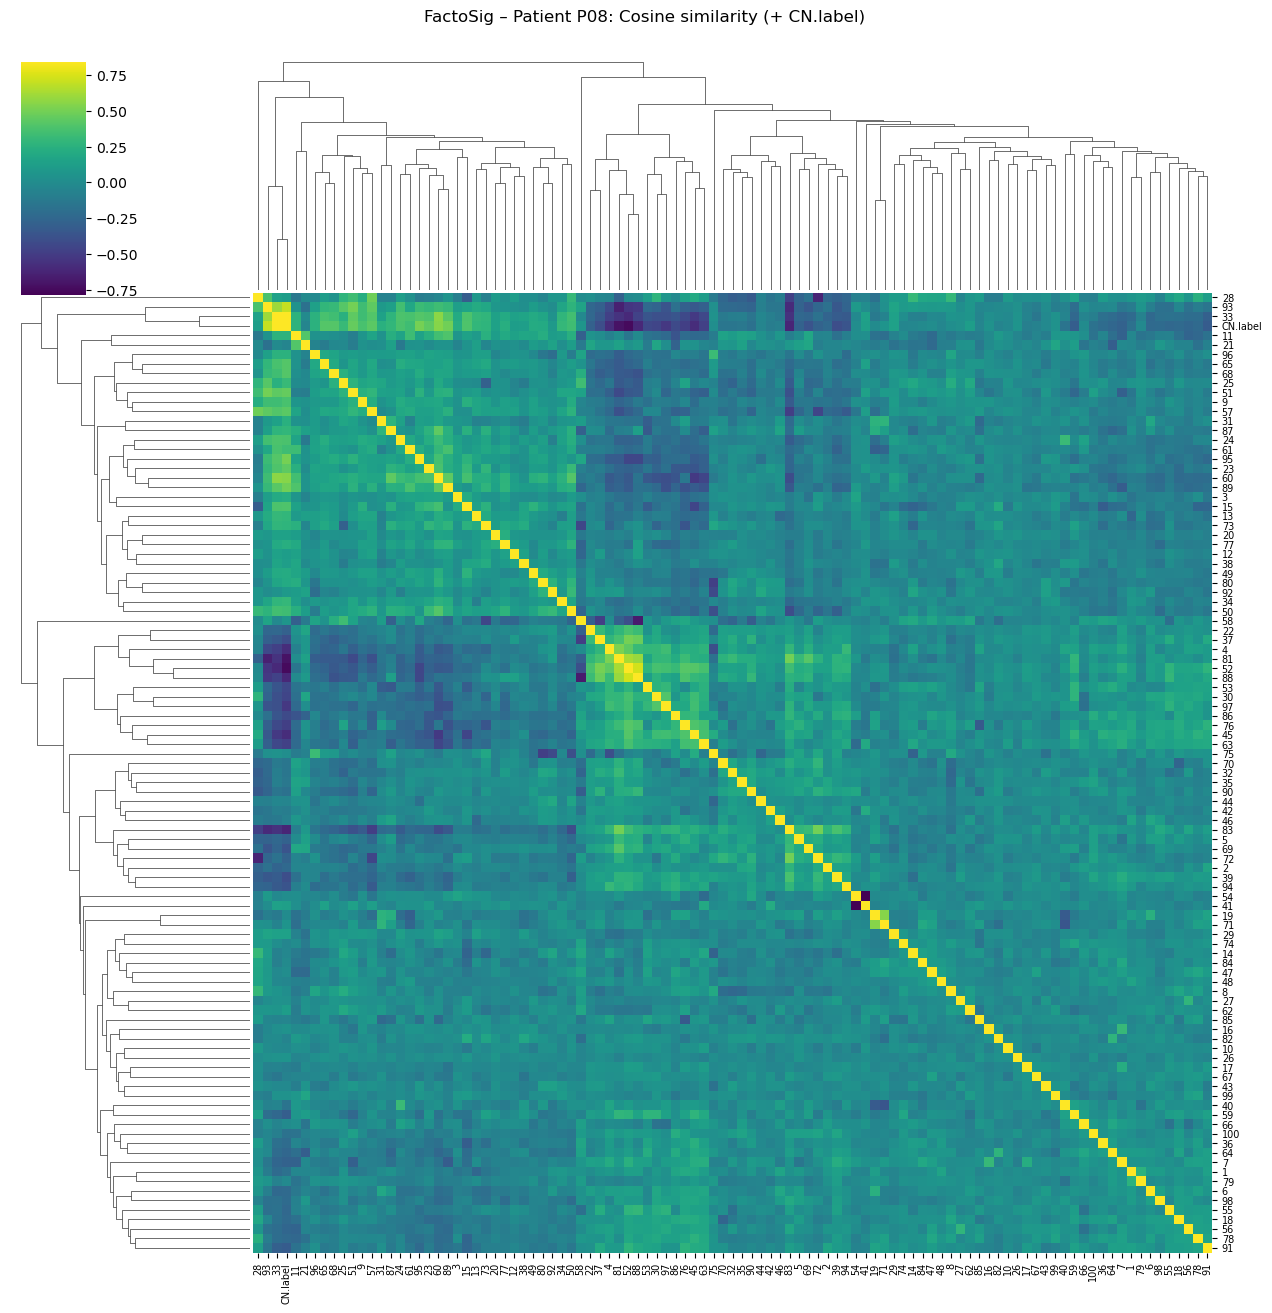

P13


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


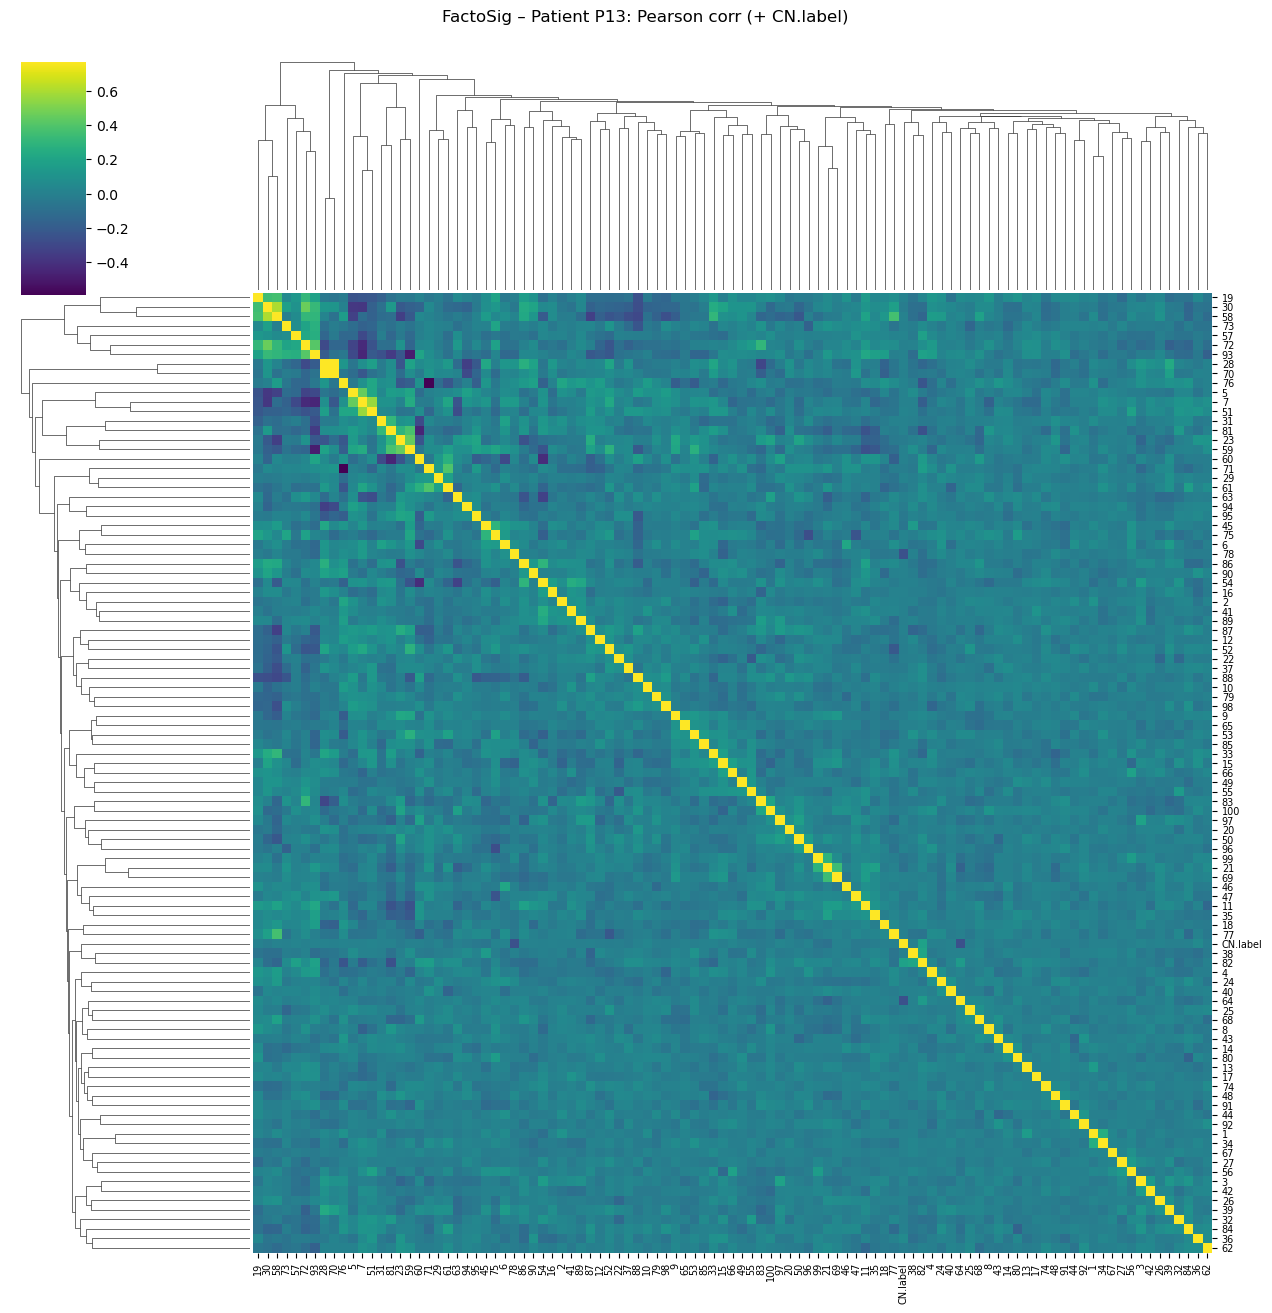

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


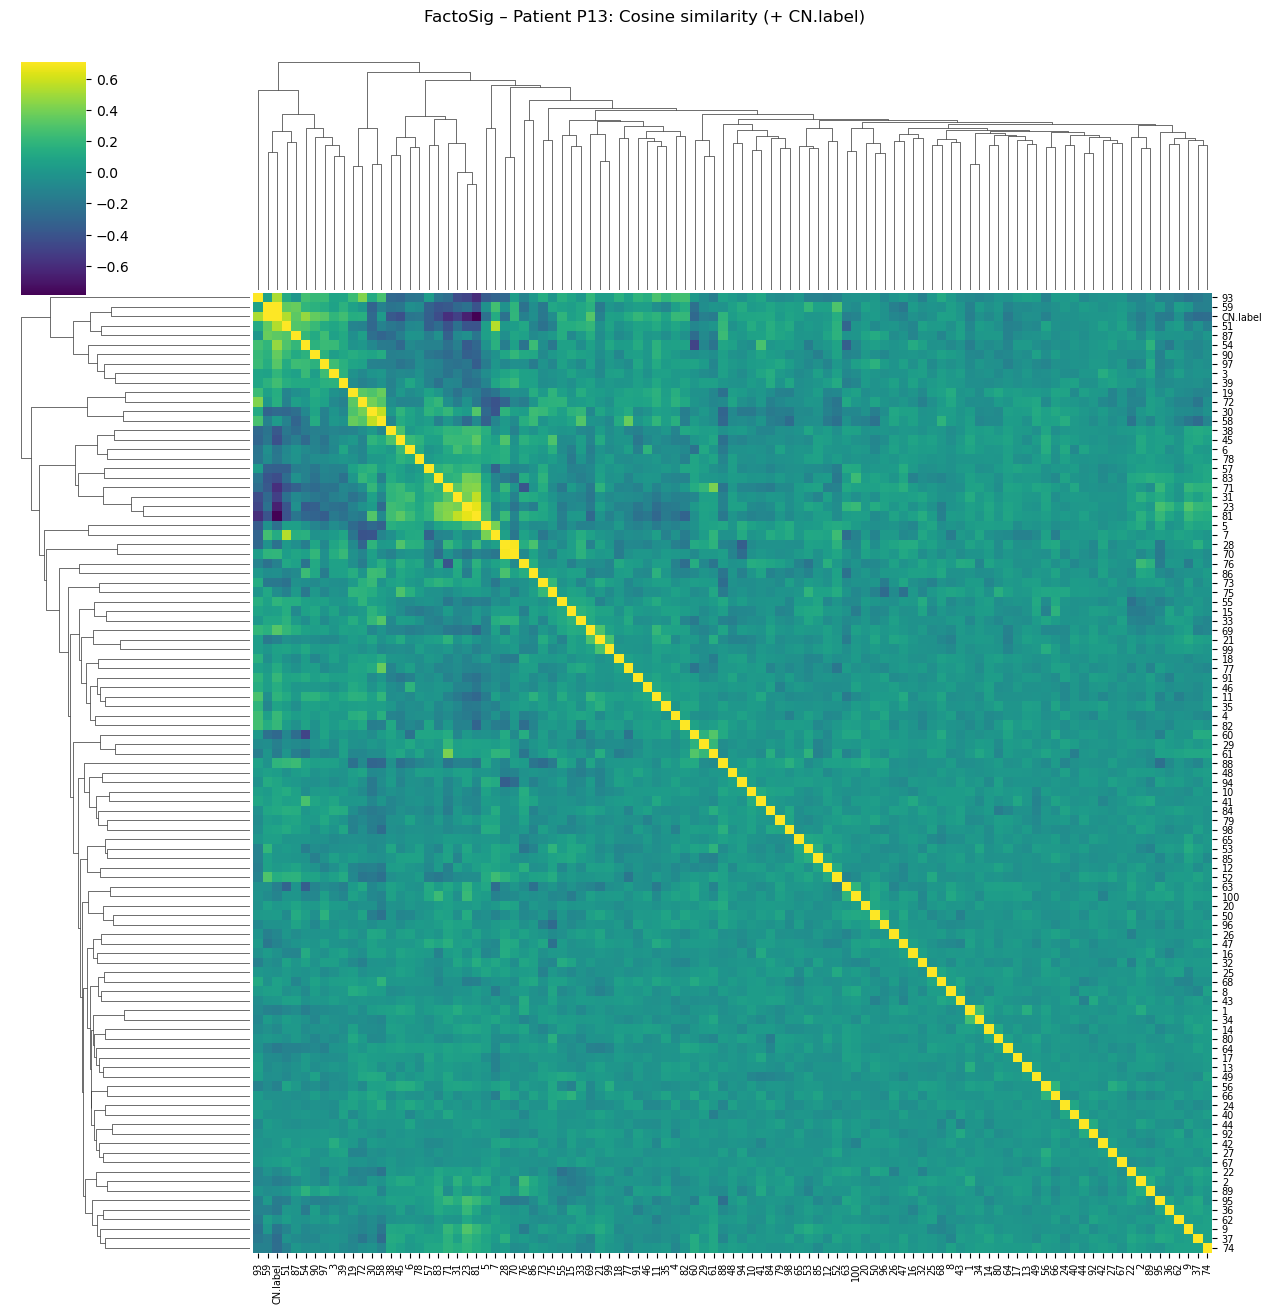

In [15]:
for pid in list(fs_patient_mats.keys()):
    print(pid)
    plot_patient_mats_big(fs_patient_mats, pid, method_name="FactoSig")

### 3.x Heatmaps sorted by target correlation

The standard clustermap is useful for finding blocks of correlated factors, but it can be hard to interpret in relation to the target `CN.label`. By sorting the matrix based on each factor's Pearson correlation with `CN.label`, we can directly visualize:
1.  Which factors are most strongly "pro-malignant" (large negative correlation with the `cancer=0, normal=1` label).
2.  Which factors are most strongly "pro-normal" (large positive correlation).
3.  How factors within these groups correlate with each other.

This view makes it easier to identify functional groups of factors related to the classification task.


In [16]:
def plot_patient_mats_sorted_by_target(mats: Dict[str, dict], pid: str, method_name: str, 
                                       target_name: str = "CN.label", figsize=(13, 11)):
    """
    Plots correlation and cosine similarity matrices for a patient's factors,
    sorted by each factor's correlation with the target label.
    """
    corr = mats[pid]["corr"]
    coss = mats[pid]["cosine"]

    # --- Sort by correlation with target ---
    target_corrs = corr[target_name].drop(target_name)
    sorted_factors = target_corrs.sort_values().index
    sorted_cols = list(sorted_factors) + [target_name]
    
    corr_sorted = corr.loc[sorted_cols, sorted_cols]
    coss_sorted = coss.loc[sorted_cols, sorted_cols]

    def _vlims(M: pd.DataFrame):
        Mnd = M.copy()
        np.fill_diagonal(Mnd.values, np.nan)
        return np.nanmin(Mnd.values), np.nanmax(Mnd.values)

    # --- Plot Pearson Correlation (Sorted) ---
    vmin_c, vmax_c = _vlims(corr_sorted)
    plt.figure(figsize=figsize)
    sns.heatmap(corr_sorted, cmap="viridis", vmin=vmin_c, vmax=vmax_c,
                xticklabels=True, yticklabels=True)
    plt.xticks(fontsize=7, rotation=90)
    plt.yticks(fontsize=7)
    plt.title(f"{method_name} – Patient {pid}: Pearson corr sorted by '{target_name}' corr", y=1.02)
    plt.show()

    # --- Plot Cosine Similarity (Sorted) ---
    vmin_s, vmax_s = _vlims(coss_sorted)
    plt.figure(figsize=figsize)
    sns.heatmap(coss_sorted, cmap="viridis", vmin=vmin_s, vmax=vmax_s,
                xticklabels=True, yticklabels=True)
    plt.xticks(fontsize=7, rotation=90)
    plt.yticks(fontsize=7)
    plt.title(f"{method_name} – Patient {pid}: Cosine similarity sorted by '{target_name}' corr", y=1.02)
    plt.show()


--- Patient P01 (Sorted by Target Correlation) ---


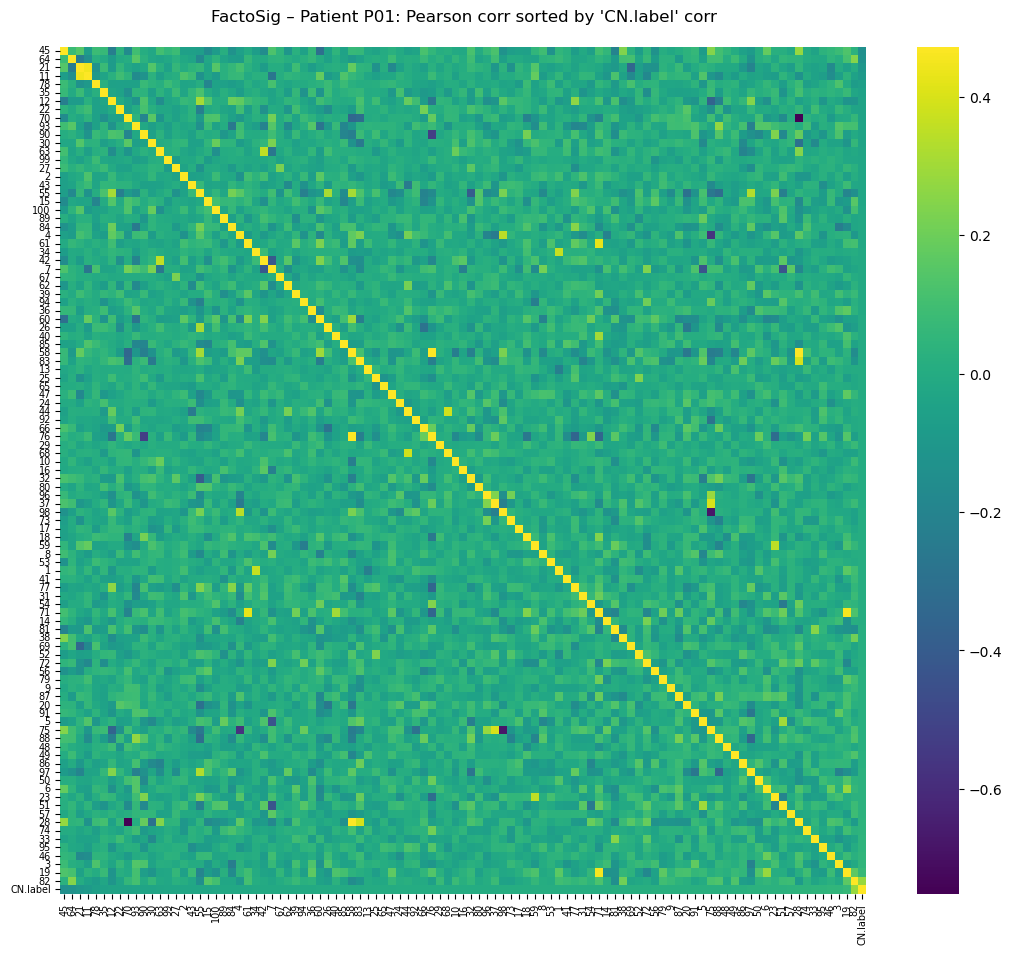

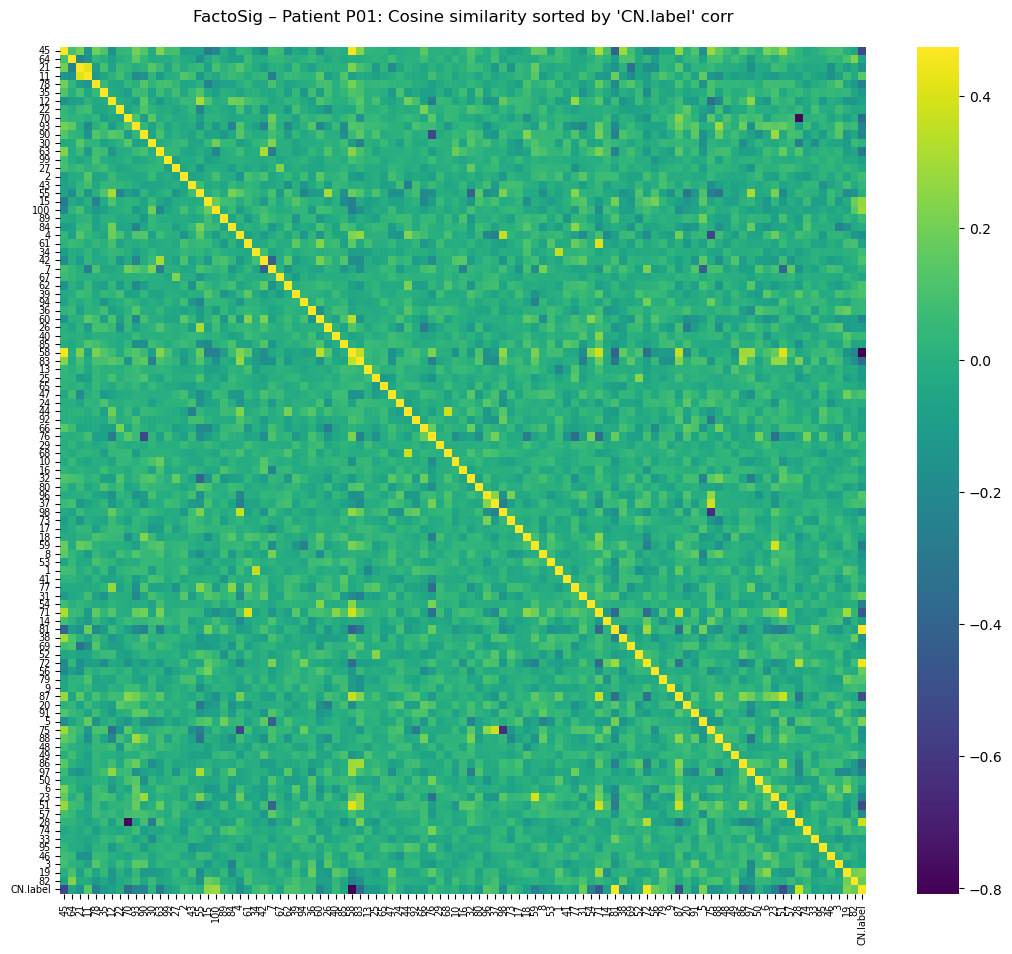

--- Patient P03 (Sorted by Target Correlation) ---


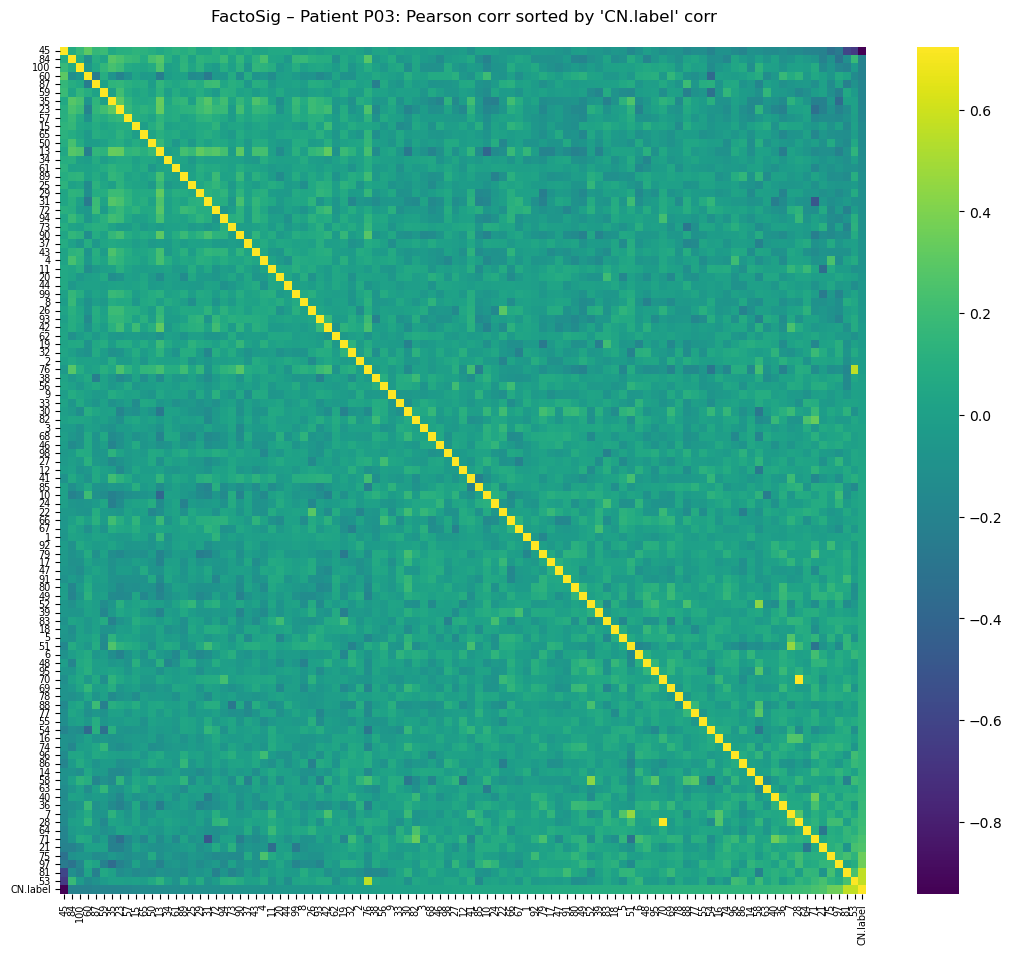

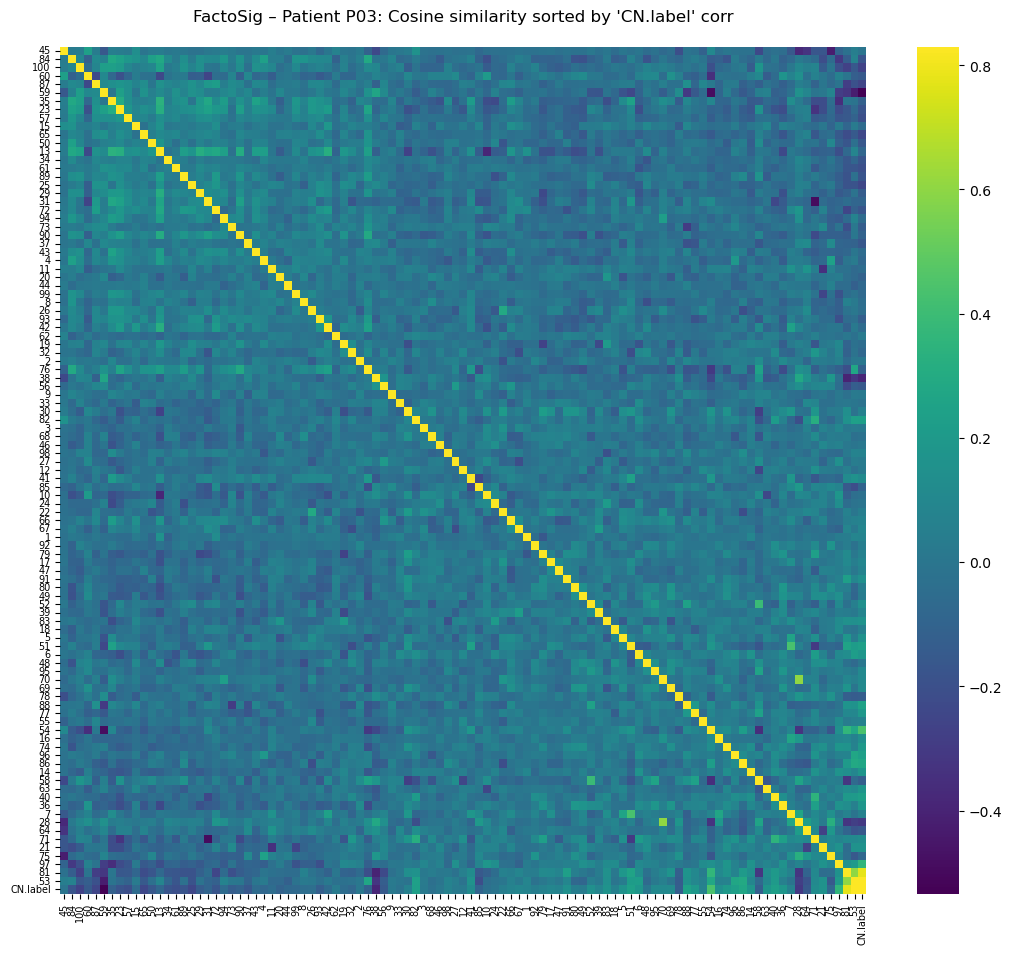

--- Patient P02 (Sorted by Target Correlation) ---


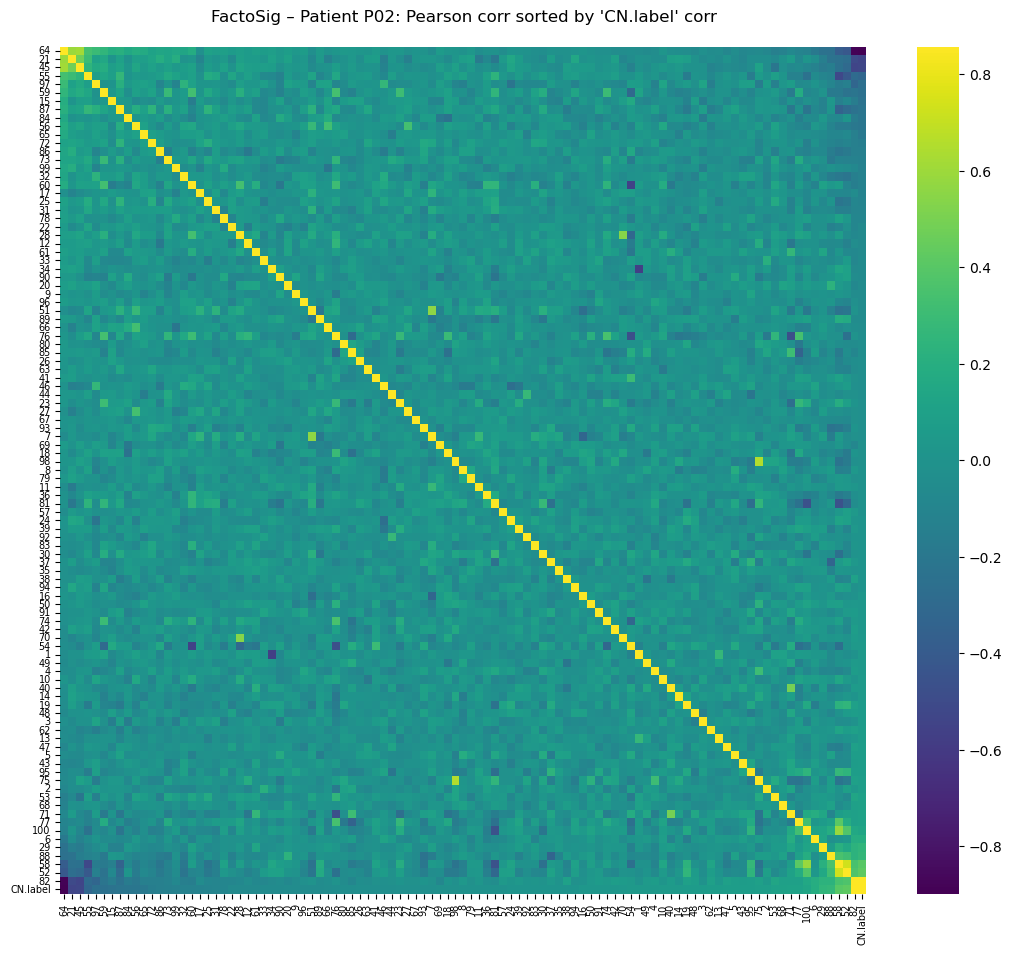

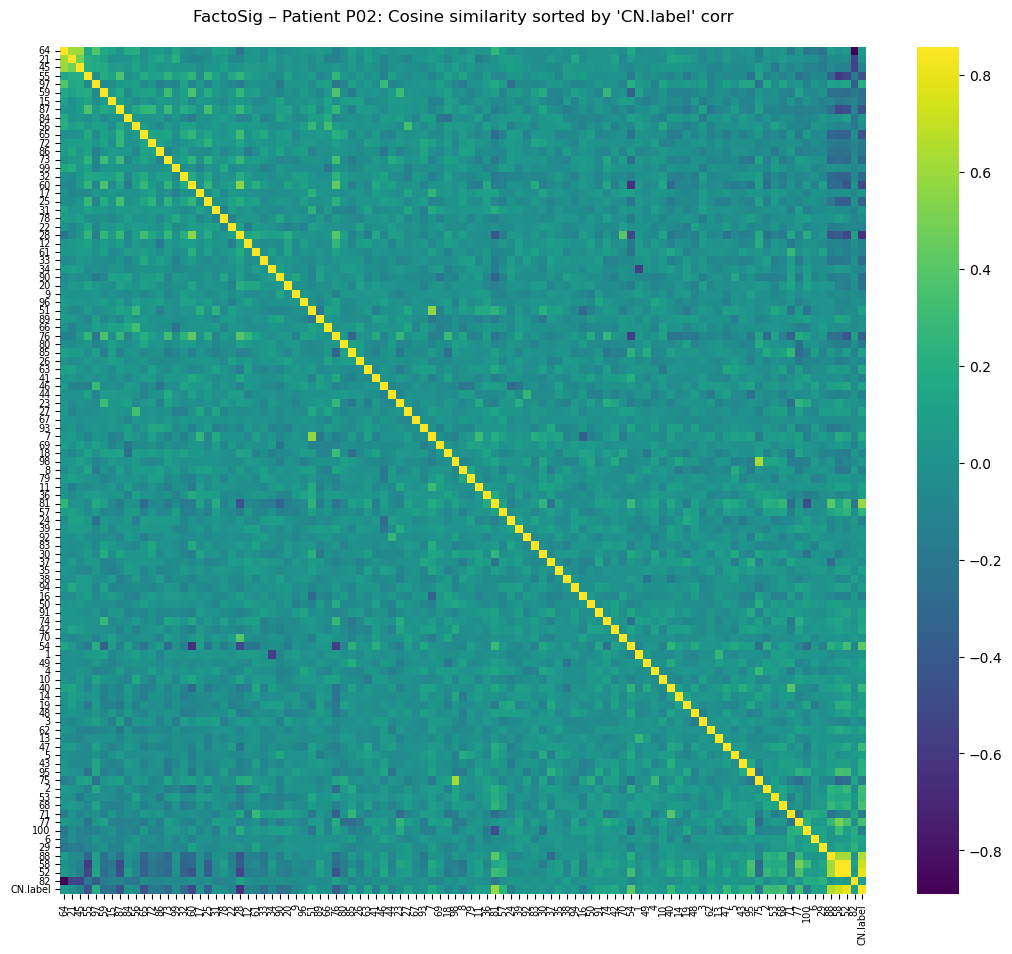

--- Patient P05 (Sorted by Target Correlation) ---


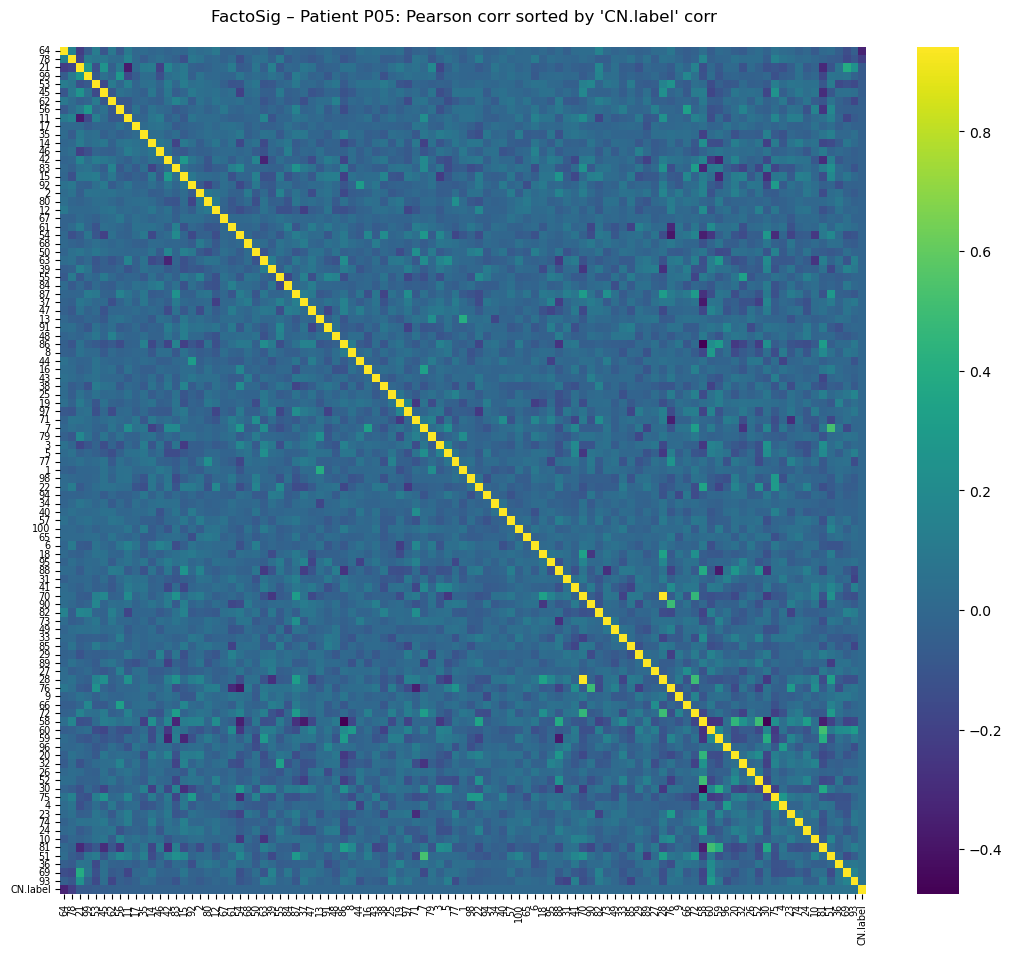

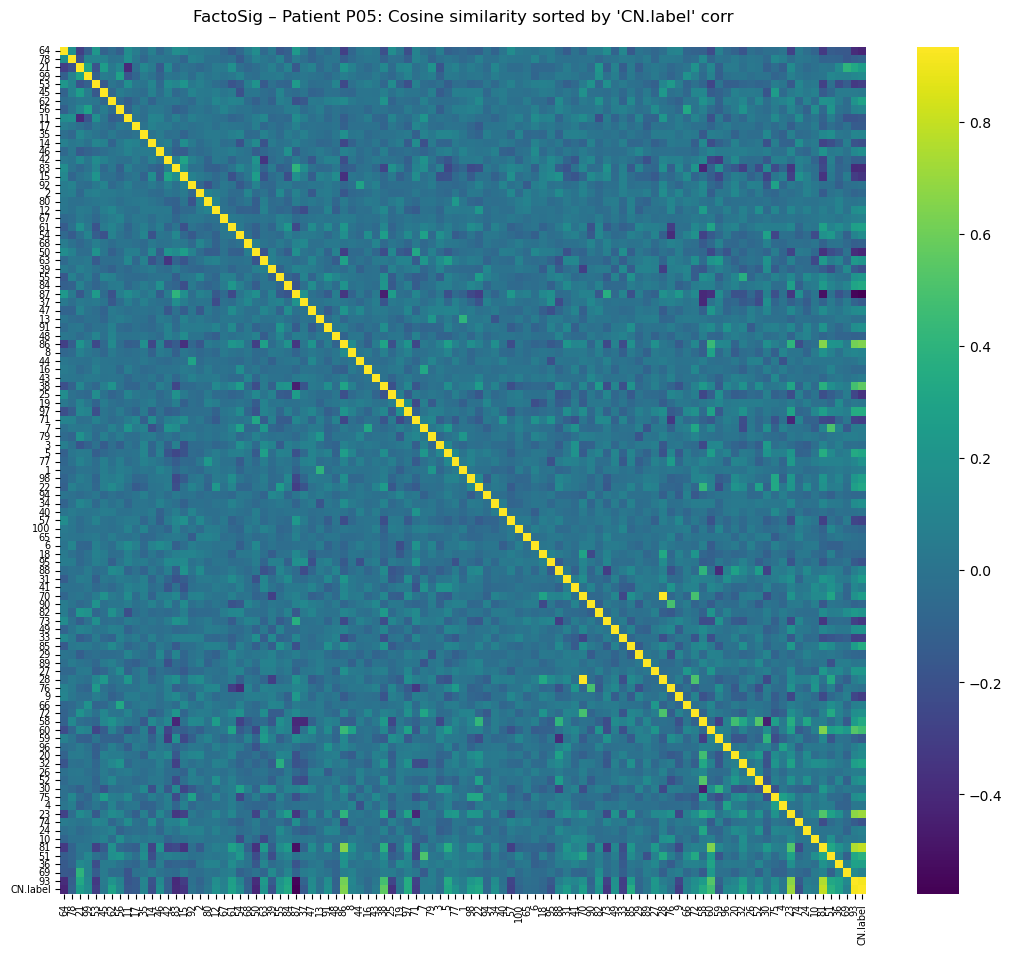

--- Patient P04 (Sorted by Target Correlation) ---


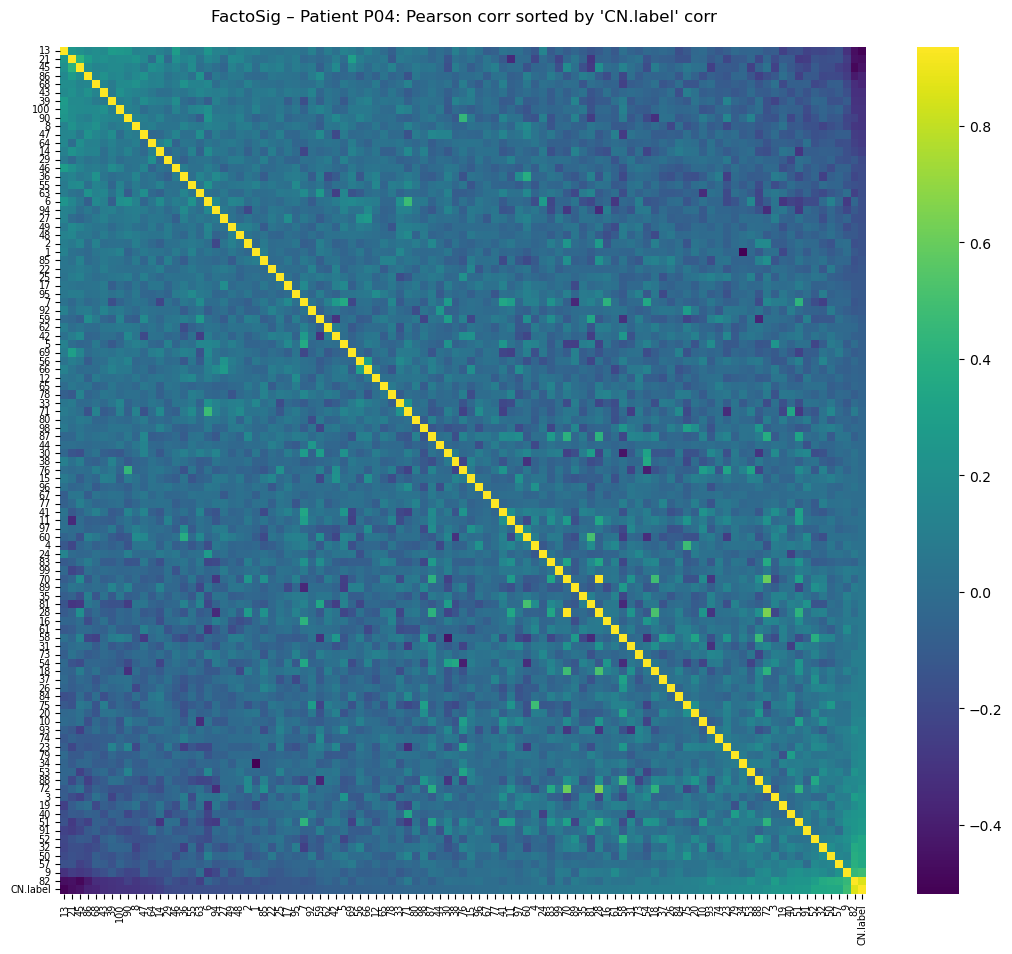

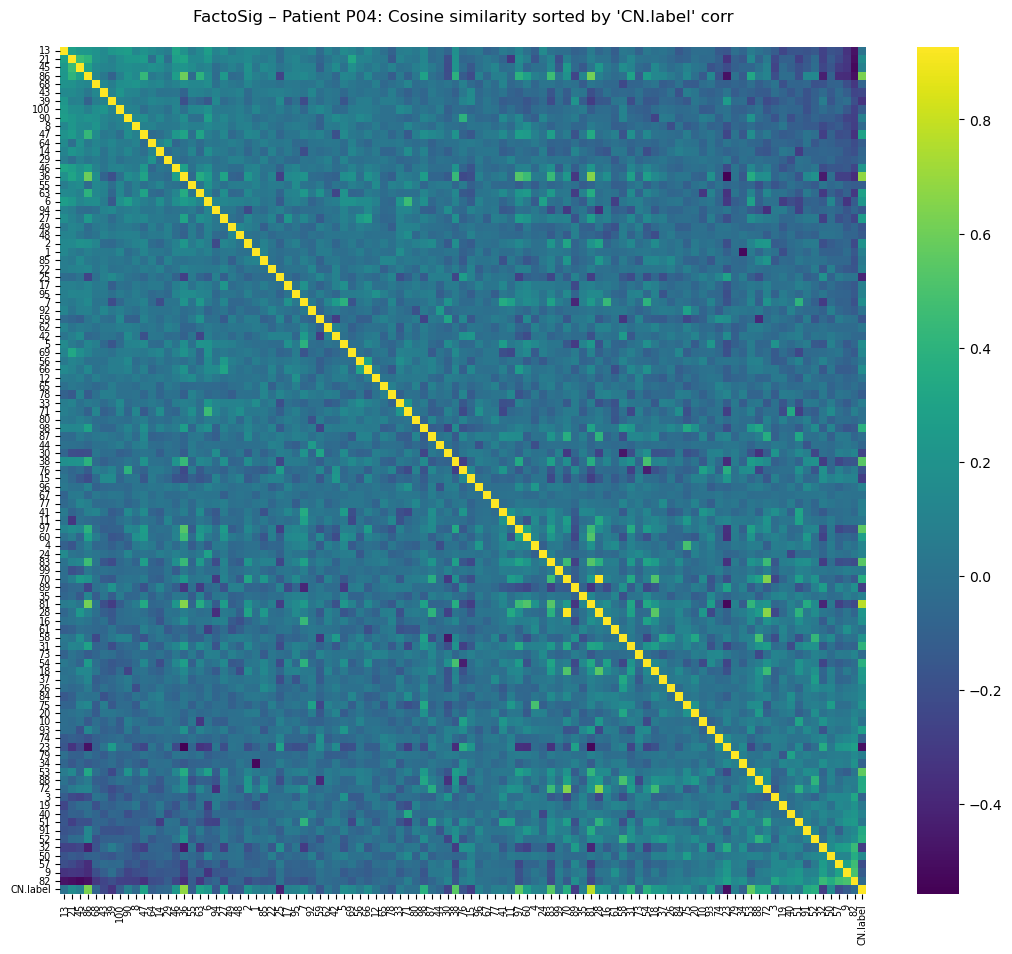

--- Patient P06 (Sorted by Target Correlation) ---


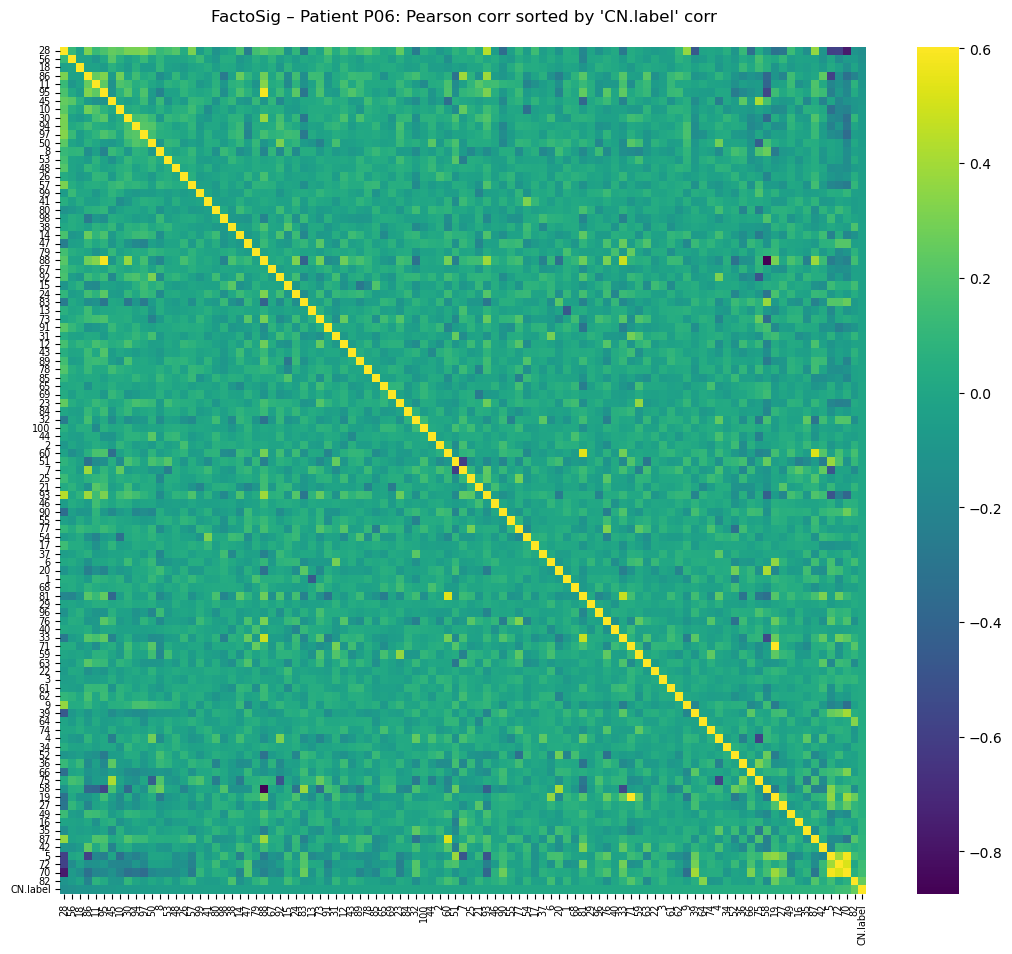

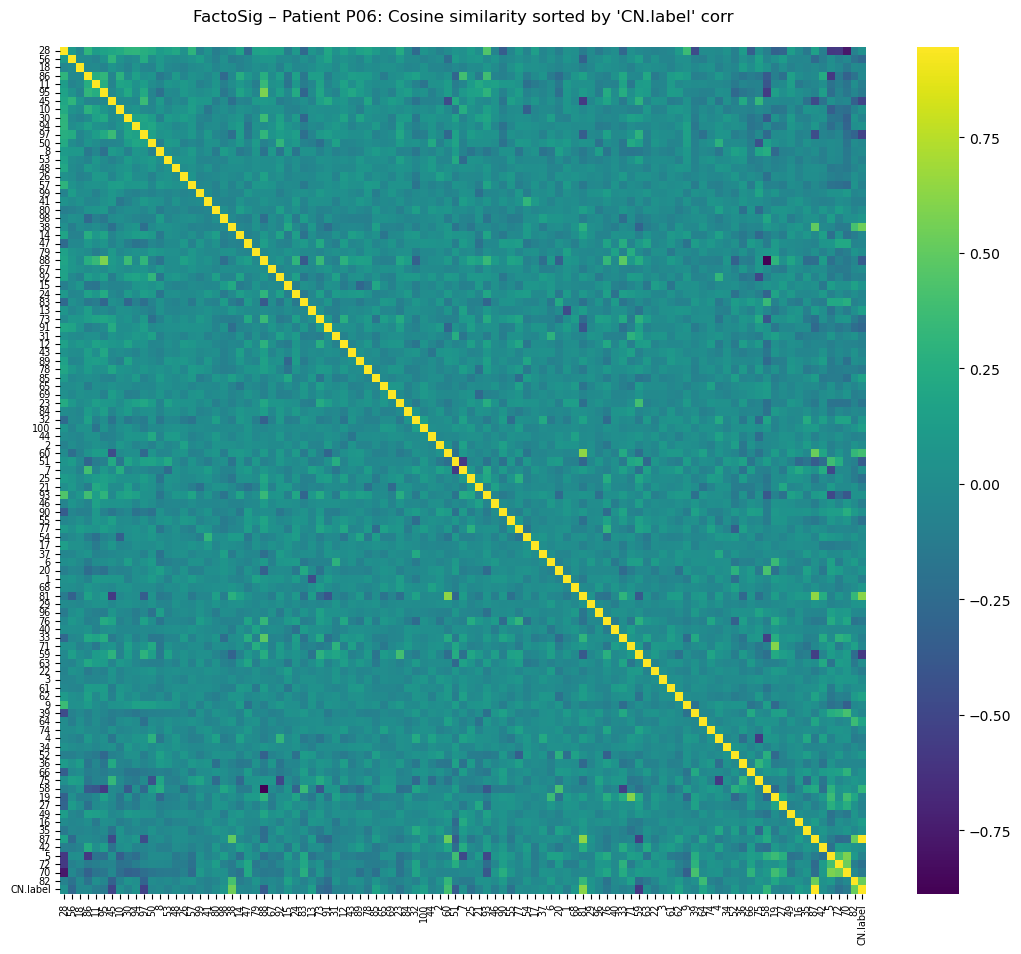

--- Patient P11 (Sorted by Target Correlation) ---


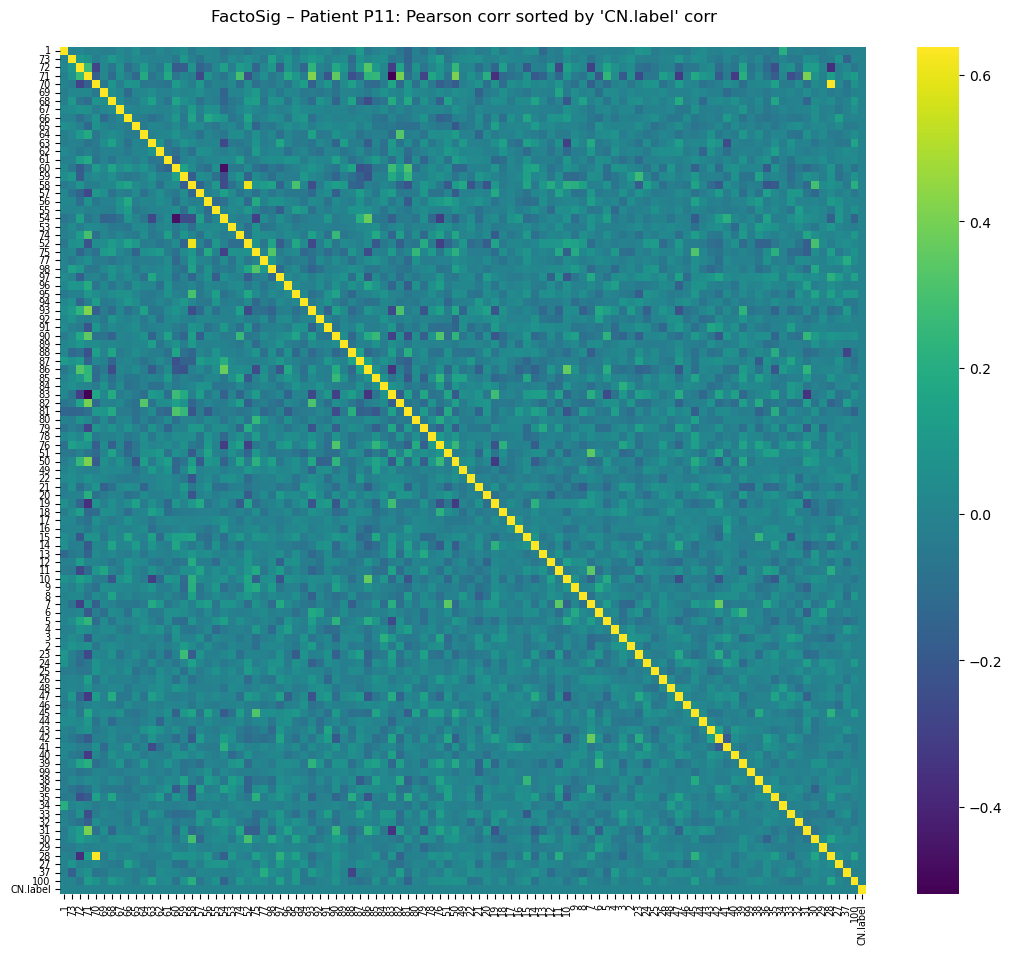

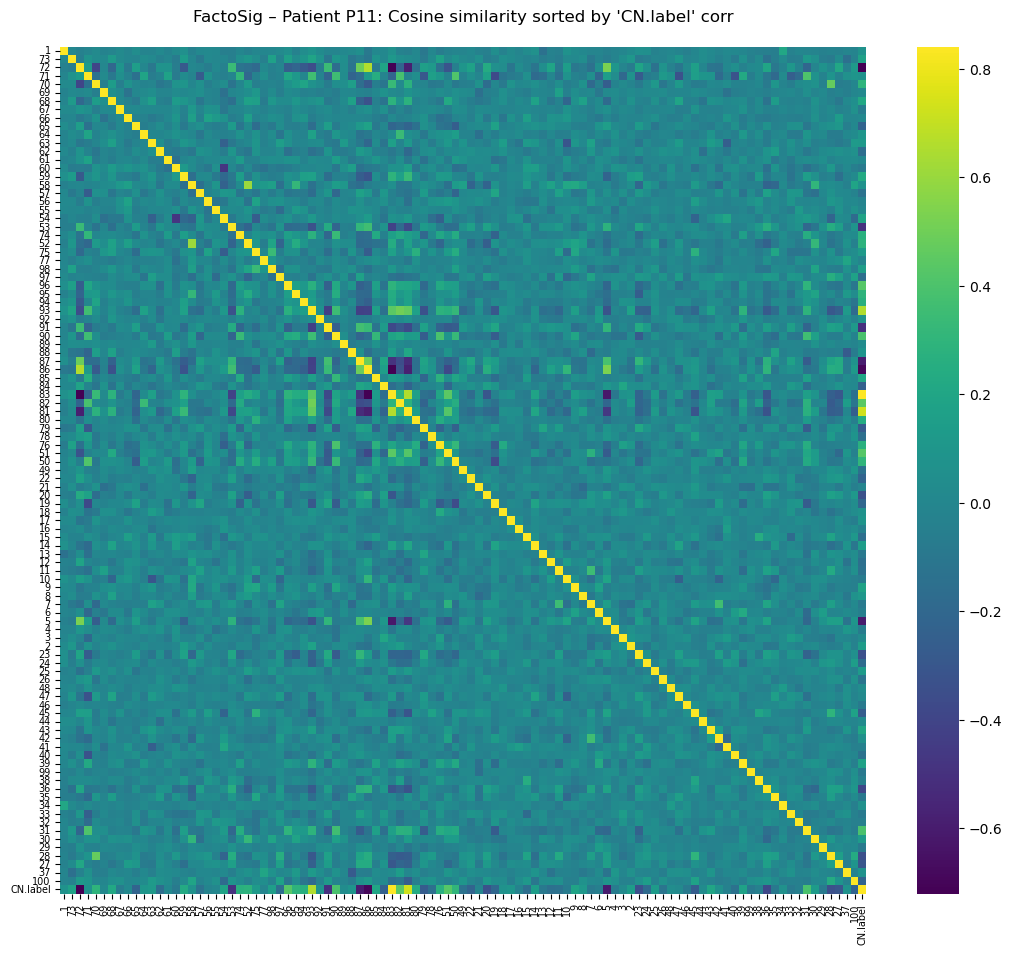

--- Patient P07 (Sorted by Target Correlation) ---


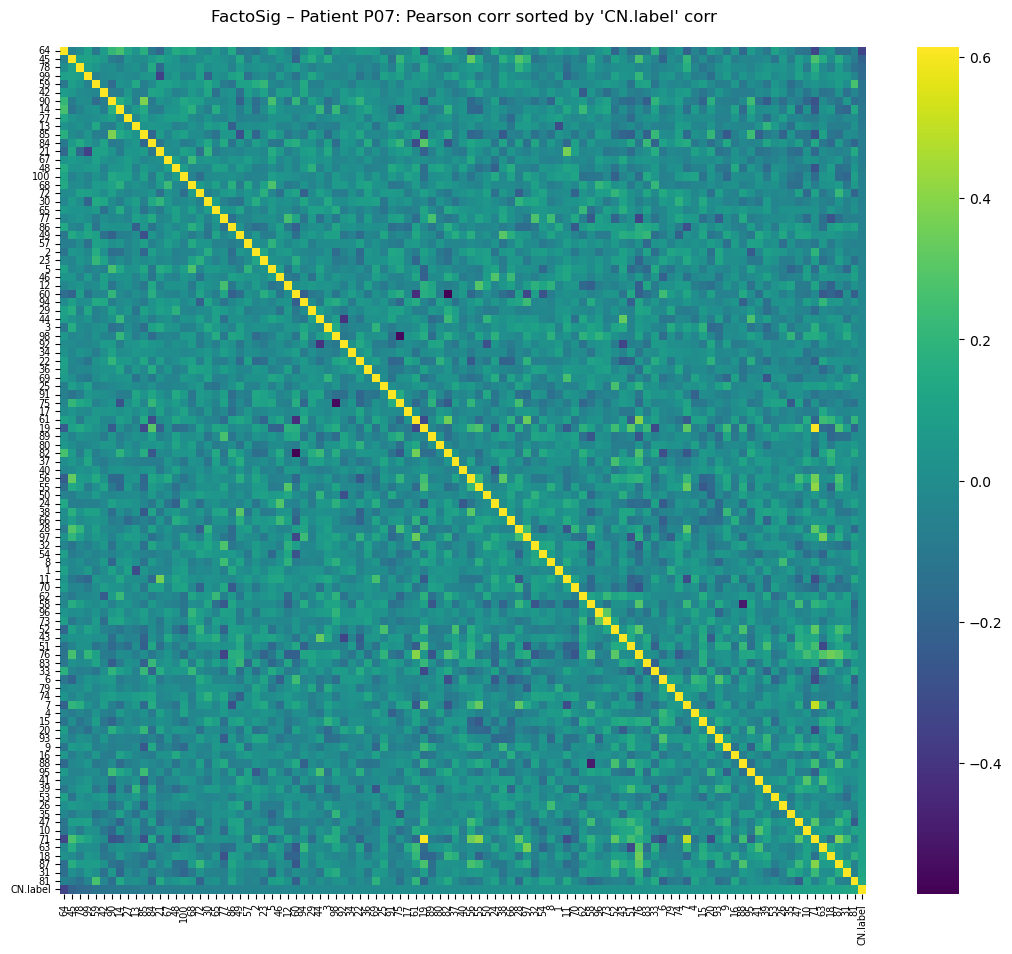

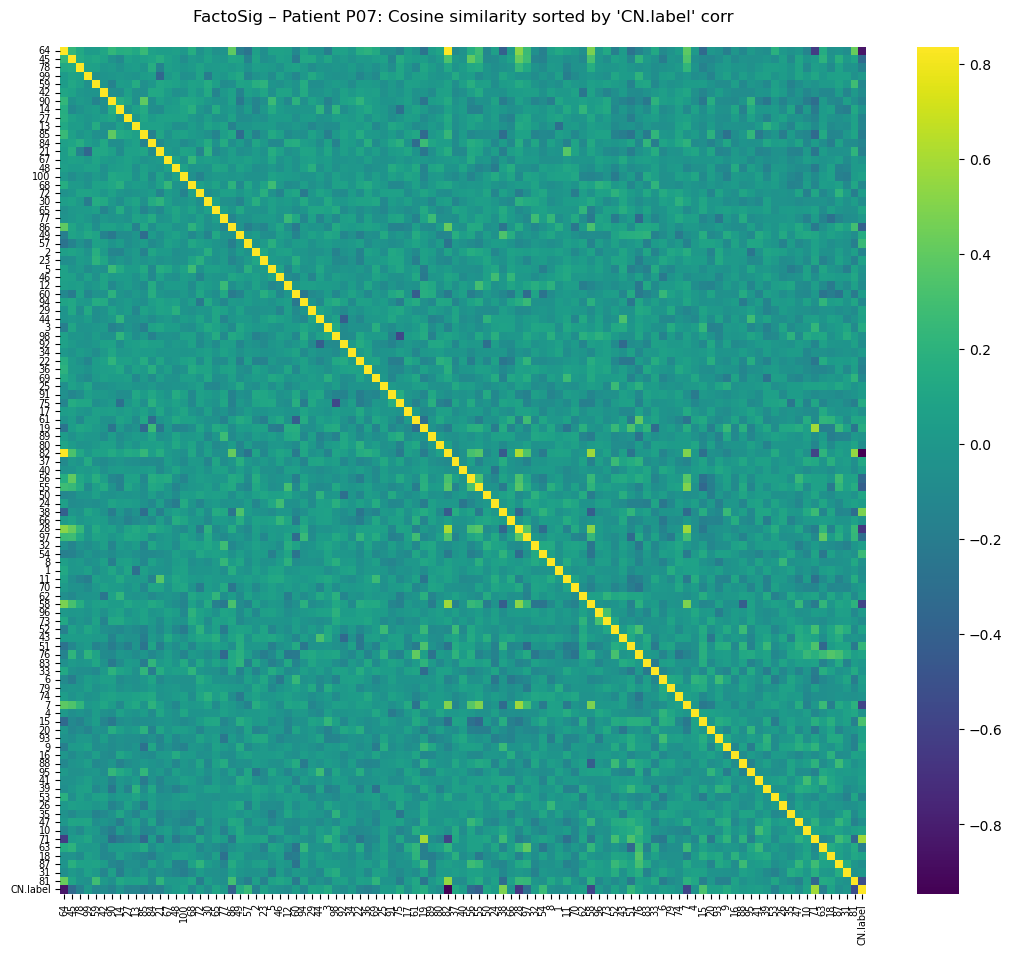

--- Patient P10 (Sorted by Target Correlation) ---


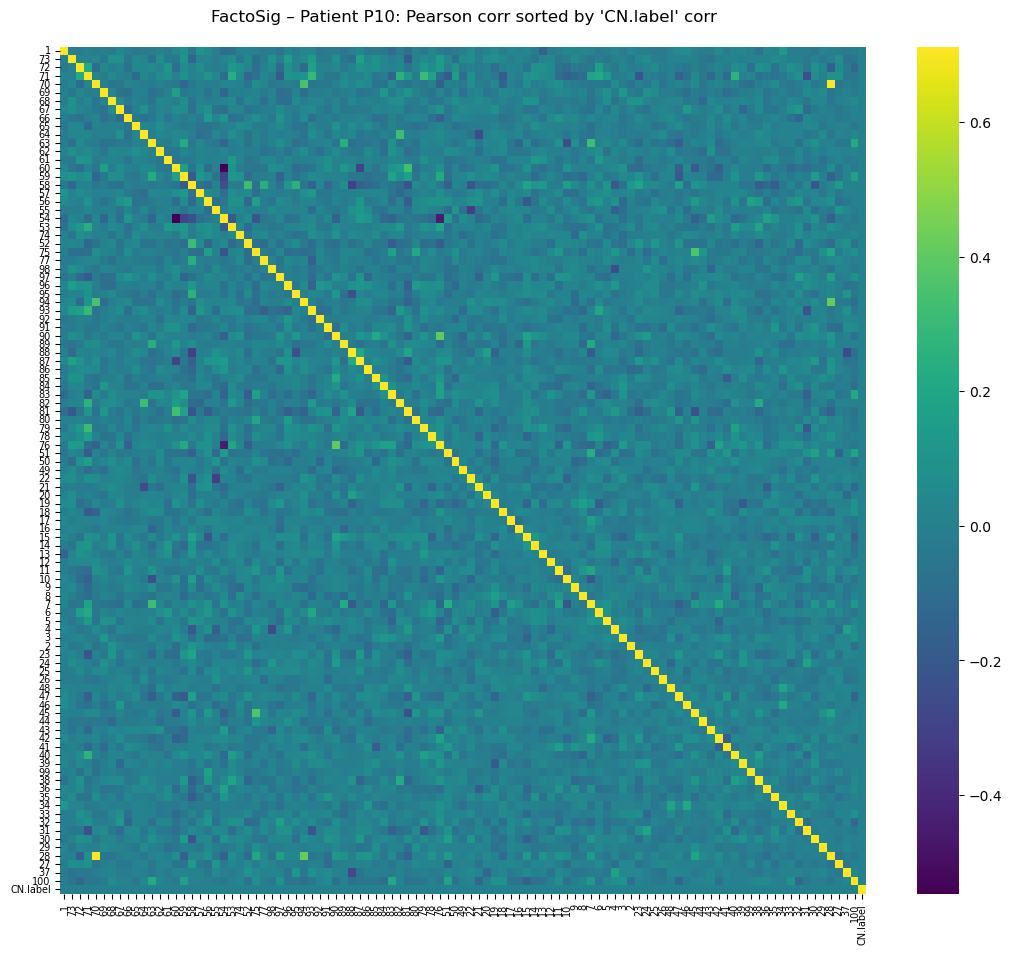

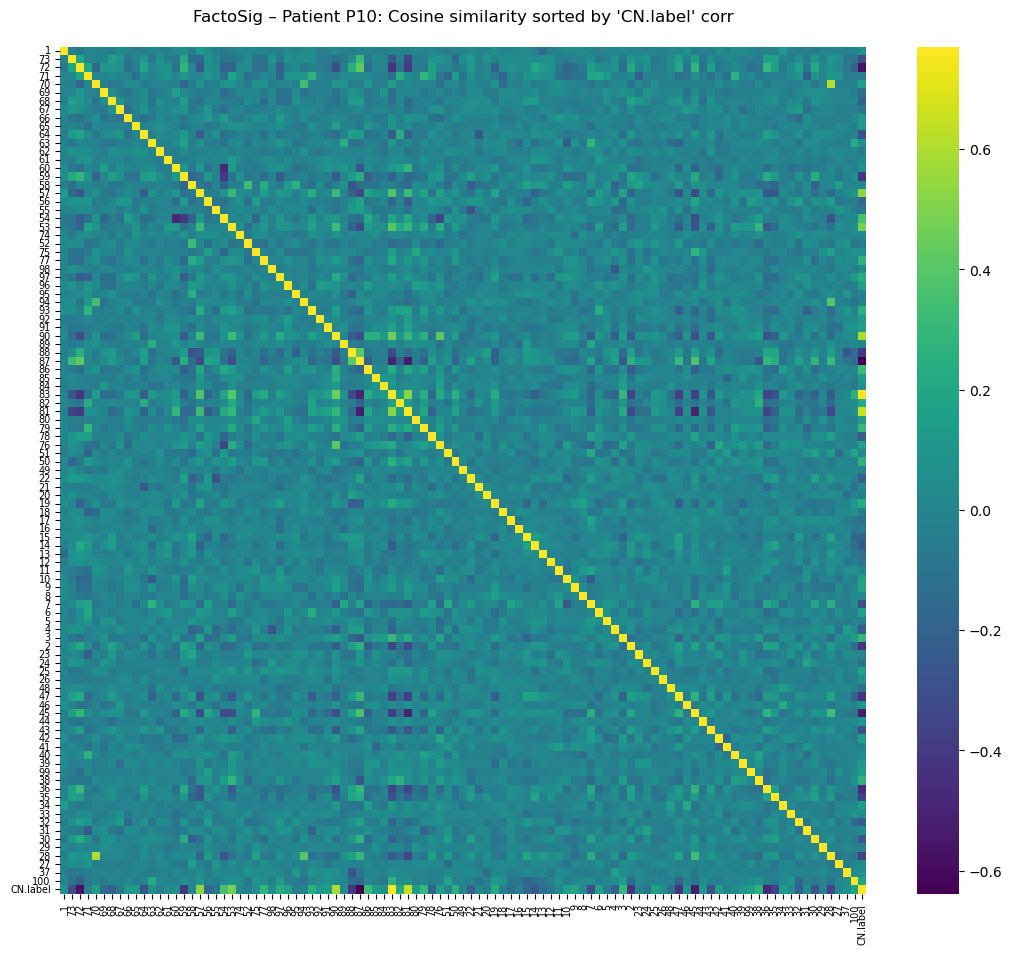

--- Patient P12 (Sorted by Target Correlation) ---


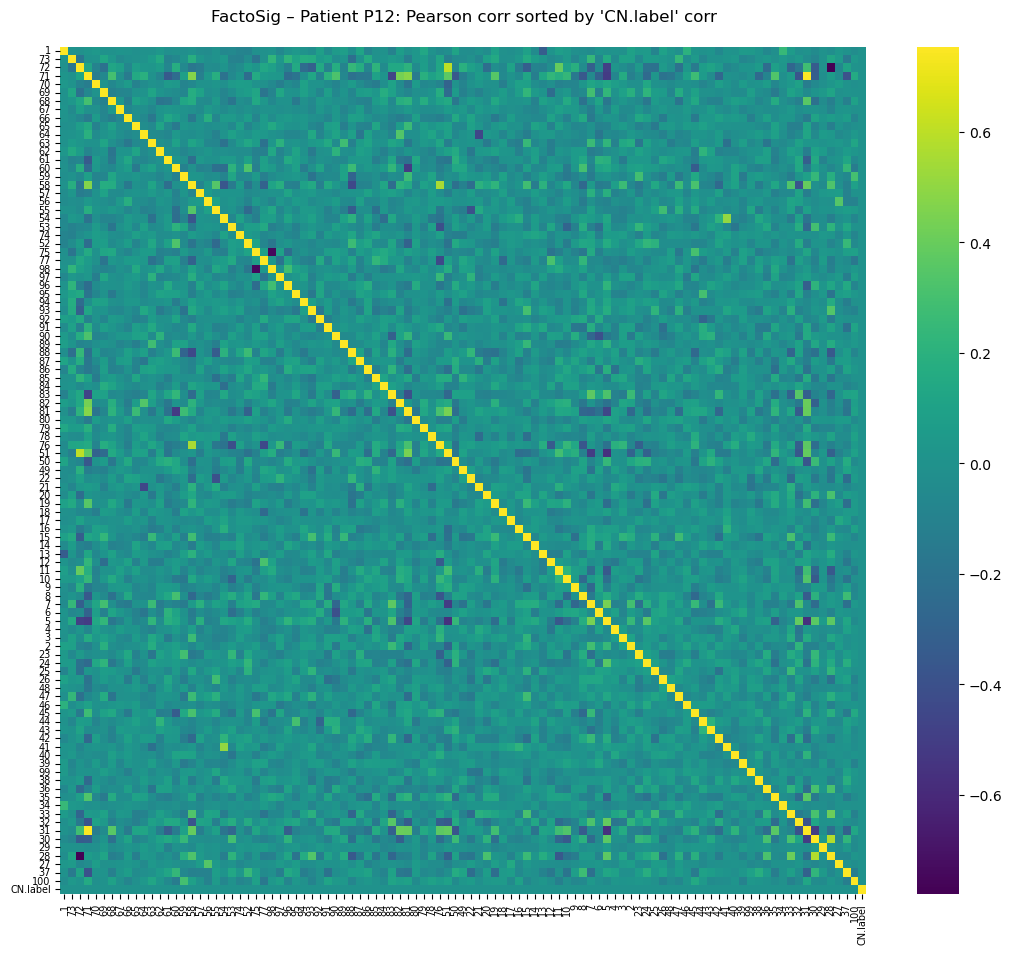

--- Patient P09 (Sorted by Target Correlation) ---


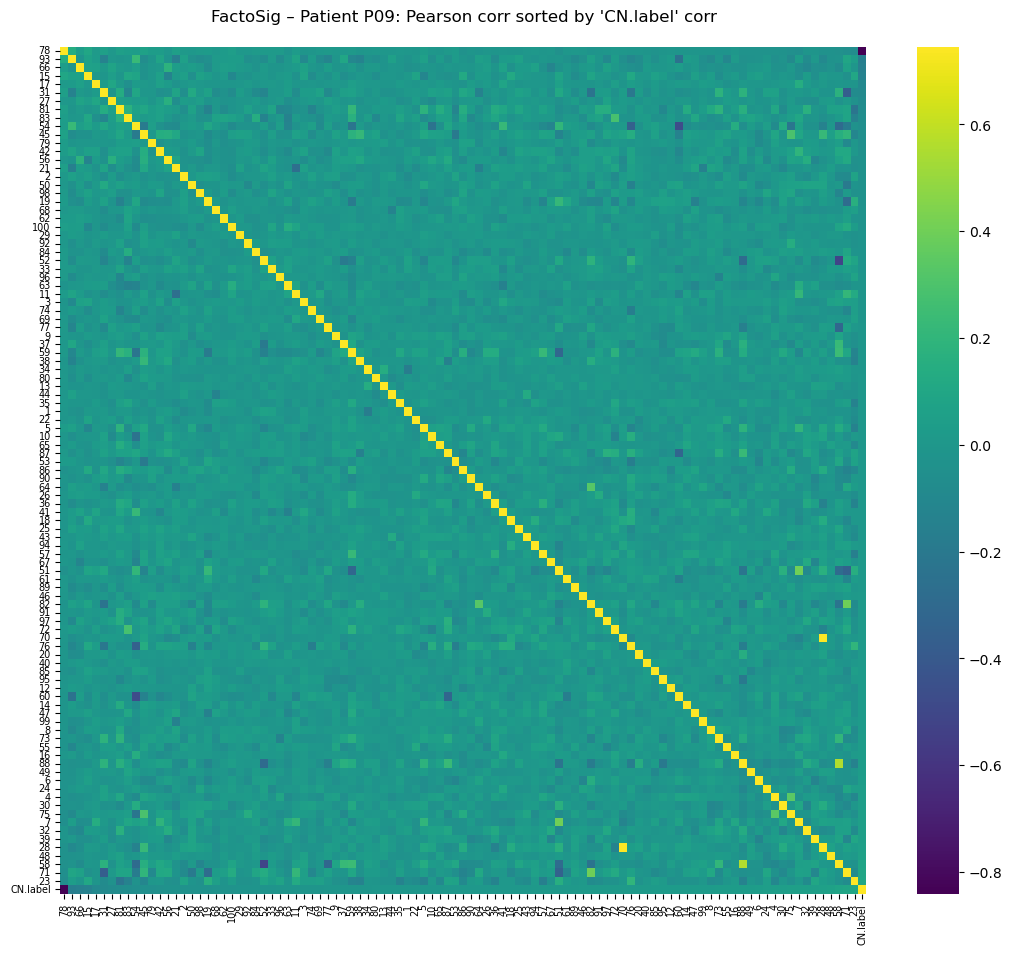

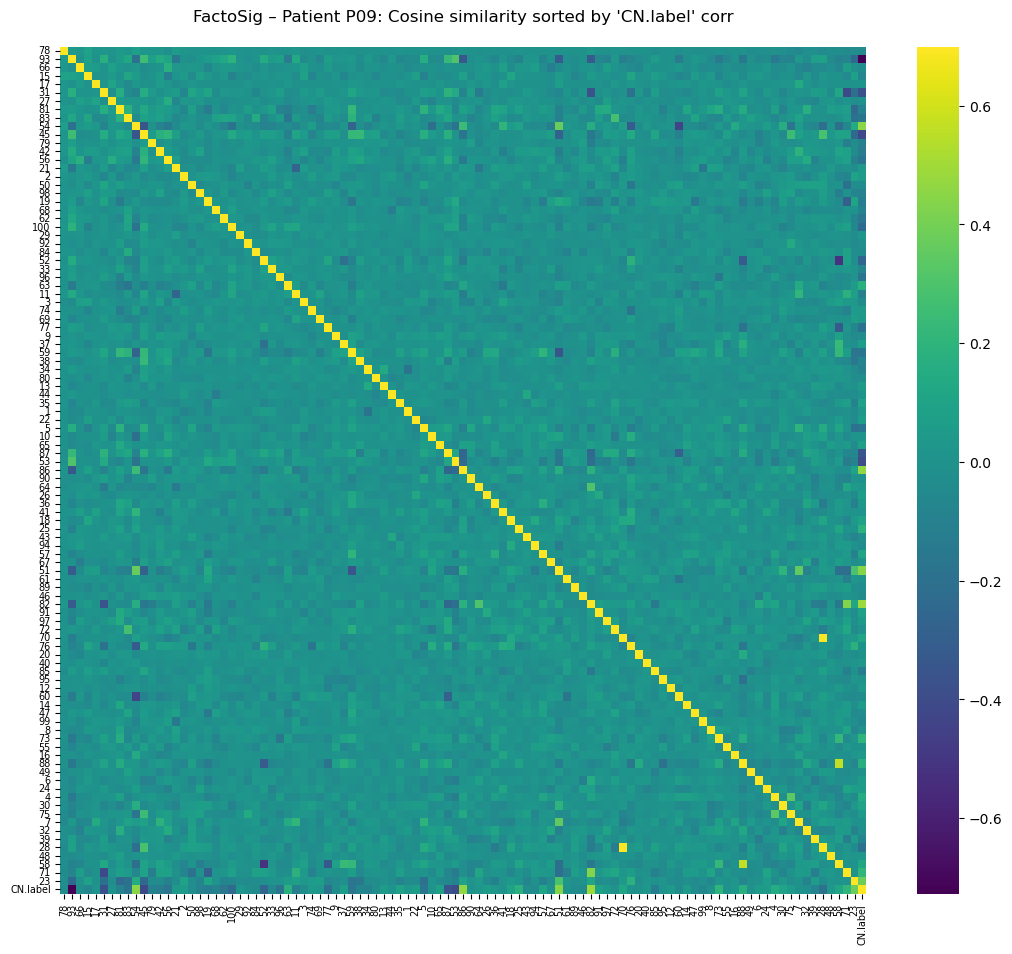

--- Patient P08 (Sorted by Target Correlation) ---


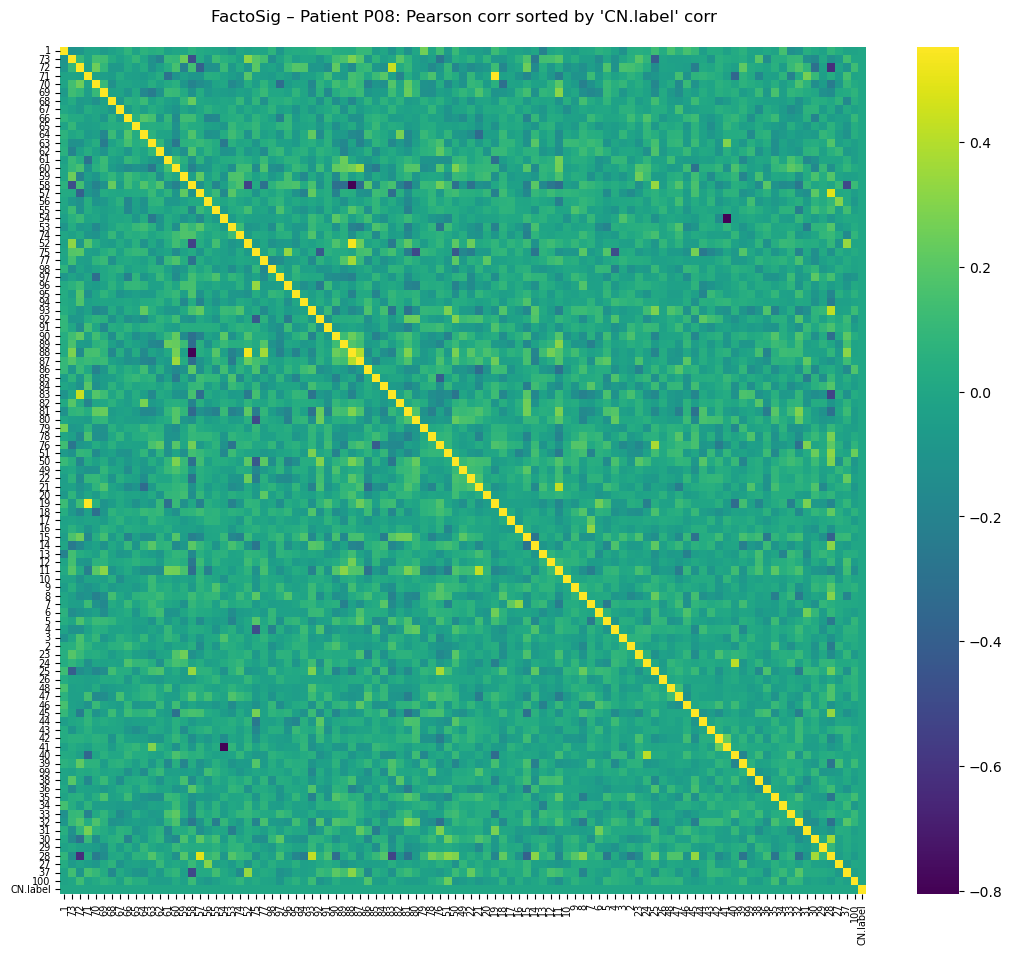

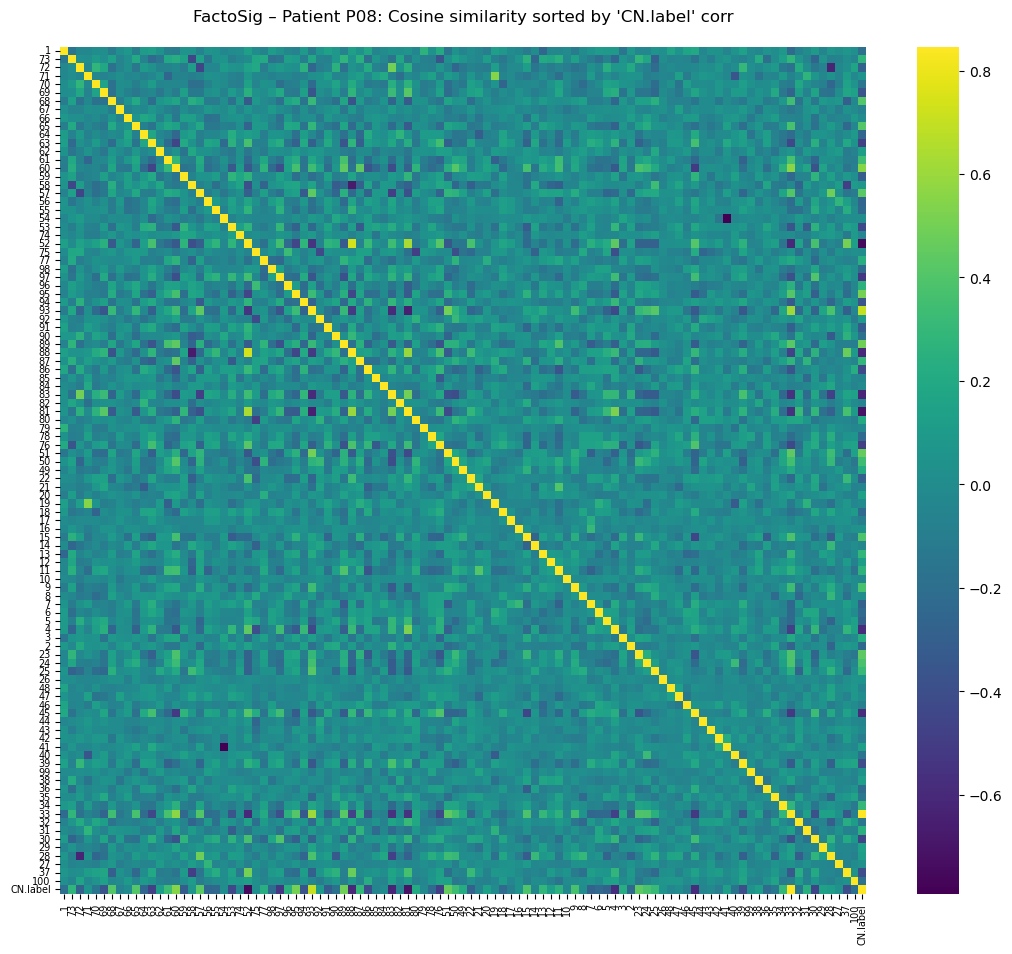

--- Patient P13 (Sorted by Target Correlation) ---


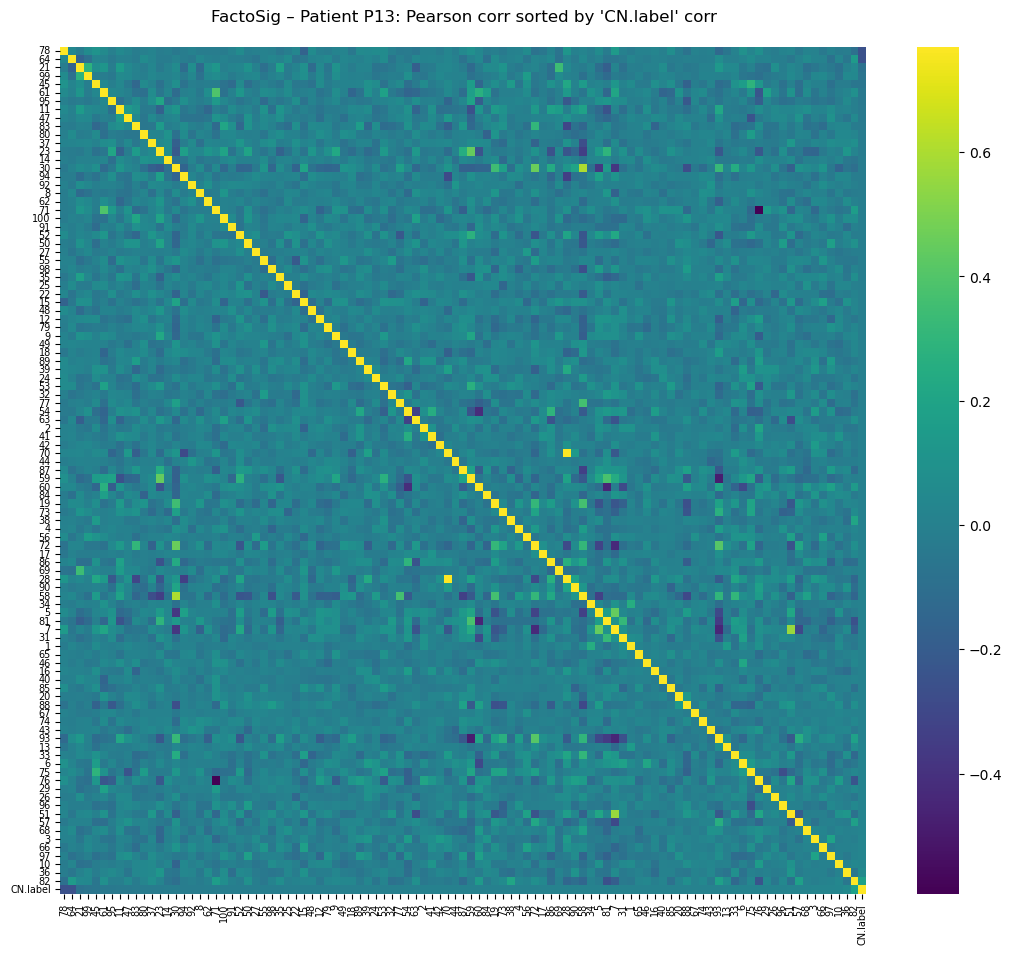

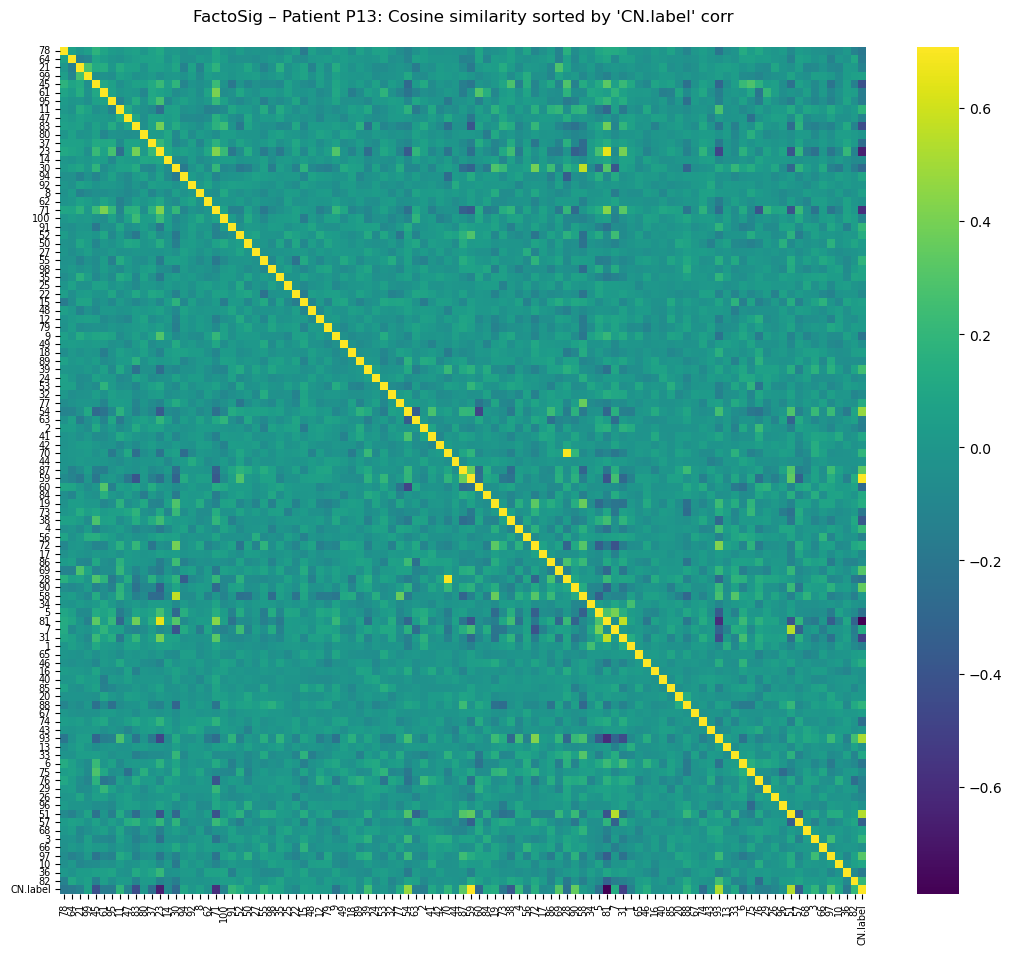

In [17]:
for pid in list(fs_patient_mats.keys()):
    print(f"--- Patient {pid} (Sorted by Target Correlation) ---")
    plot_patient_mats_sorted_by_target(fs_patient_mats, pid, method_name="FactoSig")


New Chatgpt

In [6]:
# --- setup ---
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# if you have statsmodels >= 0.13, we can use BinomialBayesMixedGLM
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

# ---- config: adjust if your column names differ ----
PAT_COL   = "patient"
LABEL_COL = "CN.label"
FA_SCORES_KEY = "fs_scores"     # adata.obsm
FA_LOADINGS_KEY = "fs_loadings" # adata.varm

# sanity checks
assert FA_SCORES_KEY in adata_fs.obsm, f"missing {FA_SCORES_KEY} in adata.obsm"
assert FA_LOADINGS_KEY in adata_fs.varm, f"missing {FA_LOADINGS_KEY} in adata.varm"
assert PAT_COL   in adata_fs.obs.columns, f"missing {PAT_COL} in adata.obs"
assert LABEL_COL in adata_fs.obs.columns, f"missing {LABEL_COL} in adata.obs"

Z = adata_fs.obsm[FA_SCORES_KEY].astype(float)     # (n_cells, k)
L = adata_fs.varm[FA_LOADINGS_KEY].astype(float)   # (n_genes, k)
patients = adata_fs.obs[PAT_COL].astype(str).values
MAP = {'cancer': 1, 'normal': 0}  # extend if needed
y = (adata_fs.obs[LABEL_COL]
       .astype(str).str.lower()
       .map(MAP)
       .fillna(0)                 # or raise if unexpected labels
       .astype(int)
       .values)
k = Z.shape[1]

# standardize factor scores within patient (optional but helps stability)
Z_std = Z.copy()
for pid in np.unique(patients):
    idx = (patients == pid)
    Z_std[idx] = StandardScaler(with_mean=True, with_std=True).fit_transform(Z[idx])

# helper: corr matrix for rows
def corr_mat(X):
    Xc = X - X.mean(axis=0, keepdims=True)
    Xc /= (Xc.std(axis=0, ddof=1, keepdims=True) + 1e-8)
    return (Xc.T @ Xc) / (Xc.shape[0] - 1)


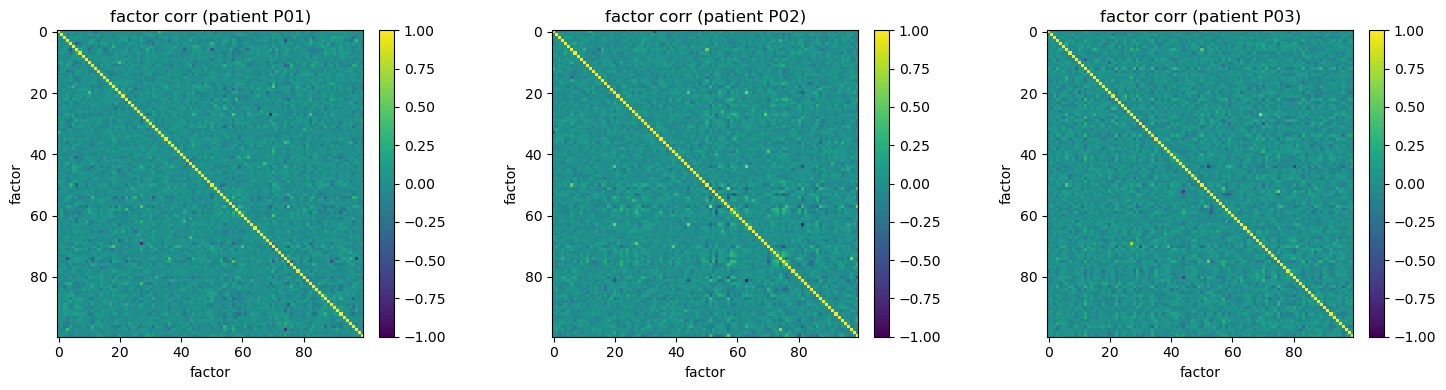

patient P01: 84 modules; sizes = [1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1]
patient P02: 82 modules; sizes = [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]
patient P03: 90 modules; sizes = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1]
patient P04: 79 modules; sizes = [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 

In [8]:
from collections import defaultdict

patient_modules = {}  # pid -> list of modules (each module: list of factor indices)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.ravel()
example_pids = list(pd.Index(np.unique(patients)))  # show first 3 patients

for i, pid in enumerate(np.unique(patients)):
    idx = (patients == pid)
    Zp = Z_std[idx]  # (n_cells_patient, k)

    C = corr_mat(Zp)  # (k, k) factor-factor corr within patient
    # plot heatmap for a few example patients
    if i < 3:
        im = axes[i].imshow(C, vmin=-1, vmax=1, aspect='equal')
        axes[i].set_title(f"factor corr (patient {pid})"); axes[i].set_xlabel("factor"); axes[i].set_ylabel("factor")
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    # hierarchical clustering on 1 - |corr|
    dist = 1.0 - np.abs(C)
    # convert to condensed distance for linkage
    iu = np.triu_indices_from(dist, k=1)
    dist_vec = dist[iu]
    Zlink = linkage(dist_vec, method="average")
    # choose a threshold; smaller -> more clusters; tune 0.6–0.8 for your data
    labels = fcluster(Zlink, t=0.7, criterion='distance')

    modules = []
    for lab in np.unique(labels):
        modules.append(np.where(labels == lab)[0].tolist())
    patient_modules[pid] = modules

plt.tight_layout()
plt.show()

# quick text summary
for pid in example_pids:
    print(f"patient {pid}: {len(patient_modules[pid])} modules; sizes = {[len(m) for m in patient_modules[pid]]}")


U shape (cells × modules): (60118, 1090)


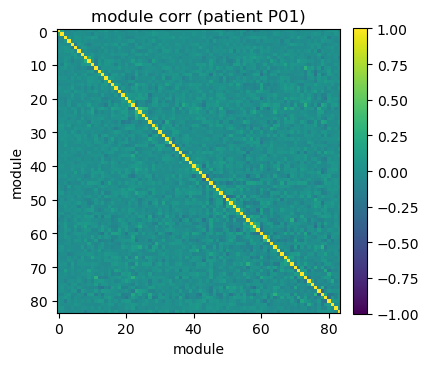

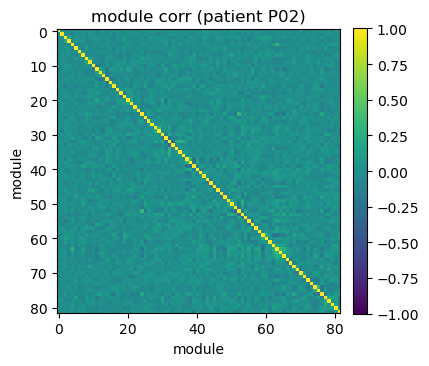

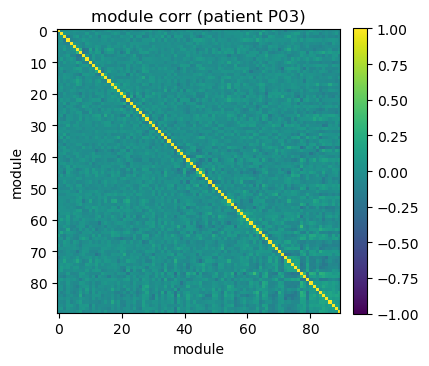

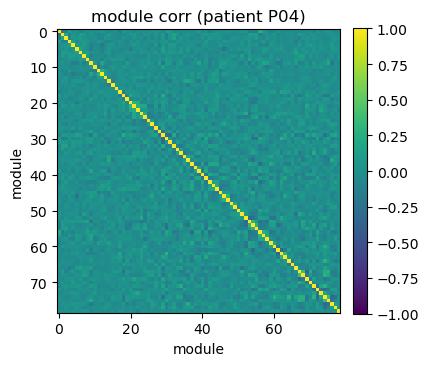

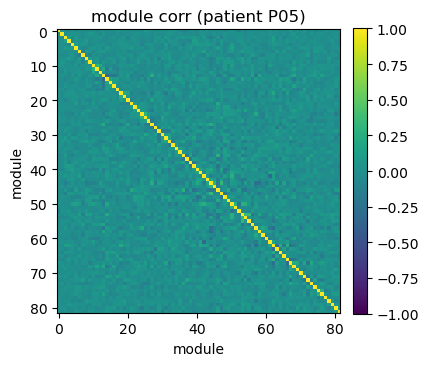

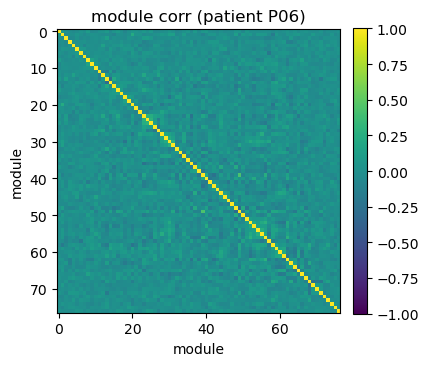

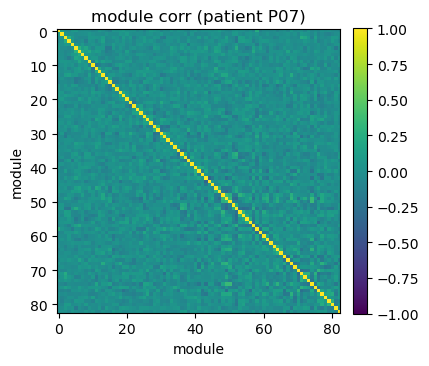

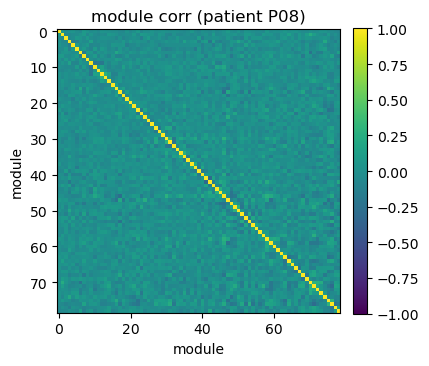

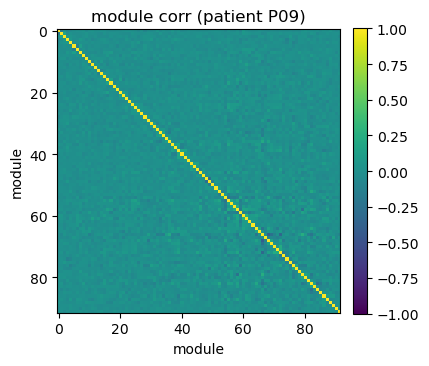

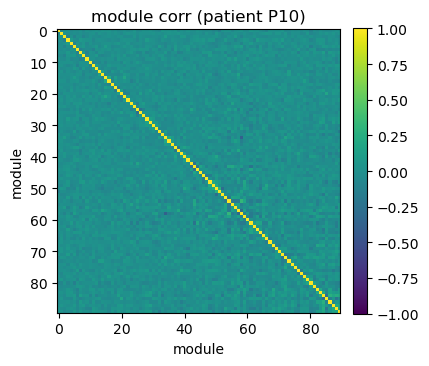

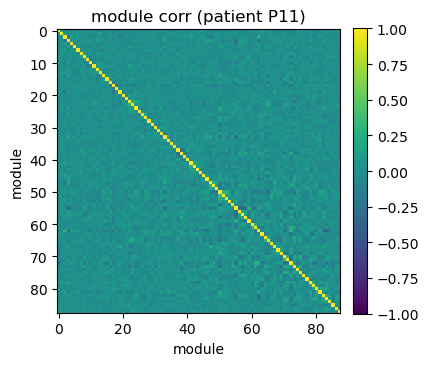

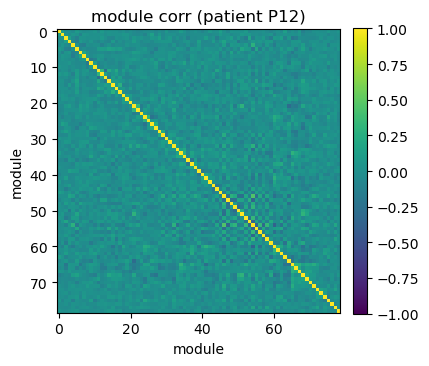

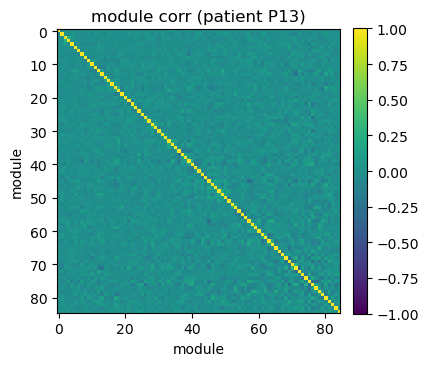

X shape: (60118, 1091) Z shape: (60118, 1103)
               Binomial Mixed GLM Results
        Type Post. Mean Post. SD    SD   SD (LB) SD (UB)
--------------------------------------------------------
FE_1       M    -0.1819   0.0268                        
FE_2       M    -0.0162   0.0180                        
FE_3       M    -0.0124   0.0194                        
FE_4       M    -0.0202   0.0183                        
FE_5       M    -0.0292   0.0183                        
FE_6       M    -0.0178   0.0190                        
FE_7       M     0.0214   0.0176                        
FE_8       M     0.0124   0.0169                        
FE_9       M    -0.0196   0.0184                        
FE_10      M    -0.0068   0.0162                        
FE_11      M     0.0180   0.0166                        
FE_12      M    -0.0189   0.0170                        
FE_13      M    -0.0322   0.0165                        
FE_14      M     0.0420   0.0157                        


In [18]:
# compute module scores (mean) per patient with a GLOBAL column set
U_list = []        # rows per patient, same global #cols
pid_list = []      # patient id per row
module_map = {}    # (pid, m_index) -> list of factor ids

# 1) Build global column index for all (patient, module)
col_index = {}
colnames = []
for pid in np.unique(patients):
    mods = patient_modules[pid]
    for m_i, M in enumerate(mods):
        module_map[(pid, m_i)] = list(M)
        name = f"{pid}::M{m_i}"
        col_index[(pid, m_i)] = len(colnames)
        colnames.append(name)

n_cols = len(colnames)

# 2) Fill per-patient rows into global-width matrices
for pid in np.unique(patients):
    idx = (patients == pid)
    Zp = Z_std[idx]  # (n_p, k)
    U_pid = np.zeros((idx.sum(), n_cols), dtype=np.float32)

    for m_i, M in enumerate(patient_modules[pid]):
        M = list(M)
        mean_score = Zp[:, M].mean(axis=1)  # (n_p,)
        j = col_index[(pid, m_i)]
        U_pid[:, j] = mean_score

    U_list.append(U_pid)
    pid_list.append(np.repeat(pid, idx.sum()))

U = np.vstack(U_list) if len(U_list) else np.zeros((Z_std.shape[0], n_cols), dtype=np.float32)
pid_arr = np.concatenate(pid_list)

print("U shape (cells × modules):", U.shape)

# standardize module columns globally (helps GLM fitting)
U = (U - U.mean(axis=0, keepdims=True)) / (U.std(axis=0, ddof=1, keepdims=True) + 1e-8)

# quick visualization: per-patient module corr
def block_corr(U, pid_arr, pid, cols_for_pid):
    # select columns that belong to that patient
    col_idx = [j for j,c in enumerate(colnames) if c.startswith(f"{pid}::")]
    if not col_idx:
        return None
    Up = U[pid_arr==pid][:, col_idx]
    Cp = corr_mat(Up)
    return Cp, col_idx

figs = []
for pid in example_pids:
    out = block_corr(U, pid_arr, pid, colnames)
    if out is not None:
        Cp, col_idx = out
        plt.figure(figsize=(4,4))
        plt.imshow(Cp, vmin=-1, vmax=1, aspect='equal')
        plt.title(f"module corr (patient {pid})"); plt.xlabel("module"); plt.ylabel("module")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.show()

# ---------- Hierarchical logistic with random slopes (Bayes Mixed GLM) ----------
# We give each patient a random intercept, and each module a random slope *within that patient*.
# Implementation detail: BinomialBayesMixedGLM expects a specific random-effects design.

# Fixed effects X (add intercept)
X = np.column_stack([np.ones((U.shape[0], 1)), U])  # [intercept | all module columns]
X_cols = ["Intercept"] + colnames

# Random effects Z:
# For each patient and each patient-owned module column, create a random-effect column
# so slope for that module can vary by that patient. Also add a random intercept per patient.
# This can get large; feel free to start with random intercept only, then add selected modules.

# build mapping from patients to their module column indices in X (excluding the global intercept at col 0)
pid_to_modcols = {}
for pid in np.unique(patients):
    pid_to_modcols[pid] = [1 + j for j,c in enumerate(colnames) if c.startswith(f"{pid}::")]

# random effects design:
# Z_re will have: one column per (patient, intercept) + one column per (patient, module-col)
Z_cols = []
Z_list = []

# (a) random intercept per patient
for pid in np.unique(patients):
    Zi = (pid_arr == pid).astype(float).reshape(-1,1)
    Z_list.append(Zi); Z_cols.append(f"{pid}::(intercept)")

# (b) random slope per (patient,module)
for pid in np.unique(patients):
    rows = (pid_arr == pid)
    for j in pid_to_modcols[pid]:
        col = np.zeros((U.shape[0], 1))
        col[rows, 0] = X[rows, j]  # copy the module's fixed regressor for this patient's rows only
        Z_list.append(col); Z_cols.append(f"{pid}::slope@{X_cols[j]}")

Z = np.hstack(Z_list) if len(Z_list) else None

print("X shape:", X.shape, "Z shape:", None if Z is None else Z.shape)

y_vec = y.astype(int)

# X: [n_obs × (1 + n_modules)] with intercept in column 0
# pid_arr: length n_obs, patient id per row
# y_vec: 0/1 labels

# Random intercept per patient:
pat_cats, pat_idx = np.unique(pid_arr, return_inverse=True)
n_pat = len(pat_cats)

# S: indicator design for random intercepts (n_obs × n_pat)
# More memory-efficient than building zeros then assigning
S = np.eye(n_pat, dtype=float)[pat_idx]

# exog_vc is a list of variance-component designs (can be list or dict)
# S as above
exog_vc = S                                  # 2D ndarray
ident   = np.zeros(S.shape[1], dtype=int)    # 1D array, length = n_pat

model = BinomialBayesMixedGLM(y_vec, X, exog_vc, ident)
fit = model.fit_vb()
print(fit.summary())

In [15]:
import numpy as np
import statsmodels.api as sm
from numpy.linalg import LinAlgError
from sklearn.linear_model import LogisticRegression

per_patient_betas = {}

def _drop_collinear_with_intercept(Xp, names, tol=1e-8):
    # Xp: [n, p] design with intercept in col 0; names length p
    if Xp.shape[1] <= 1:
        return Xp, names

    # 1) Drop near-constant predictors (excluding intercept)
    Xrest = Xp[:, 1:]
    keep_std = (Xrest.std(axis=0, ddof=1) > tol)
    Xrest = Xrest[:, keep_std]
    rest_names = [n for n, k in zip(names[1:], keep_std) if k]

    if Xrest.shape[1] == 0:
        # Only intercept remains
        return Xp[:, :1], names[:1]

    # 2) QR with column pivoting to select independent columns
    # np.linalg.qr with pivoting returns Q, R, piv s.t. Xrest[:, piv] = Q @ R
    Q, R, piv = np.linalg.qr(Xrest, mode='reduced', pivoting=True)
    diagR = np.abs(np.diag(R))
    rank = int(np.sum(diagR > tol))
    piv_keep = piv[:rank]

    Xrest_sel = Xrest[:, piv_keep]
    names_sel = [rest_names[i] for i in piv_keep]

    # 3) Rebuild design (intercept + selected predictors)
    X_new = np.column_stack([Xp[:, :1], Xrest_sel])
    names_new = [names[0]] + names_sel
    return X_new, names_new

for pid in np.unique(patients):
    rows = (pid_arr == pid)
    cols = [0] + [j for j,c in enumerate(colnames, start=1) if c.startswith(f"{pid}::")]
    Xp = X[rows][:, cols]
    yp = y_vec[rows]
    if Xp.shape[1] < 2 or len(np.unique(yp)) < 2:
        continue

    # Drop collinear/constant predictors (keep intercept)
    names = ["Intercept"] + [X_cols[j] for j in cols[1:]]
    Xp2, names2 = _drop_collinear_with_intercept(Xp, names)

    try:
        # Try unpenalized
        fitp = sm.Logit(yp, Xp2).fit(disp=0)
        params = fitp.params
        ses = fitp.bse
    except (LinAlgError, ValueError):
        try:
            # Ridge-penalized logit (no SEs)
            fitp = sm.Logit(yp, Xp2).fit_regularized(alpha=1e-4, L1_wt=0.0)
            params = fitp.params
            ses = np.full_like(params, np.nan)
        except Exception:
            # Fallback to scikit-learn L2 (no SEs)
            clf = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=2000)
            clf.fit(Xp2, yp)
            params = np.r_[clf.intercept_, clf.coef_.ravel()]
            ses = np.full_like(params, np.nan)

    per_patient_betas[pid] = (np.array(names2), params, ses)

# plotting: forest (ORs with CI where available)
for pid, (names, params, ses) in list(per_patient_betas.items())[:3]:
    or_vals = np.exp(params)
    if np.all(np.isnan(ses)):
        lo = hi = None
    else:
        lo = np.exp(params - 1.96*ses); hi = np.exp(params + 1.96*ses)
    ix = np.arange(len(params))
    plt.figure(figsize=(6, 0.4*len(params)+2))
    if lo is not None:
        plt.errorbar(or_vals, ix, xerr=[or_vals - lo, hi - or_vals], fmt='o')
    else:
        plt.plot(or_vals, ix, 'o')
    plt.axvline(1.0, linestyle='--')
    plt.yticks(ix, names); plt.xlabel("Odds ratio"); plt.title(f"Per-patient ORs (patient {pid})")
    plt.tight_layout(); plt.show()

TypeError: qr() got an unexpected keyword argument 'pivoting'

## How FA maps from cells×genes (X) to scores (Z) and loadings (Λ)

Let \(X \in \mathbb{R}^{n\times p}\) be cells×genes (rows centered per gene). Gaussian FA assumes a latent linear model:

- Generative model: \(x_i = \mu + \Lambda z_i + \epsilon_i\), where \(z_i \sim \mathcal{N}(0, I_k)\) and \(\epsilon_i \sim \mathcal{N}(0, \Psi)\) with \(\Psi=\mathrm{diag}(\psi_1,\ldots,\psi_p)\).
- Implied covariance: \(\Sigma = \Lambda \Lambda^\top + \Psi\).

Estimators used here:

1) scikit-learn FactorAnalysis (unrotated)
- Objective: maximize Gaussian likelihood of \(X\) under \(\Sigma\).
- Optimization: EM with SVD-based linear algebra. After convergence you get \(\hat\Lambda\) (as `components_.T`) and \(\hat\Psi\).
- Scores returned by `fit_transform`: posterior means
  \[ m_i = \mathbb{E}[z_i\mid x_i] = K^{-1} \Lambda^\top \Psi^{-1} (x_i-\mu), \quad K = I + \Lambda^\top \Psi^{-1} \Lambda. \]
- No rotation by default (columns need not be sparse; near-orthogonality can still happen empirically).

2) FactoSig (Gaussian FA + orthogonal varimax rotation)
- Core FA is optimized by gradient descent on the exact negative log-likelihood using Woodbury identities. After fit, posterior scores are identical in form to above with \(K^{-1}\).
- Then an orthogonal varimax rotation \(R\) is applied to loadings and scores: \(\Lambda \leftarrow \Lambda R\), \(Z \leftarrow Z R\). Sign convention per factor is also enforced. Rotation is orthogonal ⇒ factors remain uncorrelated (in expectation), which explains small off‑diagonal correlations and low VIF.

Correlation/cosine matrices
- We compute Pearson corr or cosine sim across columns of \(Z\) (size \(n\times k\)). Diagonal is \(1\). We often “zoom” the color scale to off-diagonal range to reveal subtle structure.

Incorporating CN.label
- Encode \(y \in \{0,1\}^n\) and append it as column \(k+1\) to \([Z\,|\,y]\). Then compute correlation/cosine across columns → a \((k+1)\times(k+1)\) matrix. The entries in the last row/column are point‑biserial correlations (equivalent to Pearson between a continuous vector and a binary 0/1 target).
